# Prefetch Suppression Study

We are interested in suppressing prefetches that have a low accuracy, defined as number of useful prefetches over total prefetches issued. This study examines the effect of suppressing prefetches by cacheline and by PC.

### Prefetch Suppression Metrics

**Speedup**: Performance gained/lost by suppressing prefetches

**Coverage**: Coverage gained/lost by suppressing prefetches

**Number/Percent of Suppressed Prefetches**: 

In [2]:
import sys, re
import matplotlib as mpl
import numpy as np
import os
import subprocess
import copy
mpl.rcParams['font.size'] = 14
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse

NROWS=5
NCOLS=5

In [3]:
def get_experiment_traces(experiment, trace_list):
    traces = []
    experiment_trace_files = []
    for trace in trace_list:
        trace = trace[:-1]
        traces.append(trace)
        experiment_trace = '../current_output/'+experiment+'/'+trace+'.txt'
        experiment_trace_files.append(experiment_trace)
    return (experiment_trace_files, traces)

In [4]:
def search(regex, pos, trace_files):
    result = []
    for trace_file in trace_files:
        found = False
        for line in open(trace_file, 'r'):
            if not found and re.match(regex, line):
                result.append(float(line.split()[pos]))
                found = True
    return result

In [5]:
def compare_performance(base_trace_files, comp_trace_files, traces):
    baseline_ipc = search('CPU 0 cumulative IPC', 4, base_trace_files)
    comparison_ipc = search('CPU 0 cumulative IPC', 4, comp_trace_files)
    
#     print(len(baseline_ipc))
#     print(len(comparison_ipc))
    
    speedup = [comparison_ipc[i]/baseline_ipc[i] for i in range(len(traces))]
    
    return speedup

def compare_coverage(base_trace_files, comp_trace_files, traces):
    baseline_misses = search('LLC LOAD', 7, base_trace_files)
    comparison_misses = search('LLC LOAD', 7, comp_trace_files)
    coverage = [(baseline_misses[i]-comparison_misses[i])/baseline_misses[i] for i in range(len(traces))]
    
    return coverage

In [6]:
def get_memory_traffic(trace_files):
    memory_traffic = search('LLC TOTAL', 7, trace_files)
    memory_traffic = [round(i / 200000, 3) for i in memory_traffic]
    return memory_traffic

In [7]:
def get_ipc(trace_files):
    ipc = search('CPU 0 cumulative IPC', 4, trace_files)
    return ipc

In [8]:
def get_average_DRAM_latency(trace_files):
    avg_dram_latency = search('LLC MEDIAN MISS LATENCY: ', 4, trace_files)
    return avg_dram_latency

In [9]:
def find_best_accuracy_threshold(base_trace_files, traces):
    best_accuracy_thresholds = [5] * len(traces)
    cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_quarter_bandwidth_accuracy_threshold_05/'
    trace_list = open('../sim_list/traces.txt', 'r')
    (comp_trace_files_0, traces_0) = get_experiment_traces(cmp_experiment, trace_list)
    base_speedup = compare_performance(base_trace_files, comp_trace_files_0, traces)
    for i in range(2, 19):
        cmp_experiment = f'experiment_tracer_hawkeye_final_dyn_bo_degree_4_quarter_bandwidth_accuracy_threshold_{i*5}/'
        trace_list = open('../sim_list/traces.txt', 'r')
        (comp_trace_files_1, traces_1) = get_experiment_traces(cmp_experiment, trace_list)
        
        speedup_1 = compare_performance(base_trace_files, comp_trace_files_1, traces)
        
        for j in range(len(base_speedup)):
            if (speedup_1[j] > base_speedup[j]):
                base_speedup[j] = speedup_1[j]
                best_accuracy_thresholds[j] = i*5

    return (best_accuracy_thresholds, base_speedup)

In [10]:
def search_prefetch_suppression_stats(experiment_trace_files):
    num_pf_suppressed = search('LLC num suppressed prefetches:')
    num_addr_marked = search('LLC num addresses marked for suppression:')
    num_ip_marked = search('LLC num ips marked for suppression:')
    
    return (num_pf_suppressed, num_addr_marked, num_ip_marked)

In [11]:
def add_data_labels(bar, ax, labels):
    rects = bar.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
        
def mean(data):
    total = 0
    count = 0
    for x in data:
        if (not np.isnan(x)):
            total += x
        else:
            total += 0
        count += 1
    return  round(float(total/count), 3)
def add_mean(data):
    data.append(mean(data))
    return data

In [12]:
def graph_stat(stats, traces, title, ylabel, cmp_experiment):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    best_accuracy_thresholds = add_mean(stats)
    
    # plot
    bar = ax.bar(traces_with_mean, stats, width=0.5)
    
    # add data labels
    add_data_labels(bar, ax, stats)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # axis label and title formatting
    ax.set_title(f'{title} {cmp_experiment}')
    ax.set_xlabel('Benchmarks')
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=0, top=100)
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)

In [13]:
def graph_best_speedup(traces, best_speedup):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    
    best_speedup = [round(float(i) - 1.0, 3) for i in best_speedup]
    best_speedup = add_mean(best_speedup)
    
    # format center axis
    ax.spines['bottom'].set_position('center')
    ax.set_ylim(bottom=-1, top = 1)
    
    # plot
    bar = ax.bar(traces_with_mean, best_speedup, width=0.5)
    
    # add data labels
    add_data_labels(bar, ax, best_speedup)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # axis label and title formatting
    ax.set_title(f'Best Speedup of Prefetch Suppression')
    ax.set_xlabel('benchmarks')
    ax.set_ylabel('Best Speedup')
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)

In [14]:
def graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    
    # get stats
    speedup = compare_performance(base_trace_files, comp_trace_files, traces)
    speedup = add_mean(speedup)
    speedup = [round(i - 1.0, 3) for i in speedup]
    
    # format center axis
    ax.spines['bottom'].set_position('center')
    ax.set_ylim(bottom=-1, top = 1)
    
    # plot
    bar = ax.bar(traces_with_mean, speedup, width=0.5)
    
    # add data labels
    add_data_labels(bar, ax, speedup)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # axis label and title formatting
    ax.set_title(f'Speedup of Prefetch Suppression {cmp_experiment}')
    ax.set_xlabel('benchmarks')
    ax.set_ylabel('speedup')
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)
    

In [15]:
def graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    
    # get stats
    coverage = compare_coverage(base_trace_files, comp_trace_files, traces)
    coverage = add_mean(coverage)
    coverage = [round(i, 2) for i in coverage]
    
    # format center axis
    ax.spines['bottom'].set_position('center')
    ax.set_ylim(bottom=-3, top = 3)
    
    # plot
    bar = ax.bar(traces_with_mean, coverage, width=0.5)
    
    # add data labels
    add_data_labels(bar, ax, coverage)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # axis label and title formatting
    ax.set_title(f'Coverage of Prefetch Suppression {cmp_experiment}')
    ax.set_xlabel('benchmarks')
    ax.set_ylabel('speedup')
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)

In [16]:
def graph_two_stats(stat1, stat2, traces, title, ylabel, cmp_experiment, label1, label2, ymin, ymax):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    stat1_ = add_mean(stat1)
    stat2_ = add_mean(stat2)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # plot
    bar = ax.bar(ind, stat1_, width=0.4, label = label1)
    
    # add data labels
    add_data_labels(bar, ax, stat1_)
    
    # plot
    bar = ax.bar(ind+0.4, stat2_, width=0.4, label = label2)
    
    # add data labels
    add_data_labels(bar, ax, stat2_)
    
    # axis label and title formatting
    ax.set_title(f'{title} {cmp_experiment}')
    ax.set_xlabel('Benchmarks')
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=ymin, top=ymax)
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)
    
    ax.legend()

In [17]:
def graph_three_stats(stat1, stat2, stat3, traces, title, ylabel, cmp_experiment, label1, label2, label3, ymin, ymax):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    stat1_ = add_mean(stat1)
    stat2_ = add_mean(stat2)
    stat3_ = add_mean(stat3)
    
    # format x axis
    ind = np.arange(0, 2*(len(traces) + 1), 2)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # plot
    bar = ax.bar(ind, stat1_, width=0.4, label = label1)
    
    # add data labels
    add_data_labels(bar, ax, stat1_)
    
    # plot
    bar = ax.bar(ind+0.4, stat2_, width=0.4, label = label2)
    
    # add data labels
    add_data_labels(bar, ax, stat2_)
    
    # plot
    bar = ax.bar(ind+0.8, stat3_, width=0.4, label = label3)
    
    # add data labels
    add_data_labels(bar, ax, stat3_)
    
    # axis label and title formatting
    ax.set_title(f'{title} {cmp_experiment}')
    ax.set_xlabel('Benchmarks')
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=ymin, top=ymax)
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)
    
    ax.legend()

In [18]:
def graph_four_stats(stat1, stat2, stat3, stat4, traces, title, ylabel, cmp_experiment, label1, label2, label3, label4, ymin, ymax):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    stat1_ = add_mean(stat1)
    stat2_ = add_mean(stat2)
    stat3_ = add_mean(stat3)
    stat4_ = add_mean(stat4)
    
    # format x axis
    ind = np.arange(0, 2*(len(traces) + 1), 2)
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # plot
    bar = ax.bar(ind, stat1_, width=0.4, label = label1)
    
    # add data labels
    add_data_labels(bar, ax, stat1_)
    
    # plot
    bar = ax.bar(ind+0.4, stat2_, width=0.4, label = label2)
    
    # add data labels
    add_data_labels(bar, ax, stat2_)
    
    # plot
    bar = ax.bar(ind+0.8, stat3_, width=0.4, label = label3)
    
    # add data labels
    add_data_labels(bar, ax, stat3_)
    
    # plot
    bar = ax.bar(ind+1.2, stat4_, width=0.4, label = label4)
    
    # add data labels
    add_data_labels(bar, ax, stat4_)
    
    # axis label and title formatting
    ax.set_title(f'{title} {cmp_experiment}')
    ax.set_xlabel('Benchmarks')
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=ymin, top=ymax)
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)
    
    ax.legend()

In [19]:
def graph_9_stats(stat1, stat2, stat3, stat4, stat5, stat6, stat7, stat8, stat9, traces, title, 
              ylabel, cmp_experiment, label1, label2, label3, label4, label5, label6, label7, label8, label9, ymin, ymax):
    fig, ax = plt.subplots()
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    stat1_ = add_mean(stat1)
    stat2_ = add_mean(stat2)
    stat3_ = add_mean(stat3)
    stat4_ = add_mean(stat4)
    stat5_ = add_mean(stat5)
    stat6_ = add_mean(stat6)
    stat7_ = add_mean(stat7)
    stat8_ = add_mean(stat8)
    stat9_ = add_mean(stat9)
    
    # format x axis
    ind = np.arange(0, 4*(len(traces) + 1), 4)
    ax.set_xticks(np.arange(0, 4*(len(traces) + 1), 4))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # plot
    bar = ax.bar(ind, stat1_, width=0.4, label = label1)
    
    # add data labels
    add_data_labels(bar, ax, stat1_)
    
    # plot
    bar = ax.bar(ind+0.4, stat2_, width=0.4, label = label2)
    
    # add data labels
    add_data_labels(bar, ax, stat2_)
    
    # plot
    bar = ax.bar(ind+0.8, stat3_, width=0.4, label = label3)
    
    # add data labels
    add_data_labels(bar, ax, stat3_)
    
    # plot
    bar = ax.bar(ind+1.2, stat4_, width=0.4, label = label4)
    
    # add data labels
    add_data_labels(bar, ax, stat4_)
    
    # plot
    bar = ax.bar(ind+1.6, stat5_, width=0.4, label = label5)
    
    # add data labels
    add_data_labels(bar, ax, stat5_)
    
    # plot
    bar = ax.bar(ind+2.0, stat6_, width=0.4, label = label6)
    
    # add data labels
    add_data_labels(bar, ax, stat6_)
    
    # plot
    bar = ax.bar(ind+2.4, stat7_, width=0.4, label = label7)
    
    # add data labels
    add_data_labels(bar, ax, stat7_)
    
    # plot
    bar = ax.bar(ind+2.8, stat8_, width=0.4, label = label8)
    
    # add data labels
    add_data_labels(bar, ax, stat8_)
    
    # plot
    bar = ax.bar(ind+3.2, stat9_, width=0.4, label = label9)
    
    # add data labels
    add_data_labels(bar, ax, stat9_)
    
    # axis label and title formatting
    ax.set_title(f'{title} {cmp_experiment}')
    ax.set_xlabel('Benchmarks')
    ax.set_ylabel(ylabel)
    ax.set_ylim(bottom=ymin, top=ymax)
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)
    
    ax.legend()

In [20]:
def get_prefetch_suppression_stats(comp_trace_files, traces):
    num_suppressed_prefetches = search('LLC num suppressed prefetches: ', 4, comp_trace_files)
    num_total_prefetches = search('num total prefetch intervals: ', 4, comp_trace_files)
    num_suppressed_prefetches = add_mean(num_suppressed_prefetches)
    num_total_prefetches = add_mean(num_total_prefetches)
    return (num_total_prefetches, num_suppressed_prefetches)
    
    

In [21]:
def graph_prefetch_suppression_stats(comp_trace_files, traces, cmp_experiment):
    (num_total_prefetches, num_suppressed_prefetches) = get_prefetch_suppression_stats(comp_trace_files, traces)
    percent_suppressed_prefetches = [round(num_suppressed_prefetches[i]*100.0/float(num_total_prefetches[i]), 3) for i in range(len(traces))]
    percent_suppressed_prefetches = add_mean(percent_suppressed_prefetches)
    fig, ax = plt.subplots(2)
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(30)
    
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    
    bar = ax[0].bar(traces_with_mean, num_suppressed_prefetches, width=0.5)
    
    # add data labels
    add_data_labels(bar, ax[0], num_suppressed_prefetches)
    
    bar = ax[1].bar(traces_with_mean, percent_suppressed_prefetches, width = 0.5)
    
    # add data labels
    add_data_labels(bar, ax[1], percent_suppressed_prefetches)
    
     # axis label and title formatting
    ax[0].set_title('number of suppressed prefetches')
    ax[0].set_xlabel('benchmarks')
    ax[0].set_ylabel('number of prefetches')
    
    ax[1].set_title(f'percent of suppressed prefetches')
    ax[1].set_xlabel('benchmarks')
    ax[1].set_ylabel('percent of prefetches')
    ax[1].set_ylim(bottom=0, top = 100)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    ax[0].set_xticks(np.arange(0, len(traces) + 1, 1))
    ax[0].set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    ax[1].set_xticks(np.arange(0, len(traces) + 1, 1))
    ax[1].set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    
    

## Prefetch Suppression With IP

Prefetches are suppressed on a per PC basis. Each prefetch PC is mapped to two counters, together calculating the accuracy of the prefetch PC. The accuracy is defined as the ratio of useful prefetches (Pm - Ph* - D) to all prefetches (useful and useless prefetches), where useless prefetches are defined as (Pm - Ph* - E). 

There are multiple factors that affect prefetch suppression. Firstly, there is the length of the 'training period', which is the fraction of the "epoch" in the harmony cache replacement policy that is dedicated to training the accuracy counters per prefetch PC. Secondly, there is the accuracy threshold, which is the threshold used to suppress prefetches on a per PC basis.

### Harmony with BO Prefetch Suppression Sensitivity Study

There are four studies:
1. Training Length: 50 million cycles (half of the epoch length), 
   Accuracy Threshold: 0.000
2. Training Length: 25 million cycles (25% of epoch length),
   Accuracy Threshold: 0.000
3. Training Length: 50 million cycles (half of epoch length),
   Accuracy Threshold: 0.005
4. Training Length: 25 million cycles (25% of epoch length),
   Accuracy Threshold: 0.005

In [22]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_baseline_prefetch_suppress'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_ip_prefetch_suppression_miss_accuracy_training_epoch'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)


### Harmony with BO Prefetch Suppression with 50% training length, 0.00 accuracy threshold

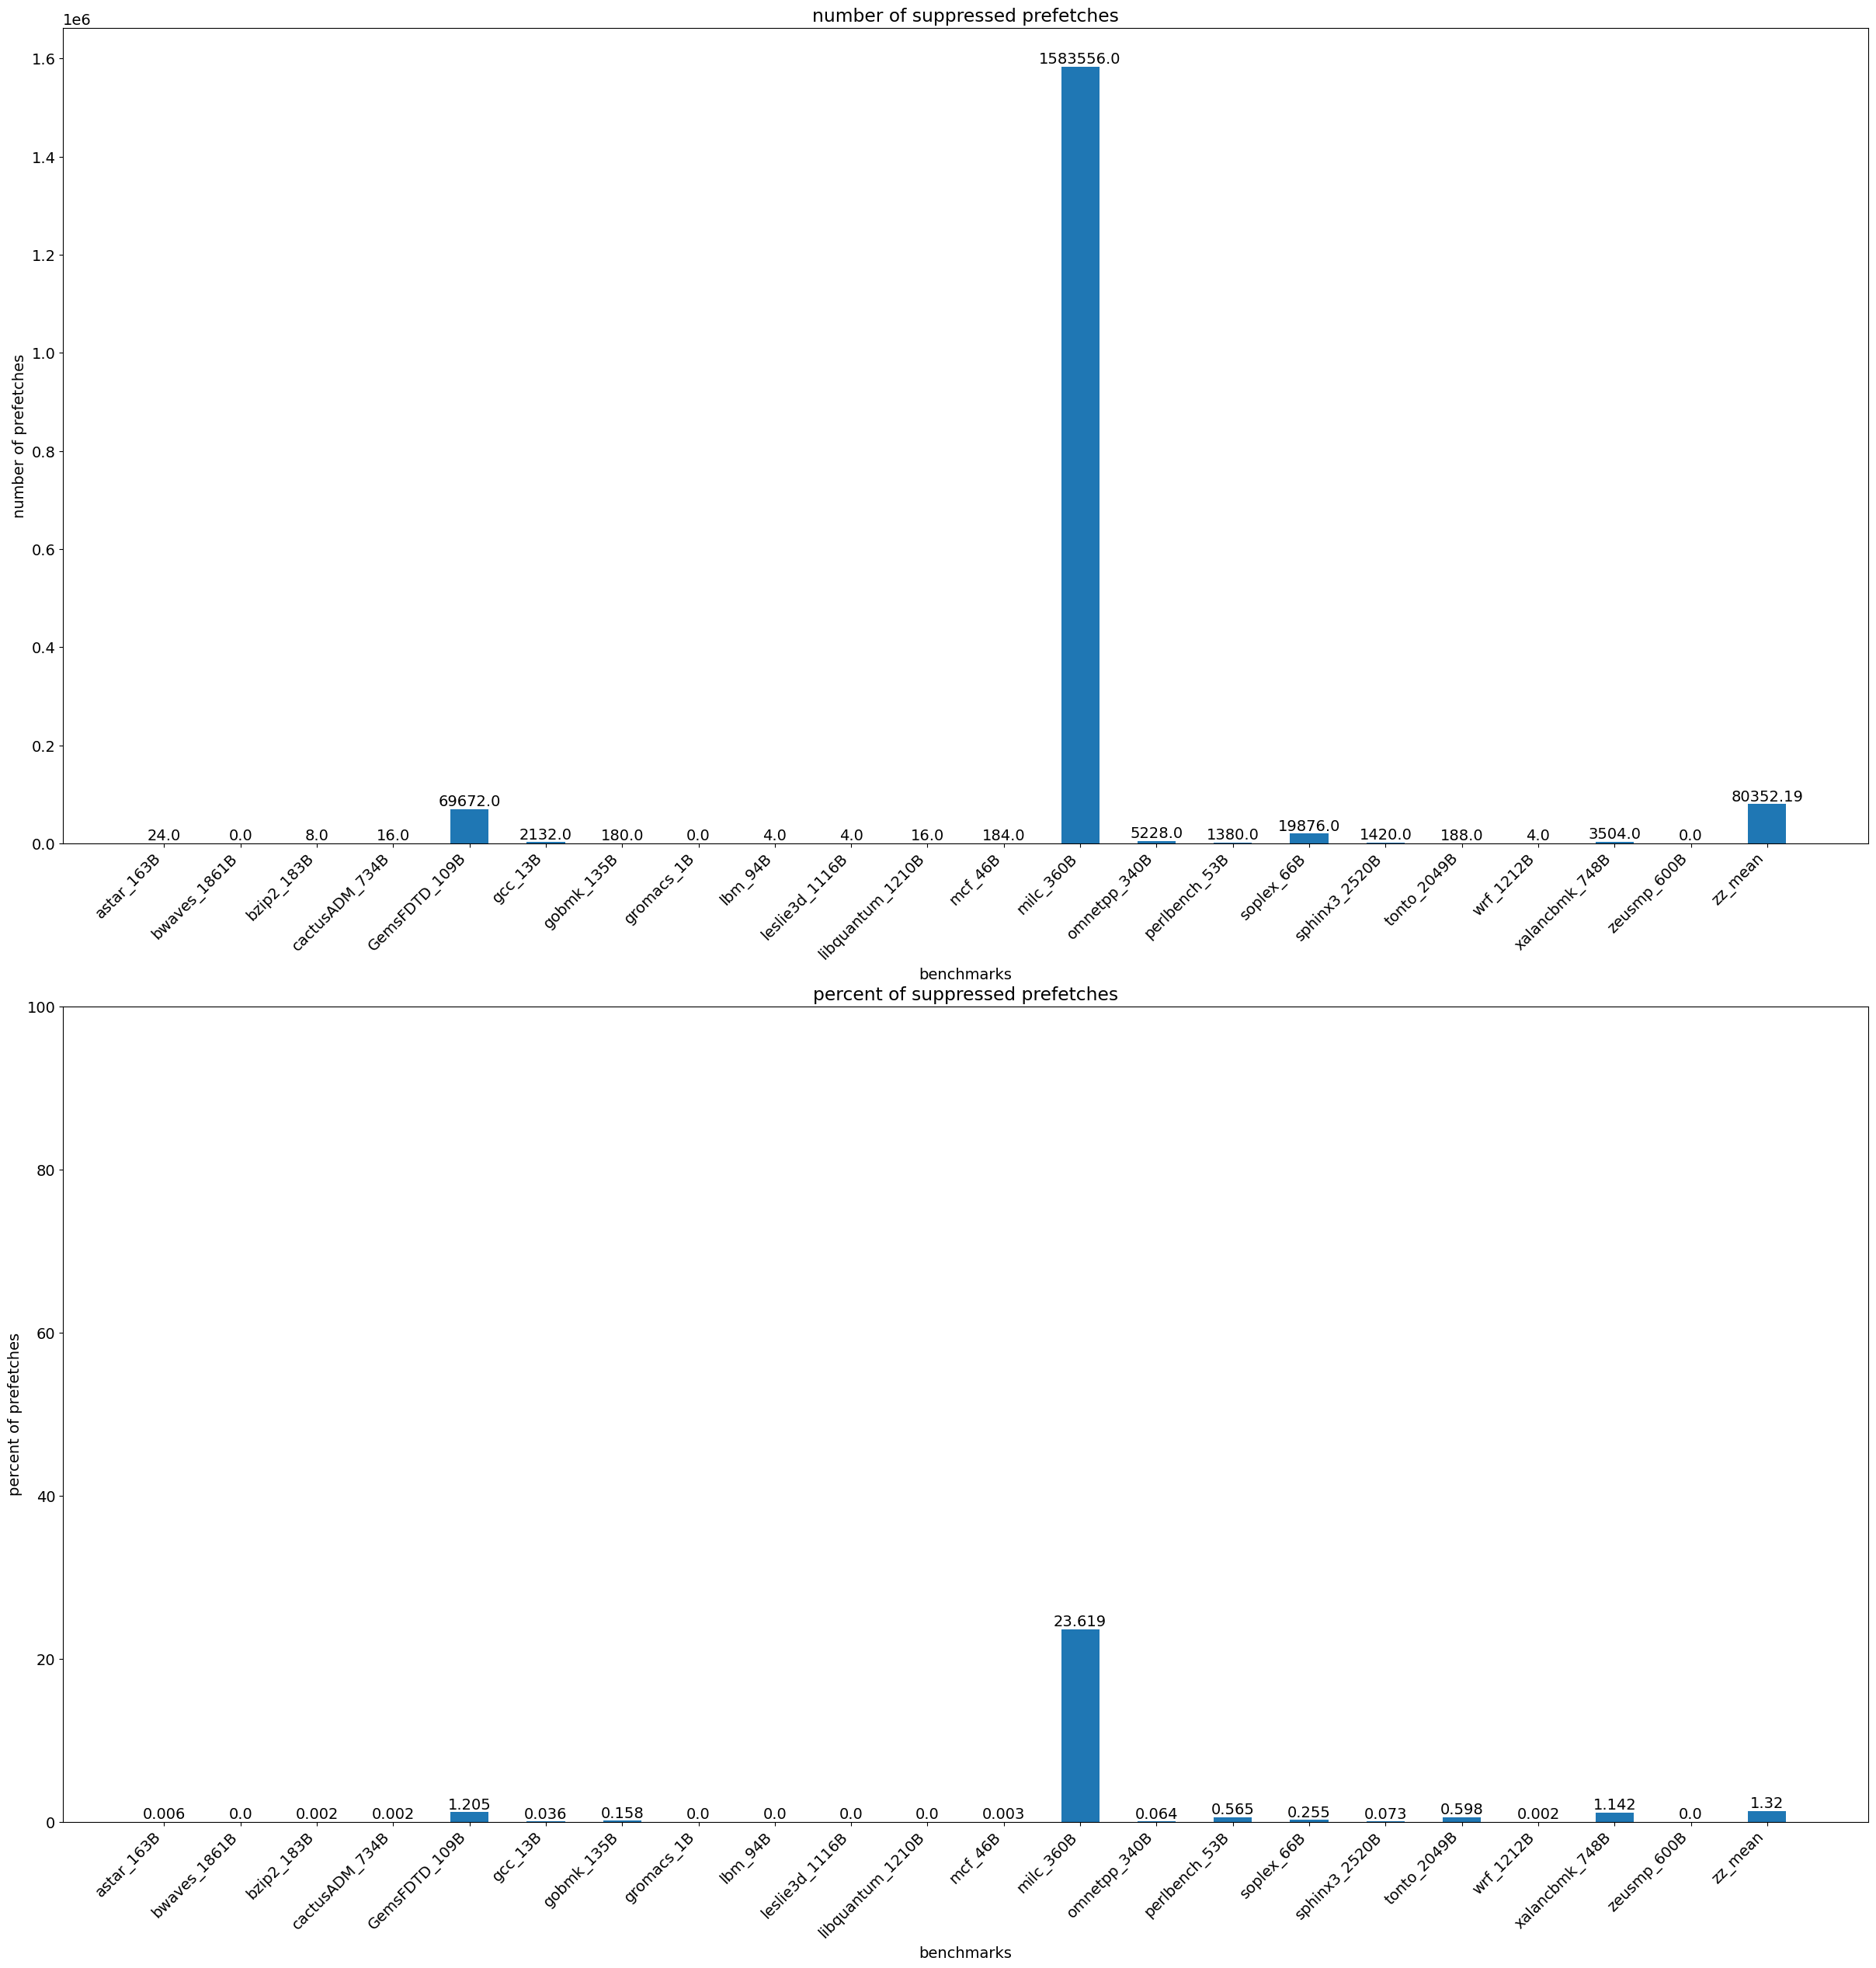

In [128]:
graph_prefetch_suppression_stats(comp_trace_files, traces, cmp_experiment)
plt.show()

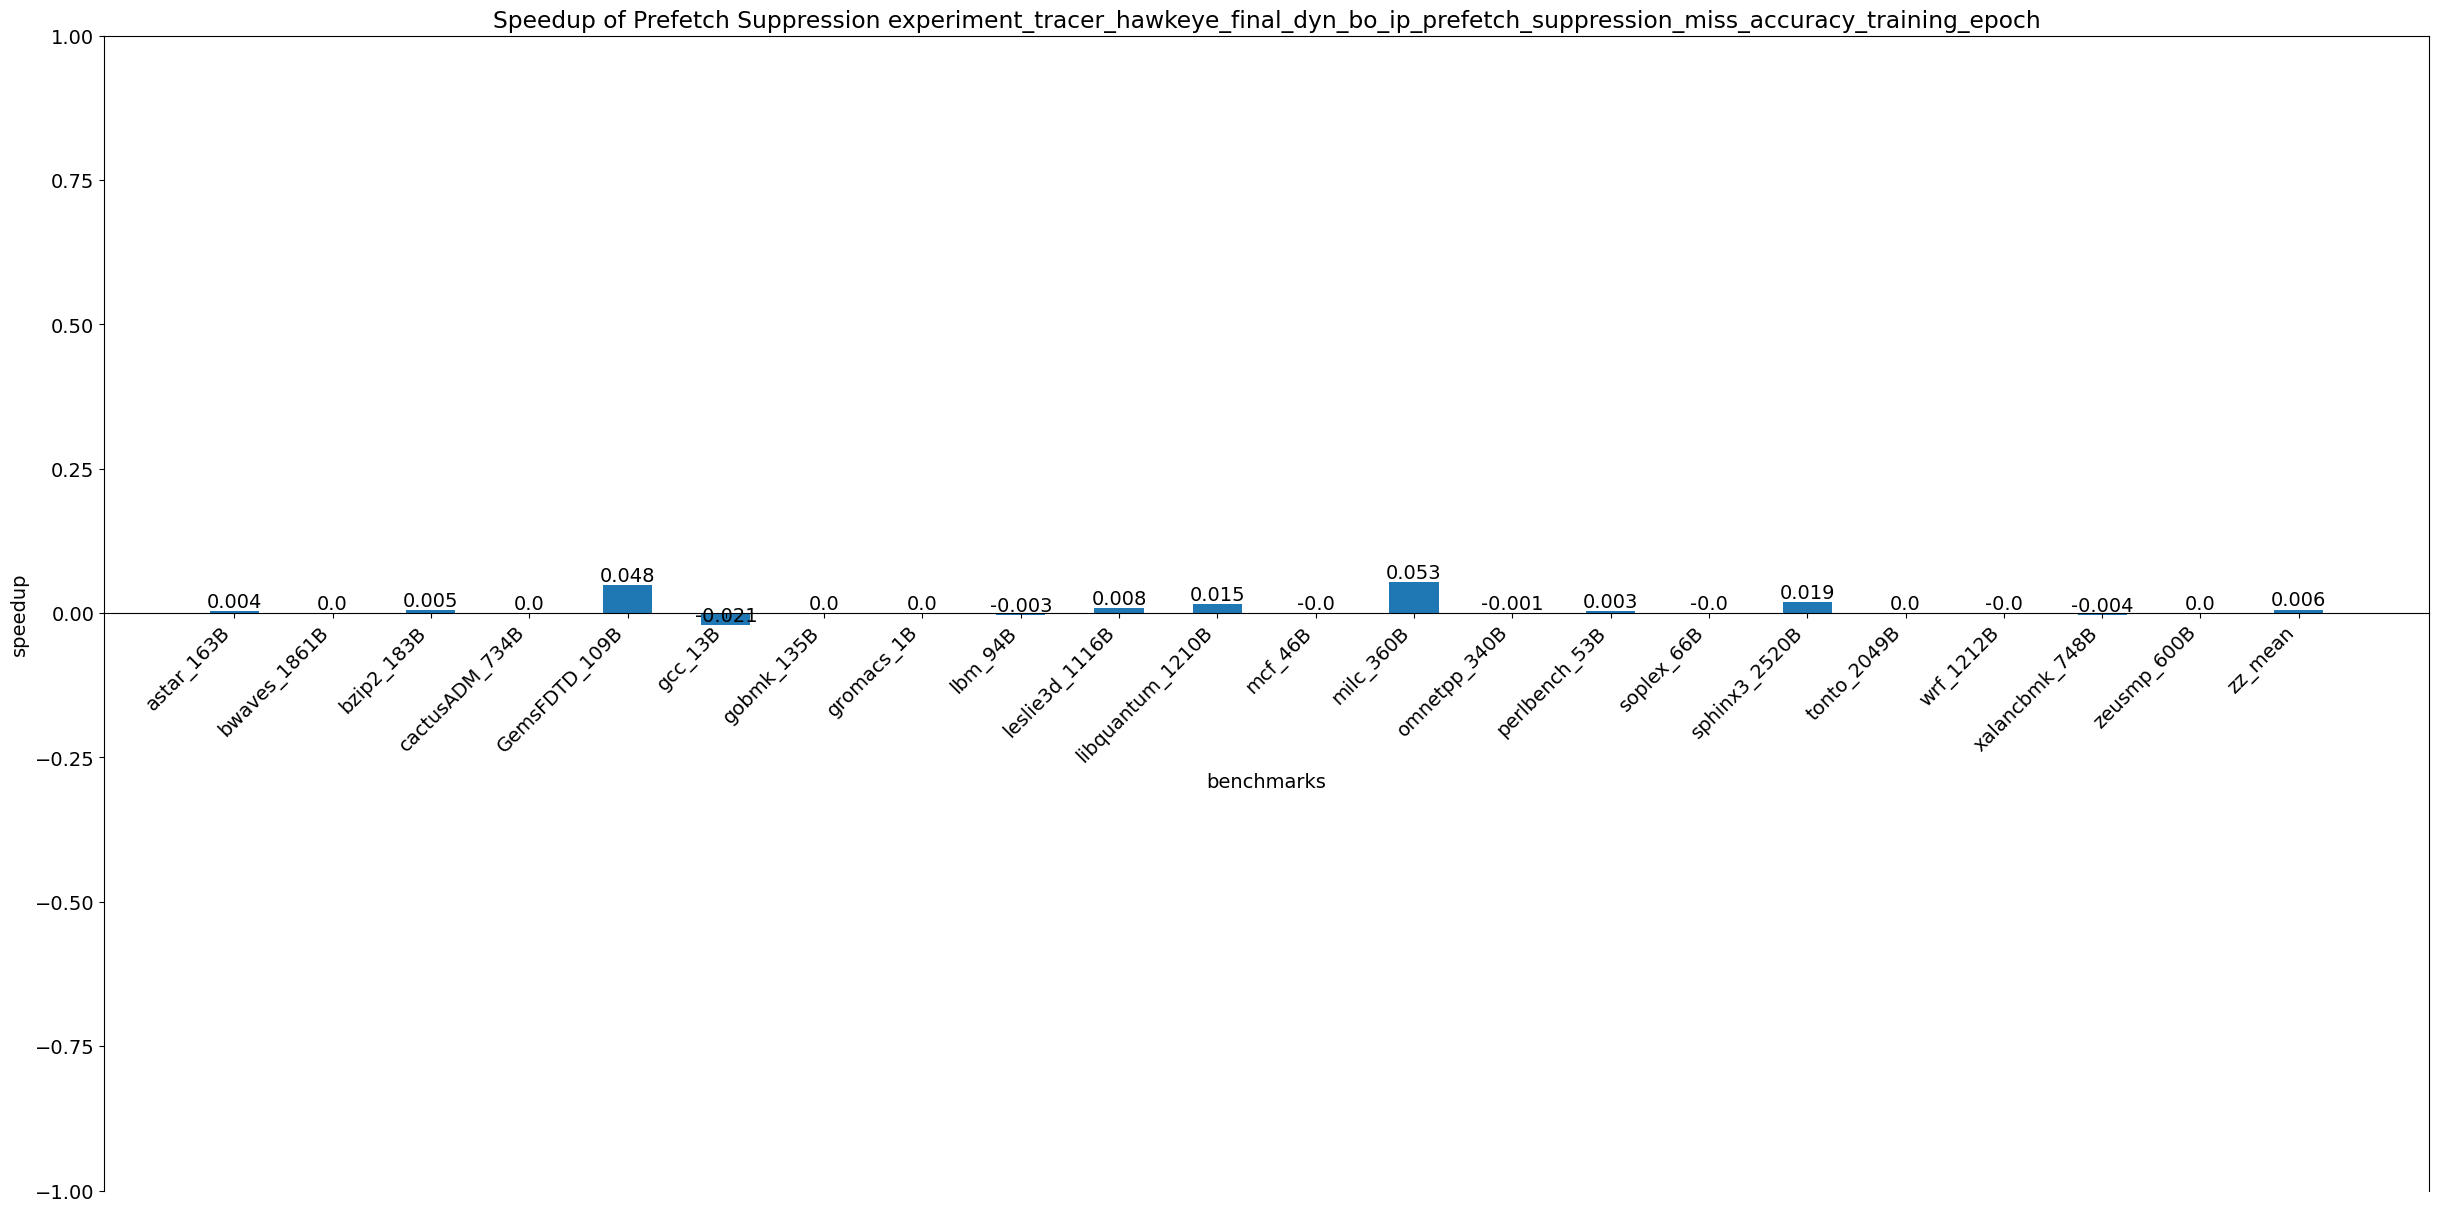

In [129]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

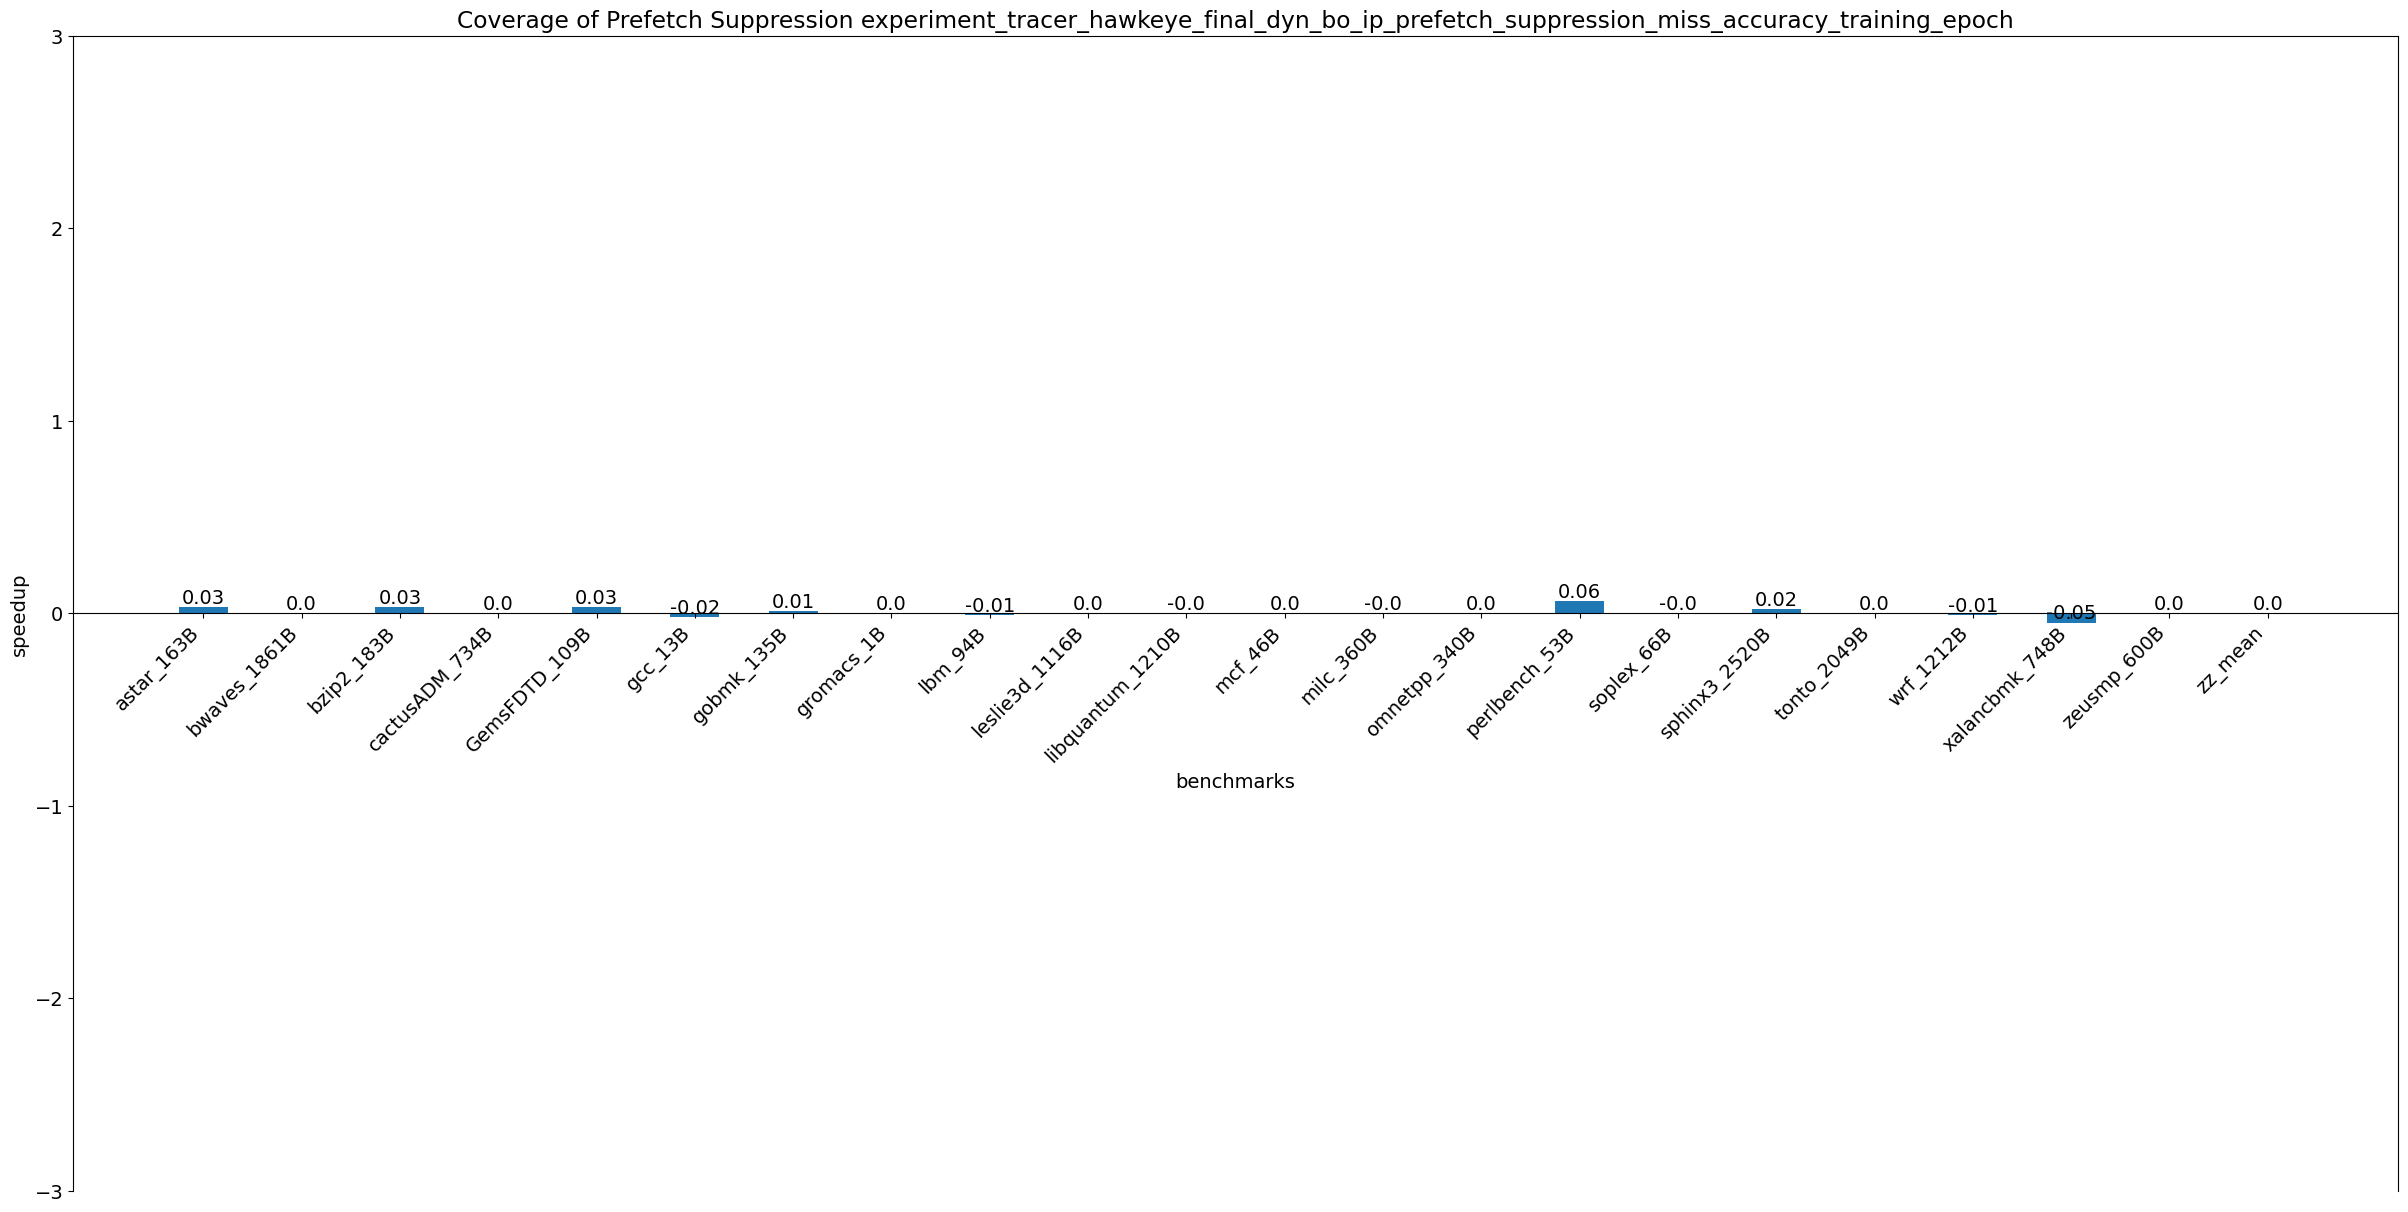

In [130]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [135]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_baseline_prefetch_suppress'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_ip_prefetch_suppression_miss_accuracy_training_epoch_25_length'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

### Harmony with BO Prefetch Suppression with 25% training length, 0.00 accuracy threshold

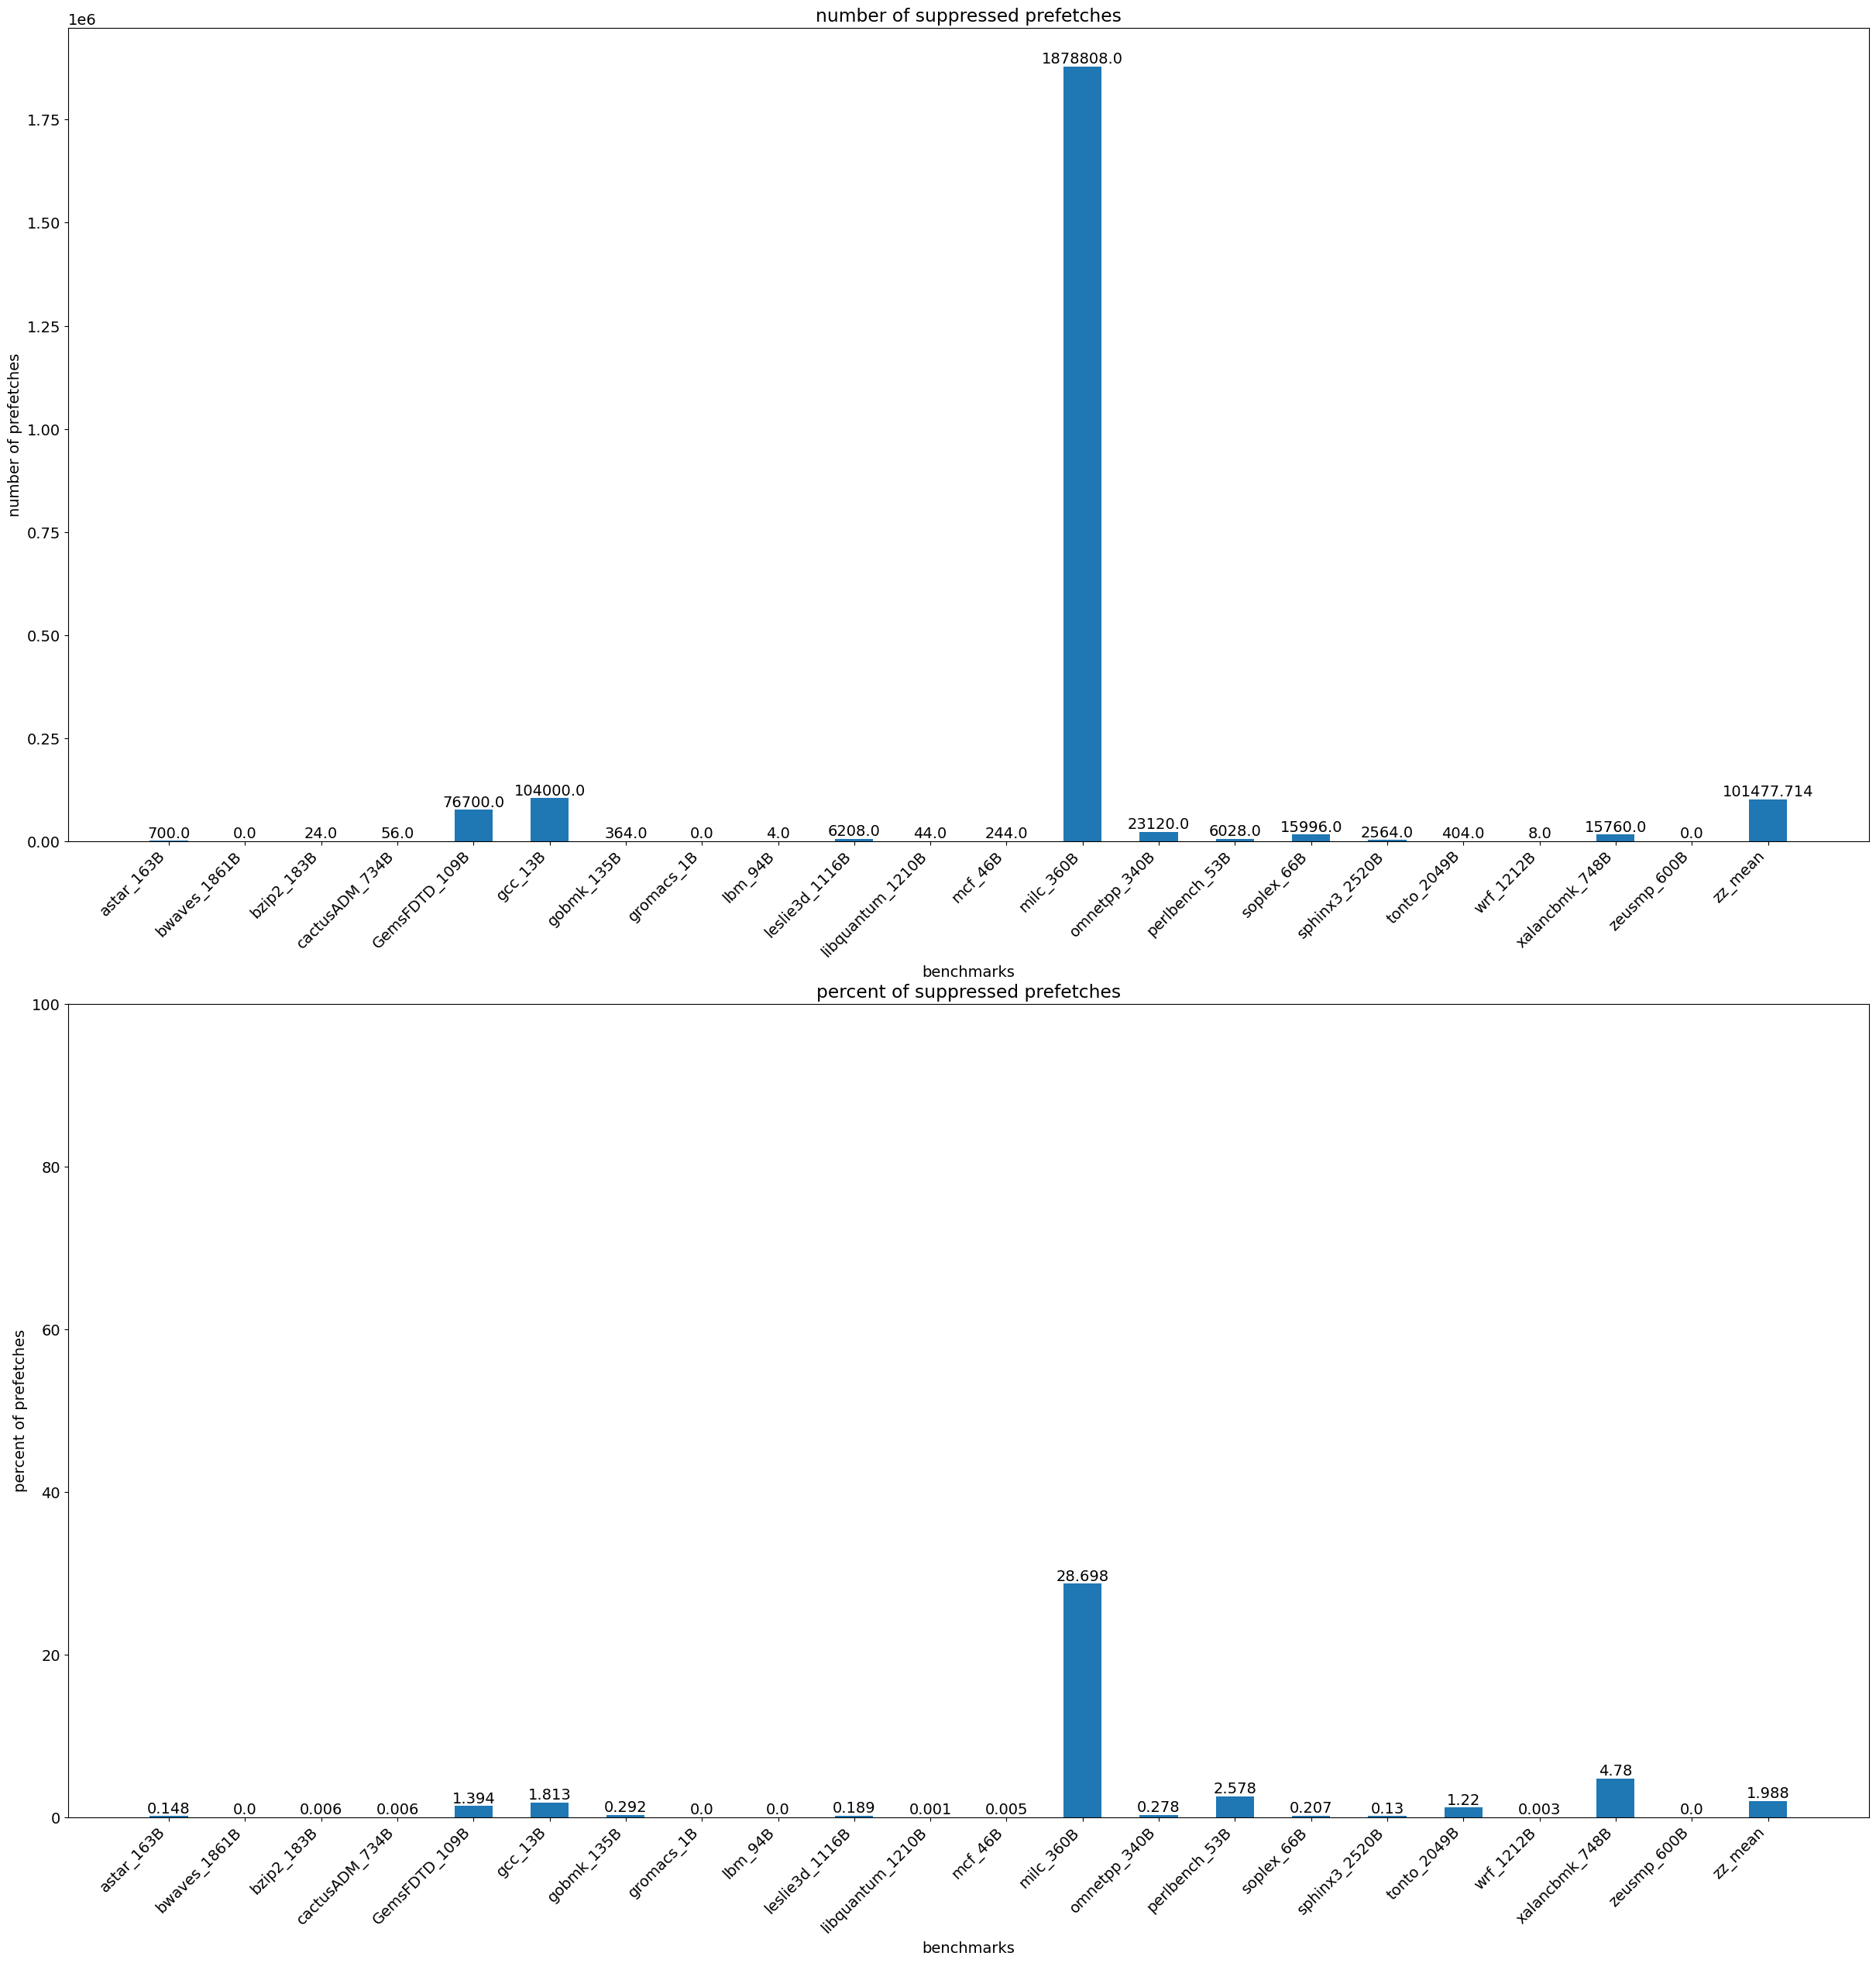

In [136]:
graph_prefetch_suppression_stats(comp_trace_files, traces, cmp_experiment)
plt.show()

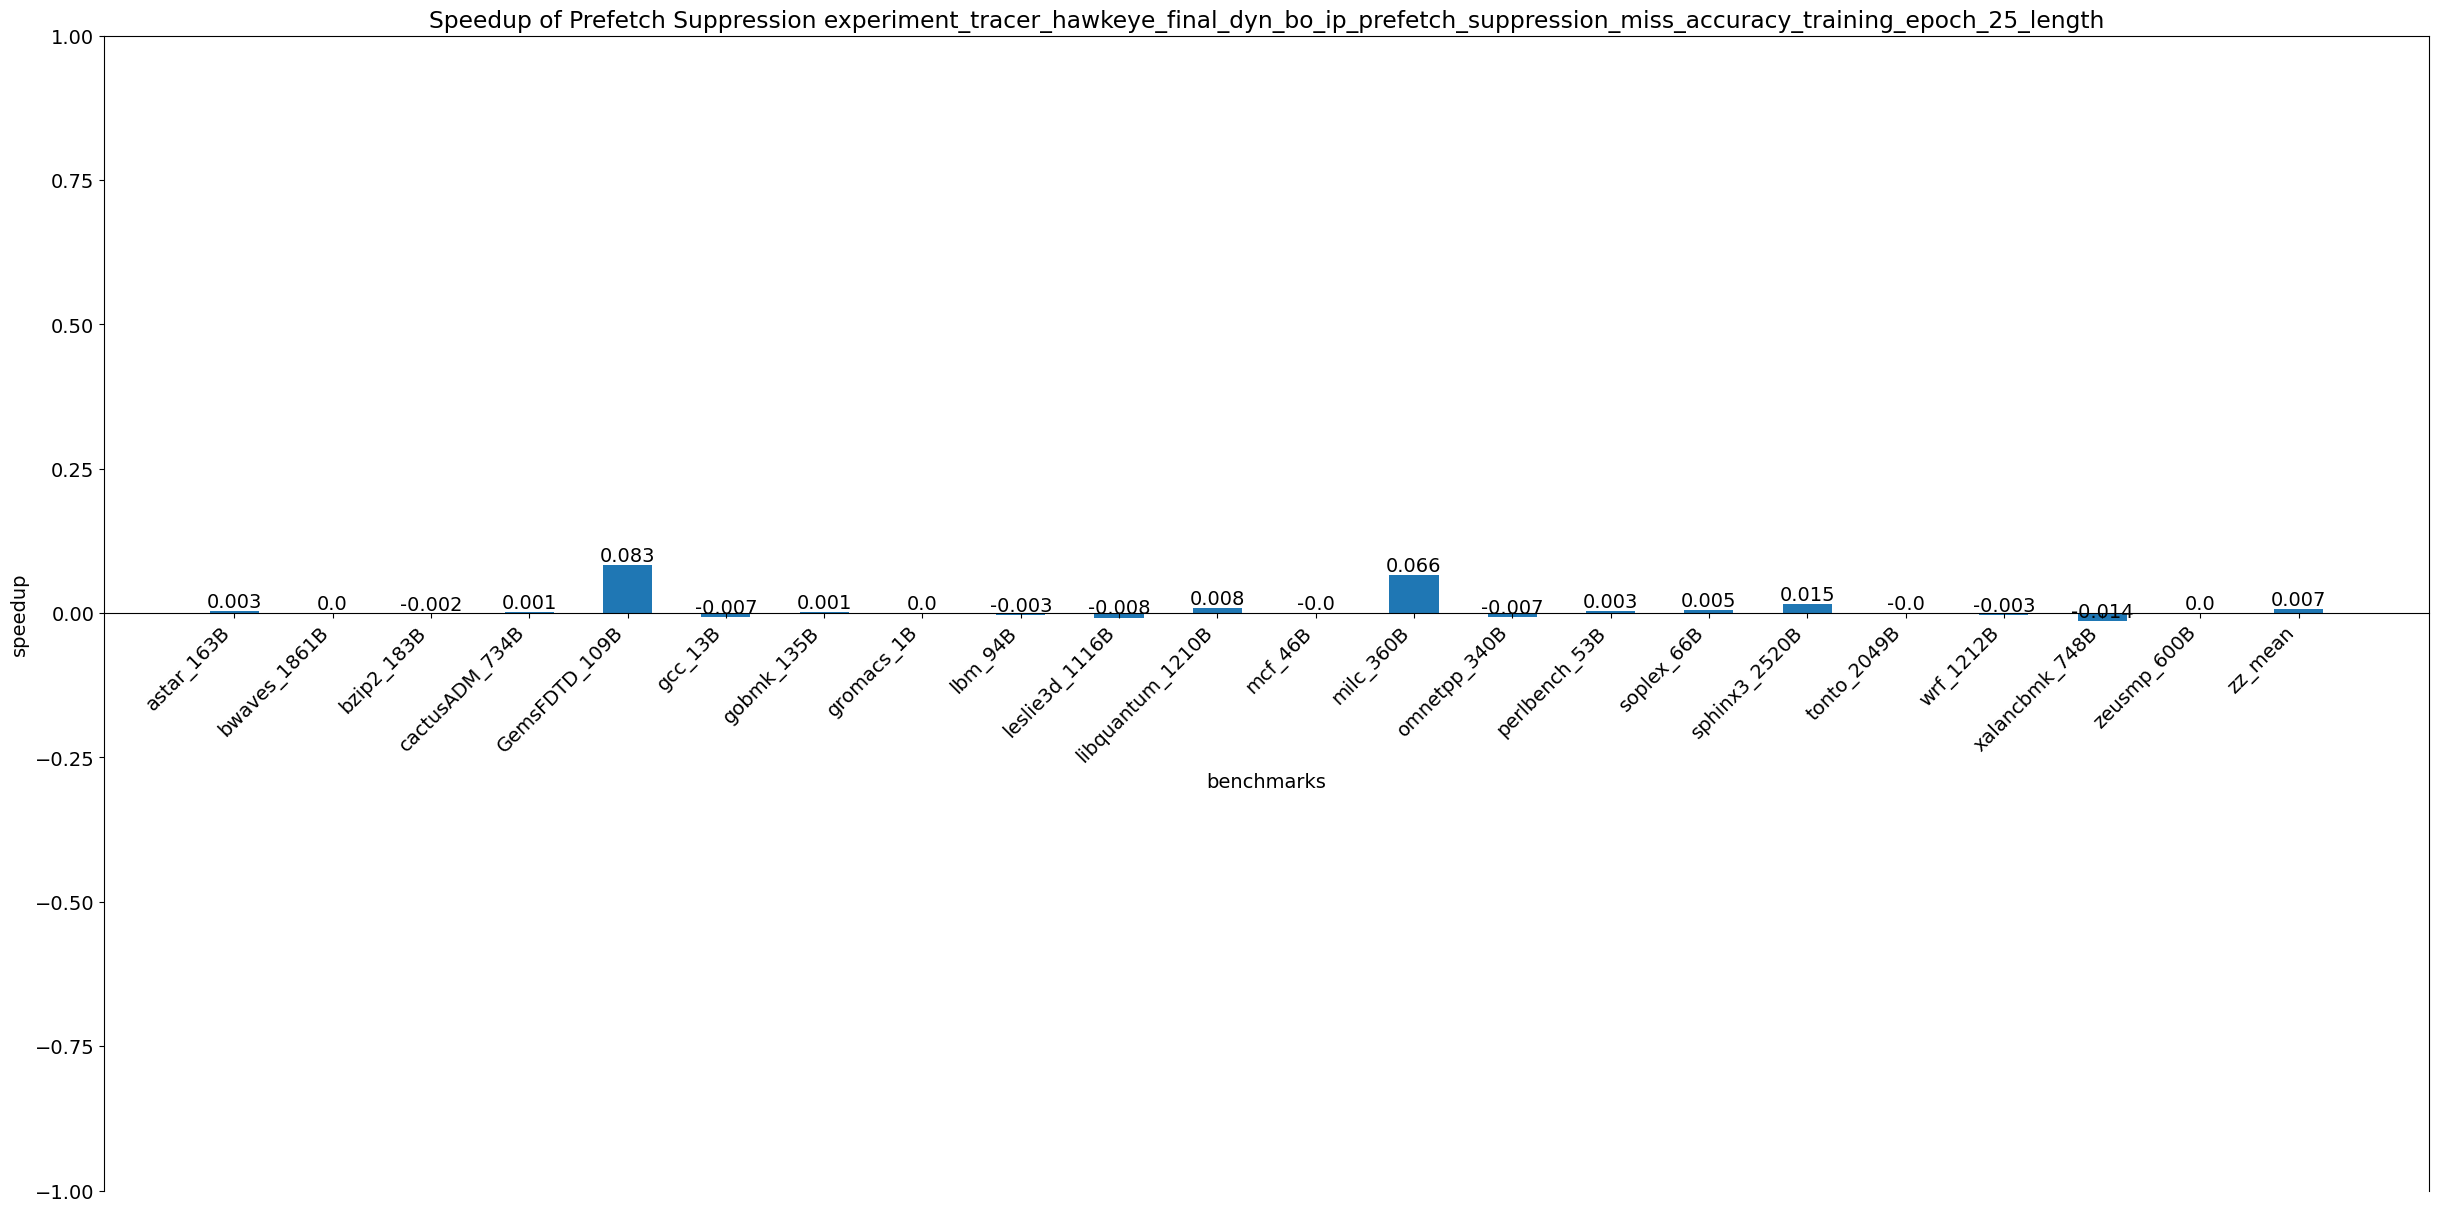

In [137]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

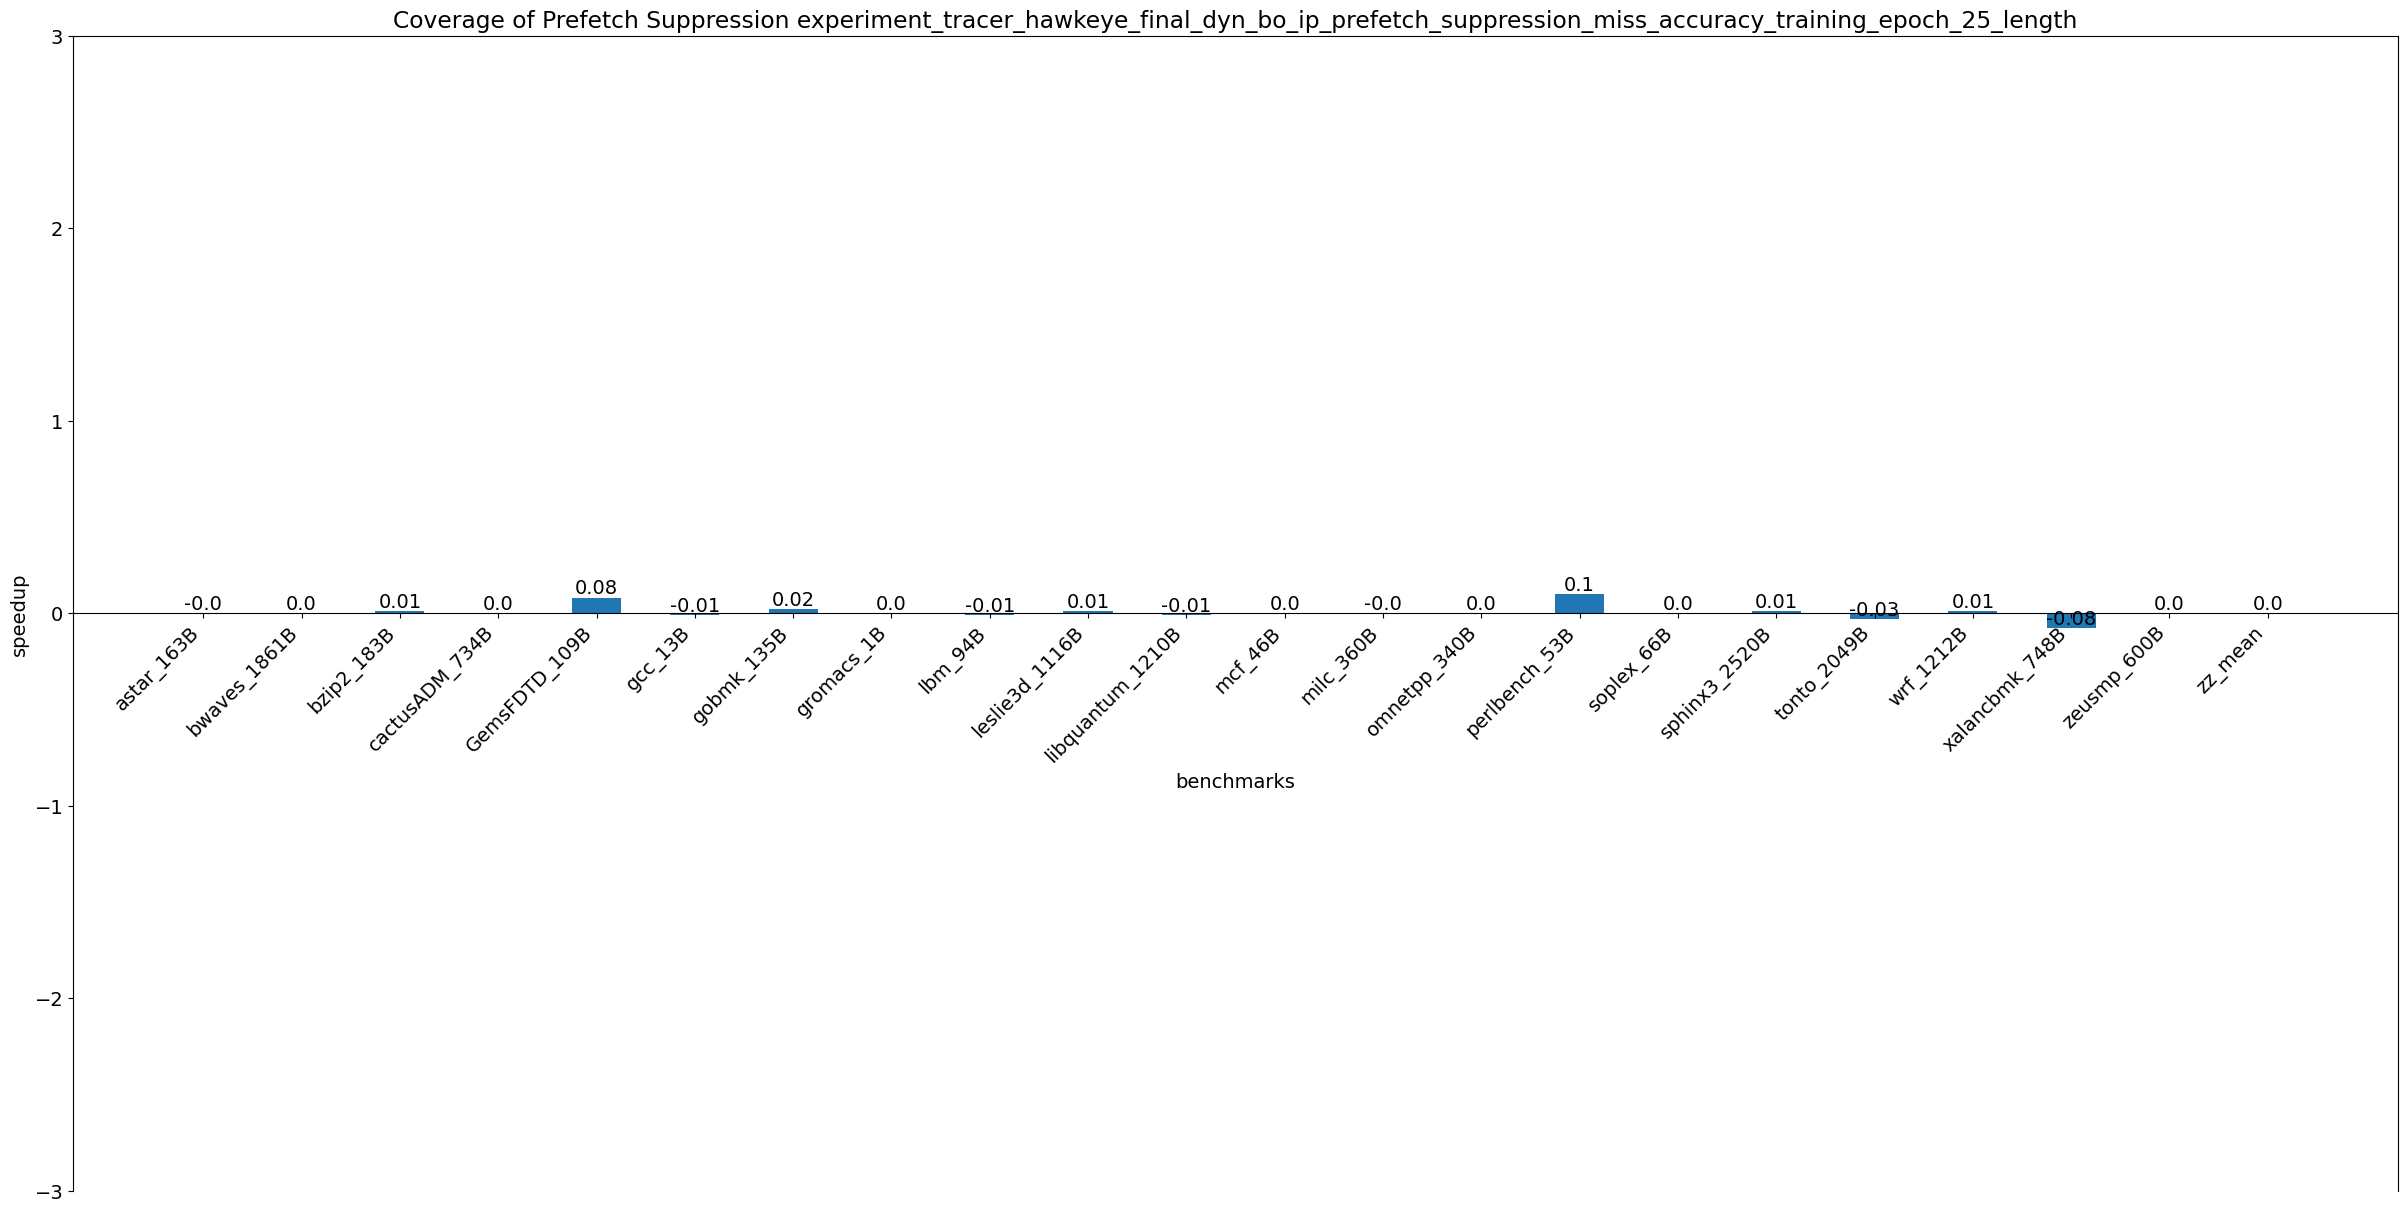

In [138]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [144]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_baseline_prefetch_suppress'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_ip_prefetch_suppression_miss_accuracy_training_epoch_50_length_005_threshold'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

### Harmony with BO Prefetch Suppression with 50% training length, 0.005 accuracy threshold

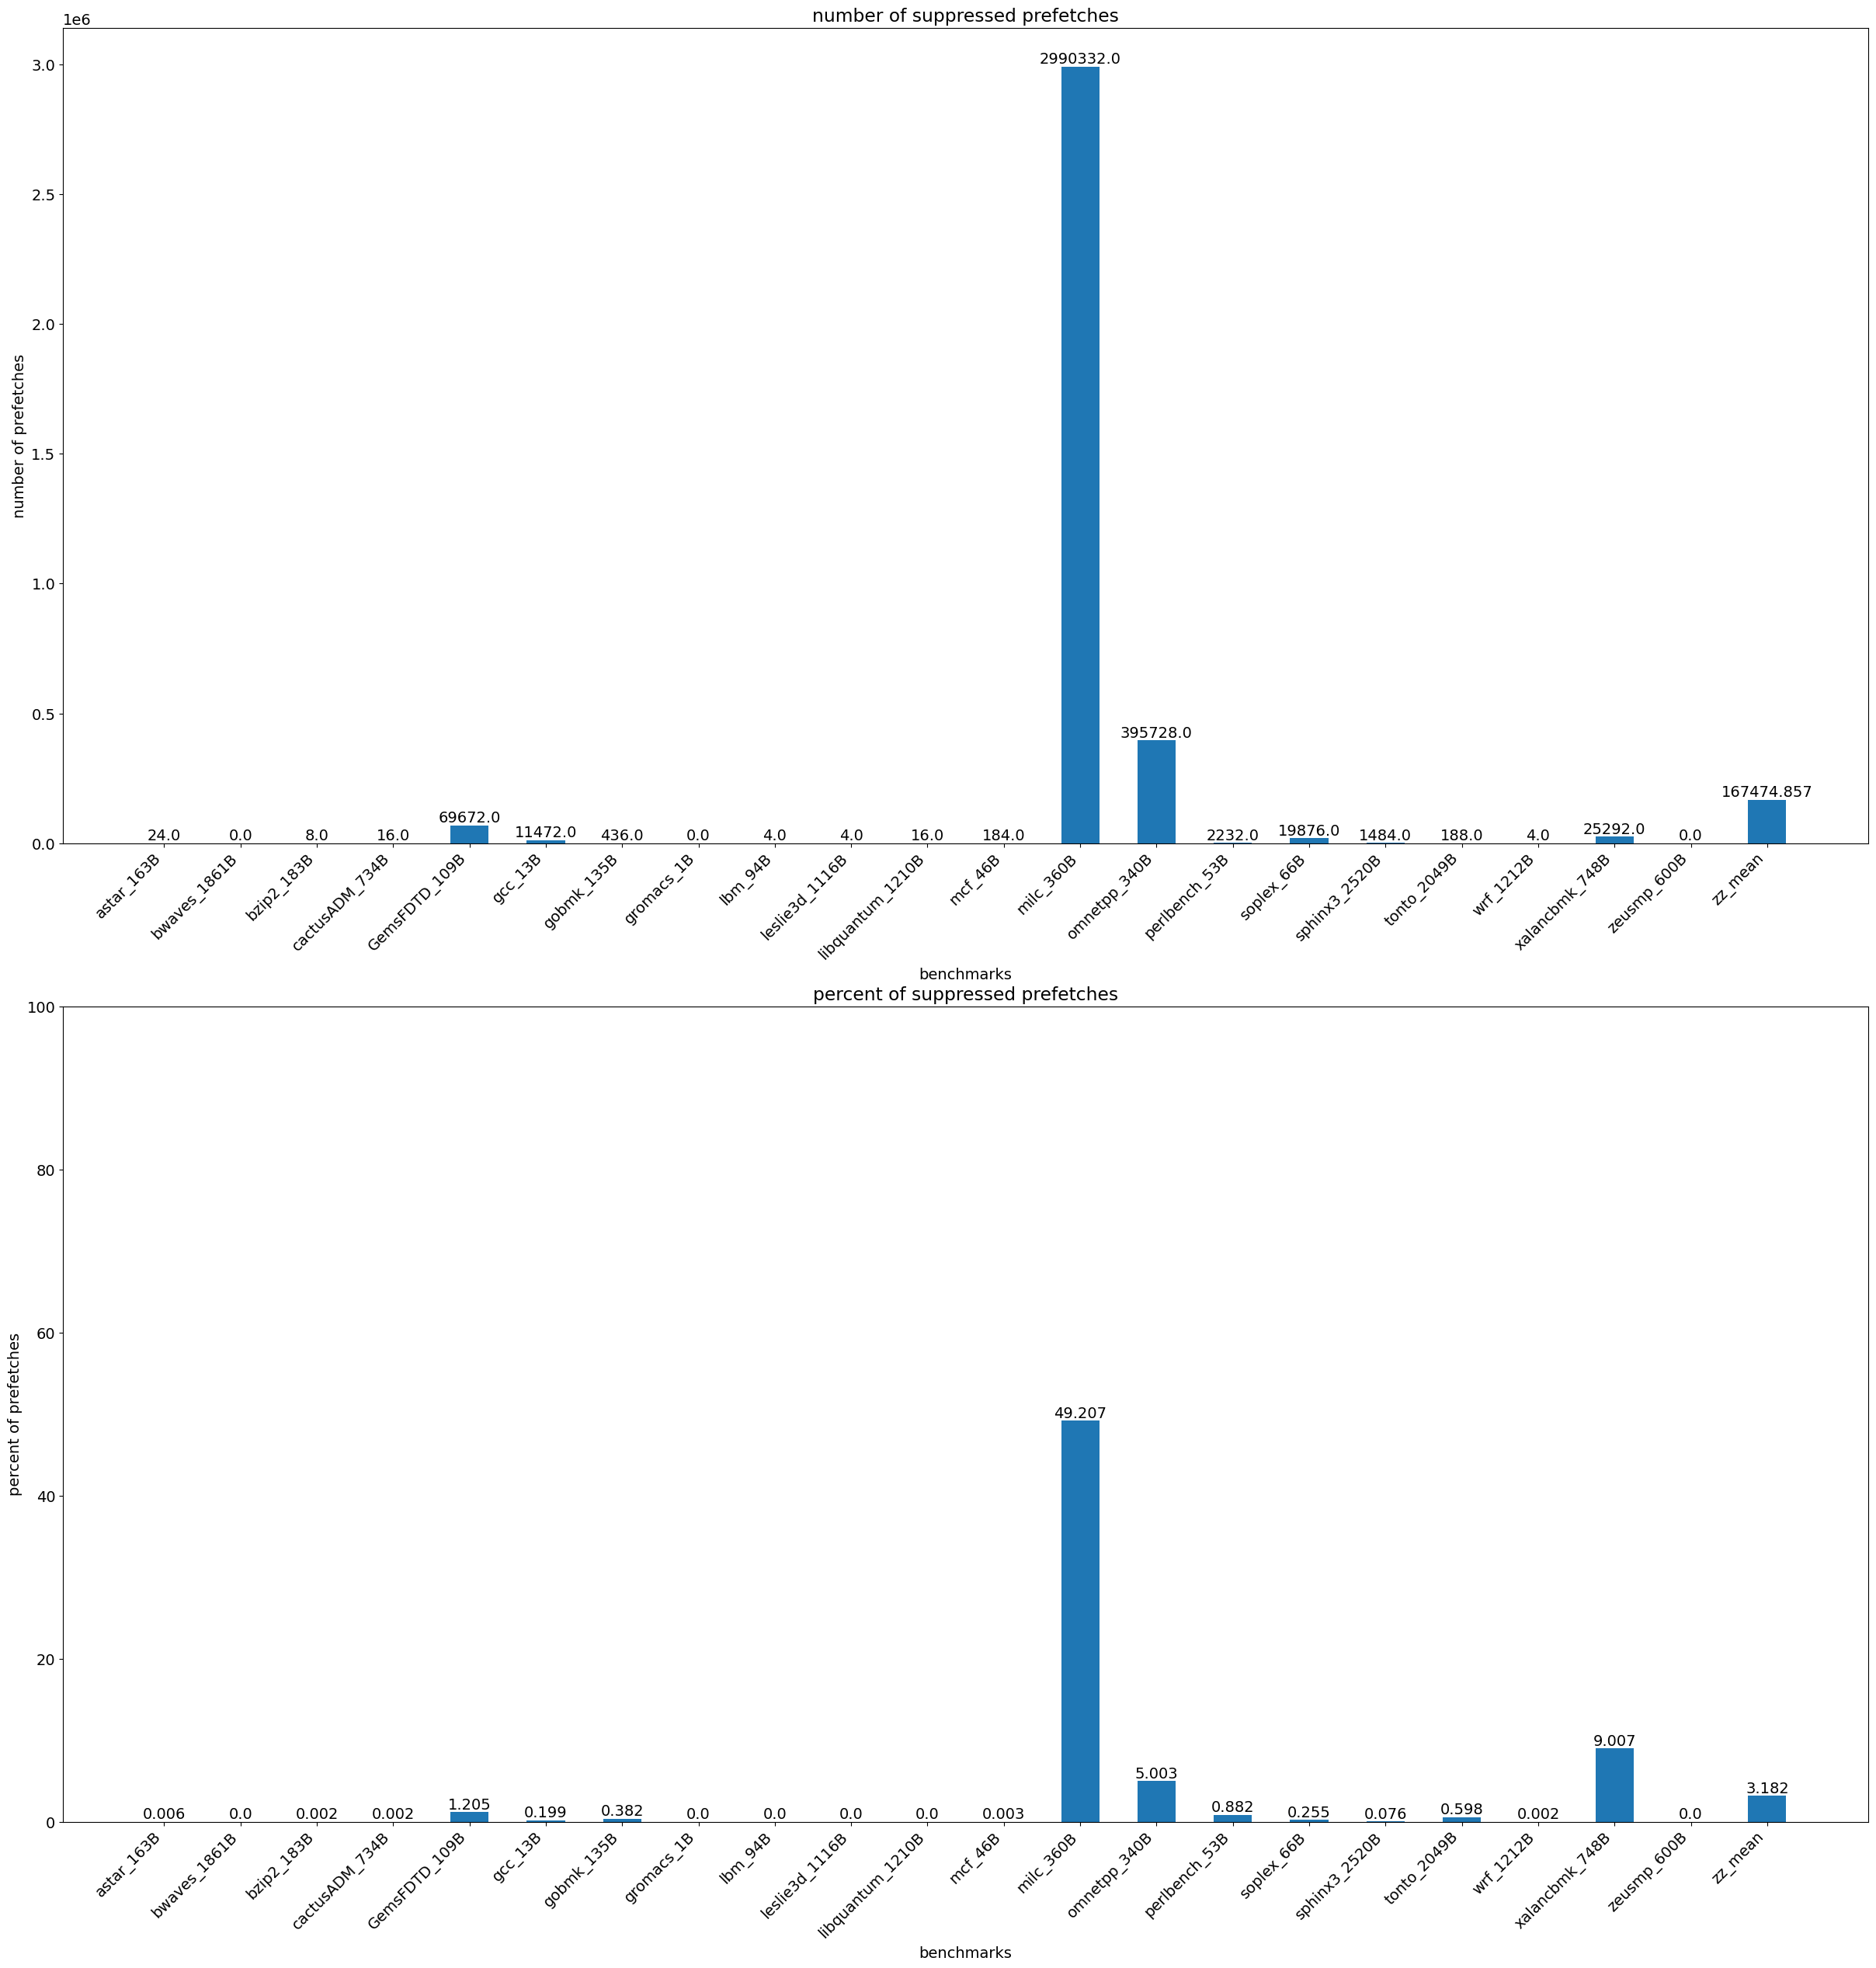

In [145]:
graph_prefetch_suppression_stats(comp_trace_files, traces, cmp_experiment)
plt.show()

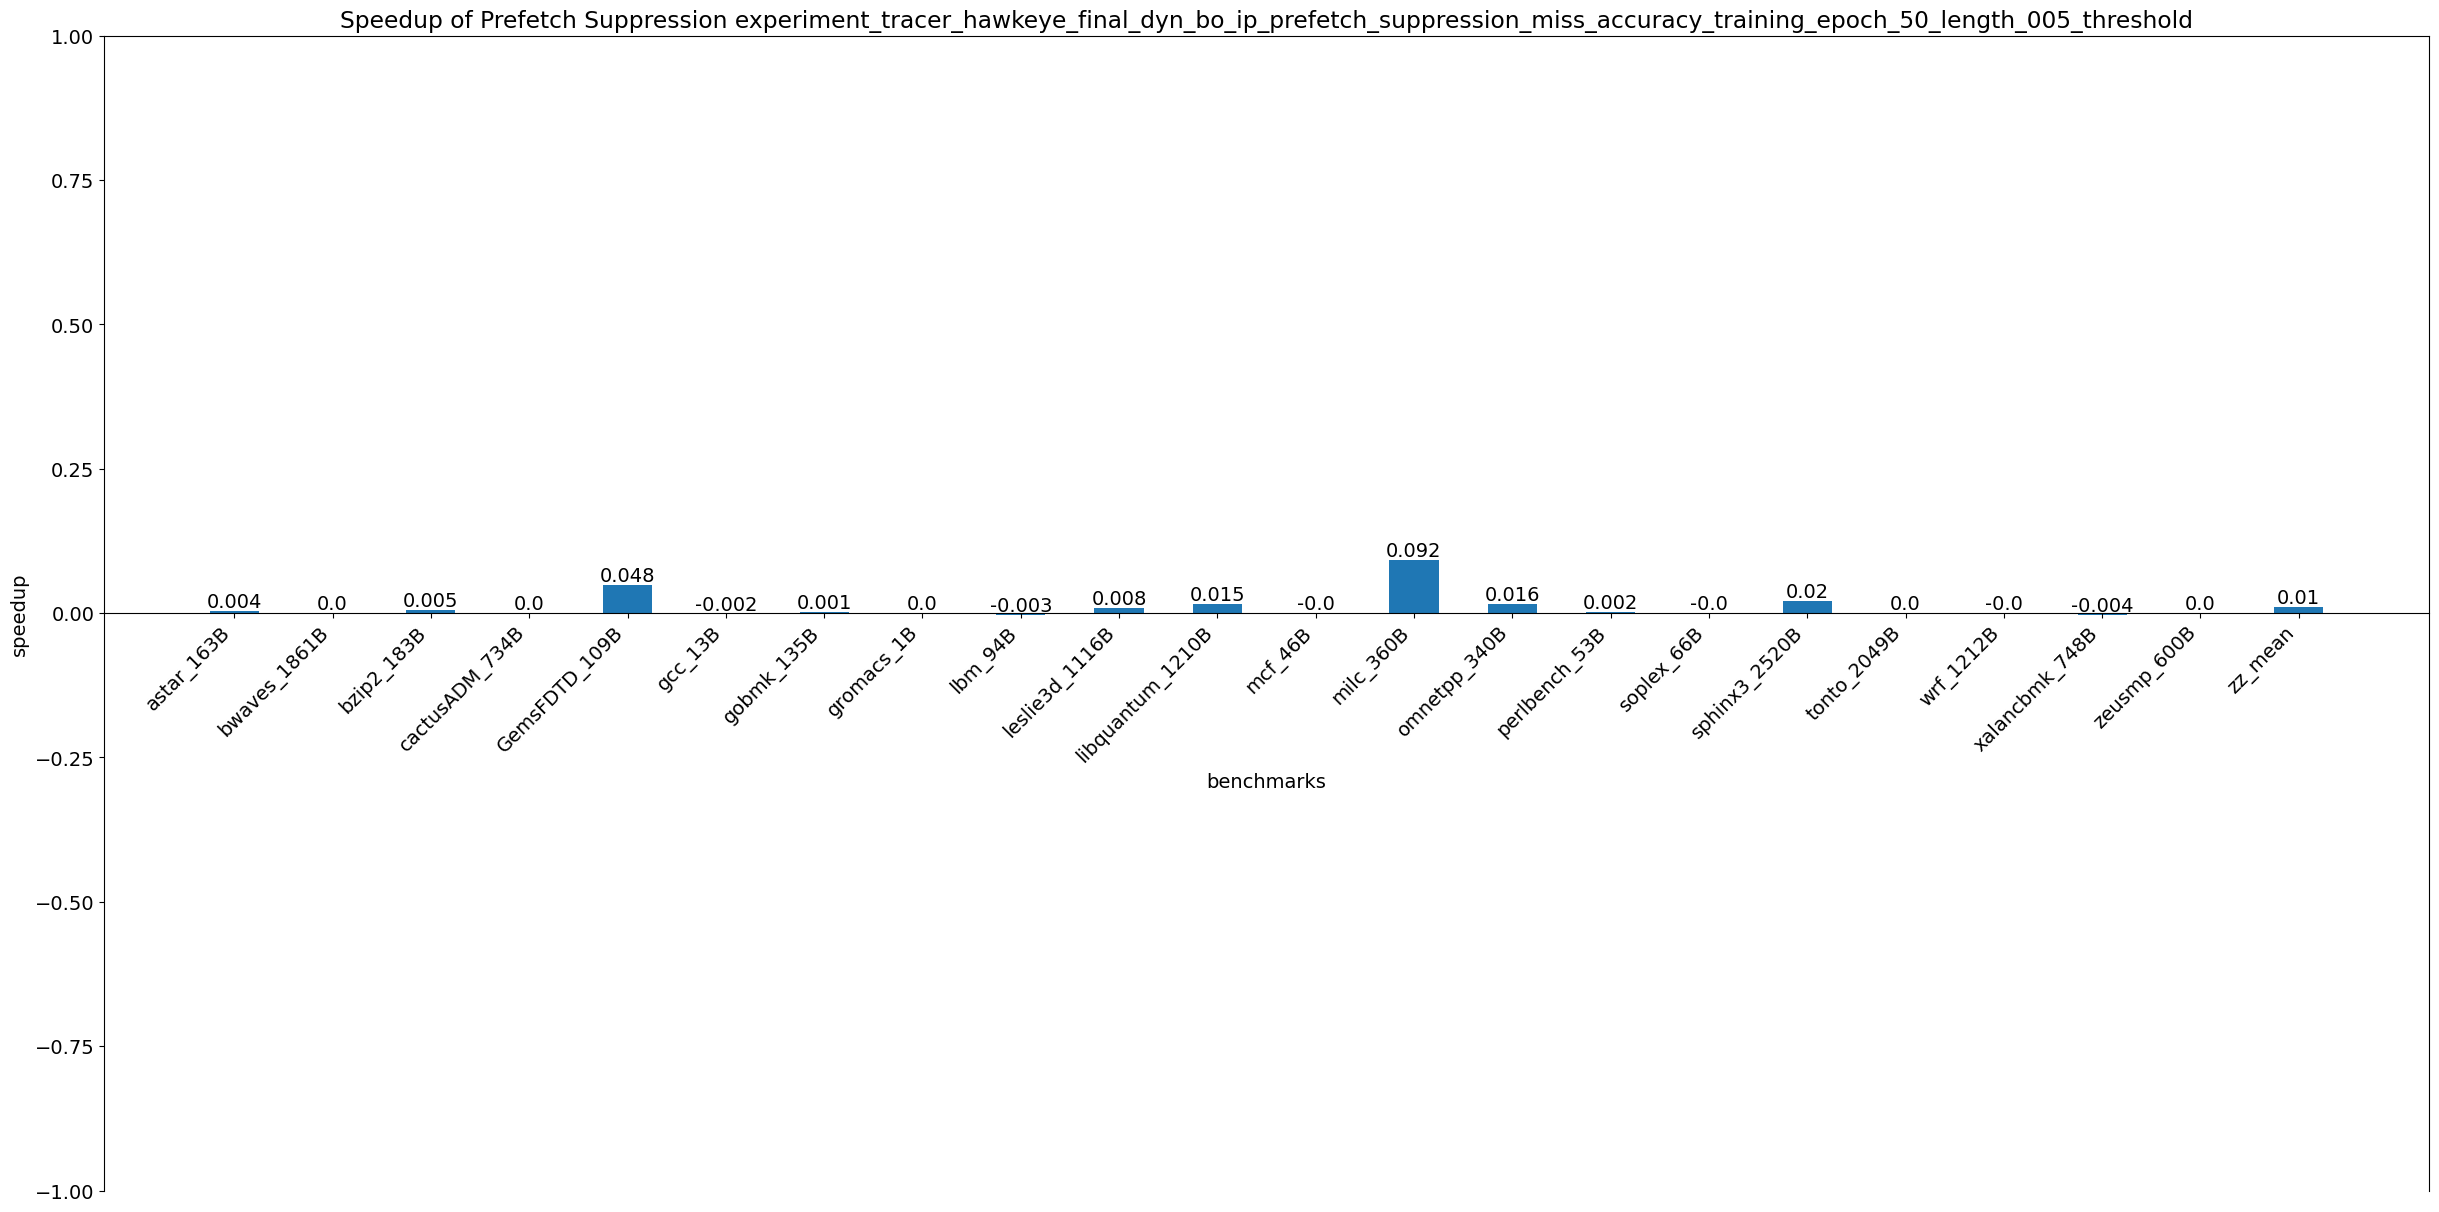

In [146]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

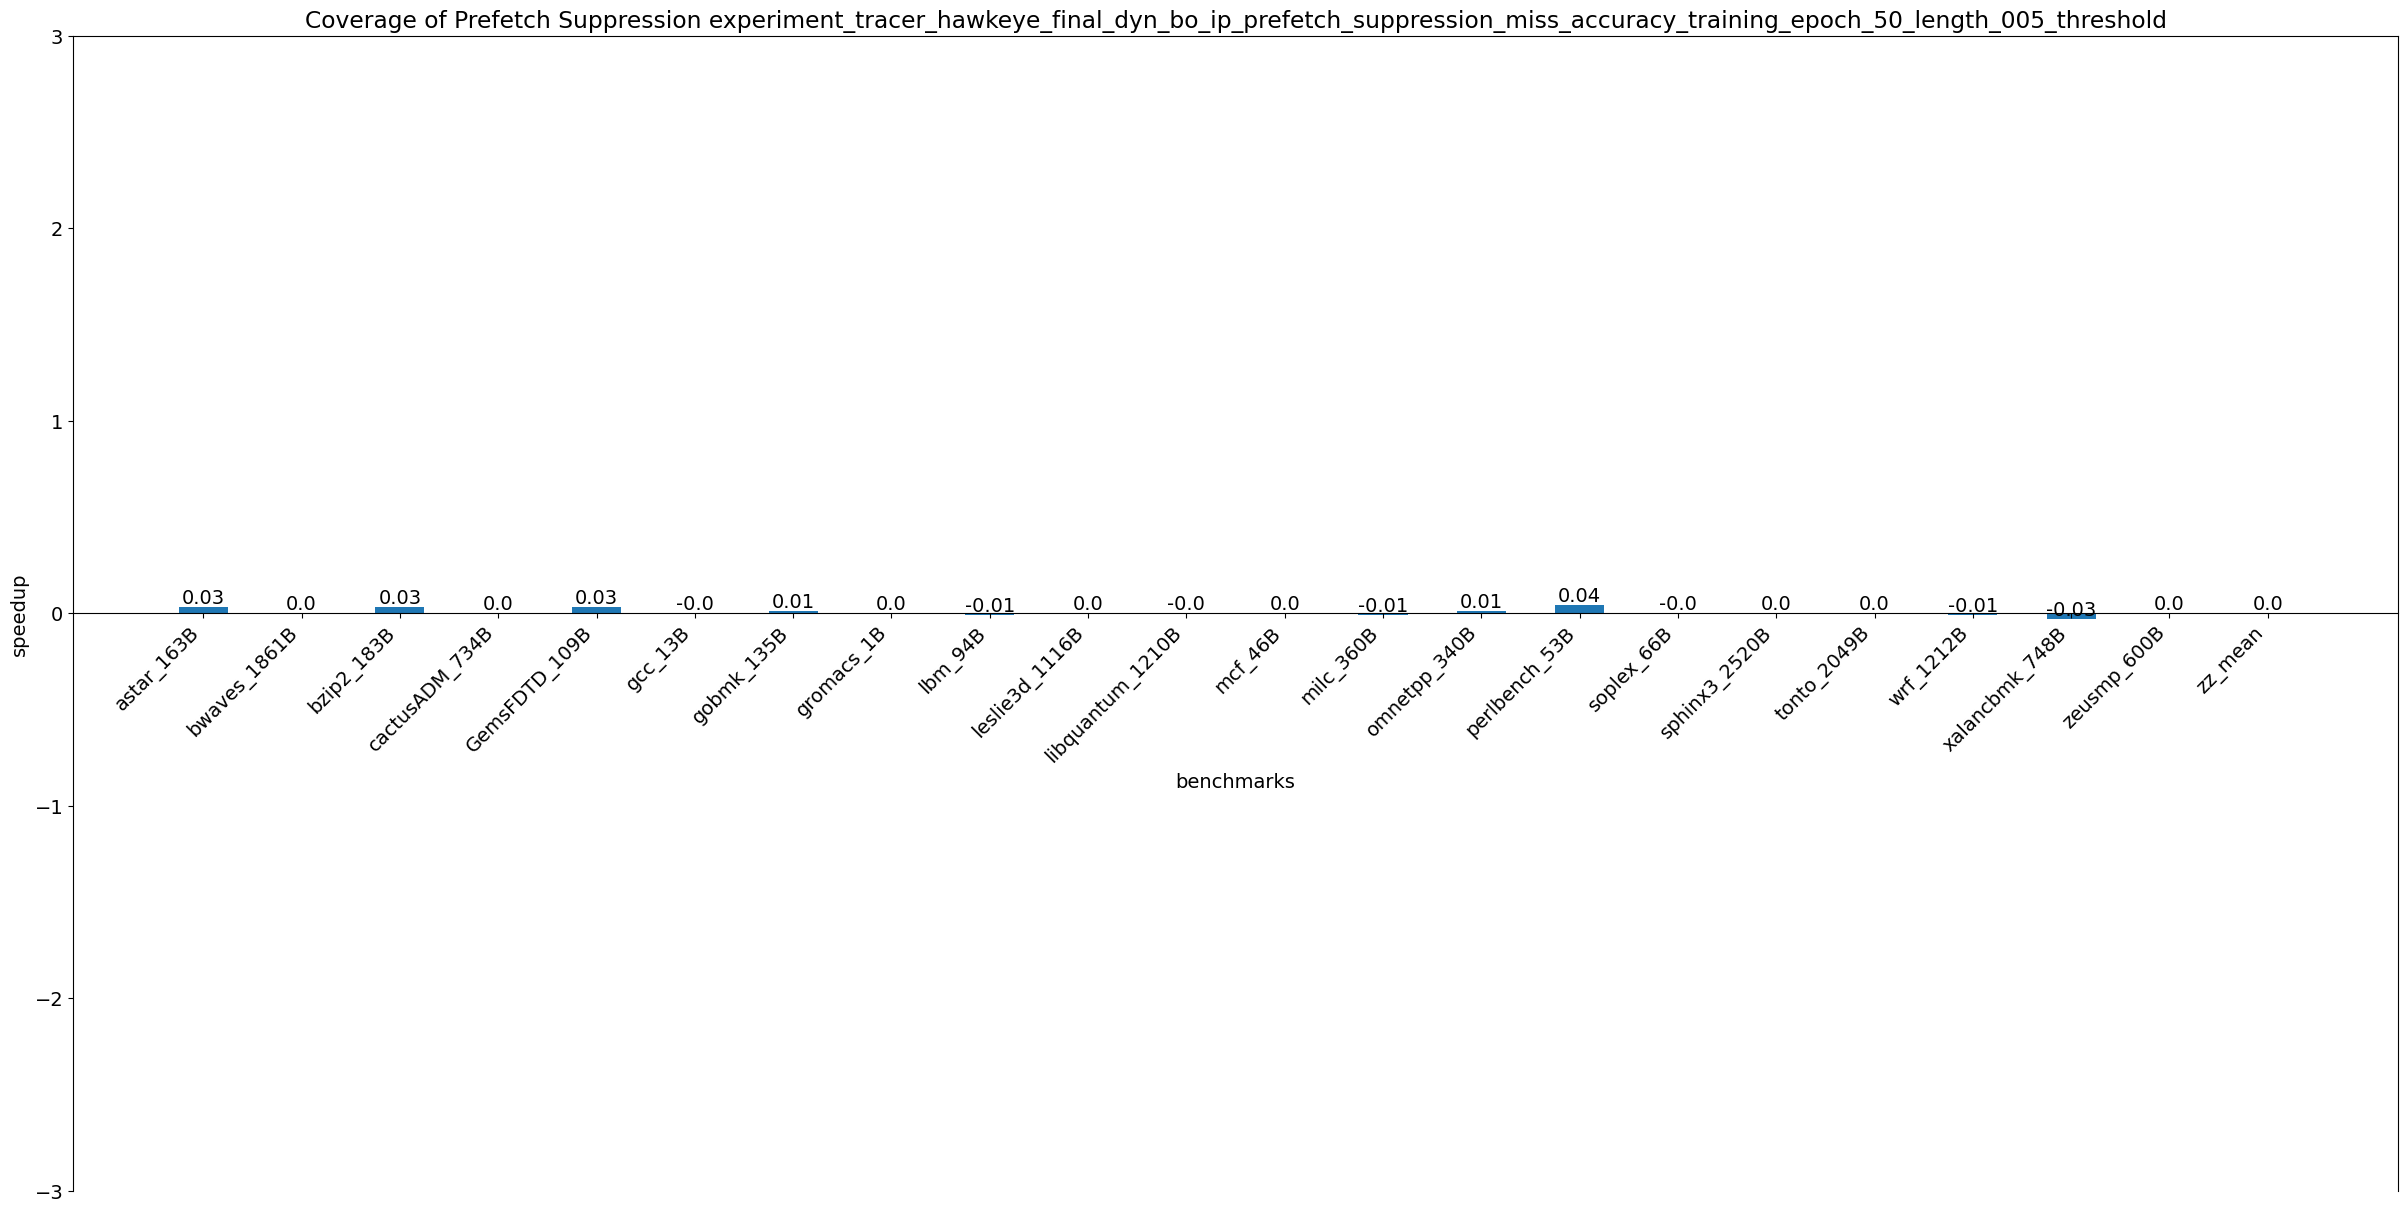

In [147]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [169]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_baseline_prefetch_suppress'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_ip_prefetch_suppression_miss_accuracy_training_epoch_25_length_005_threshold'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

### Harmony with BO Prefetch Suppression with 25% training length, 0.005 accuracy threshold

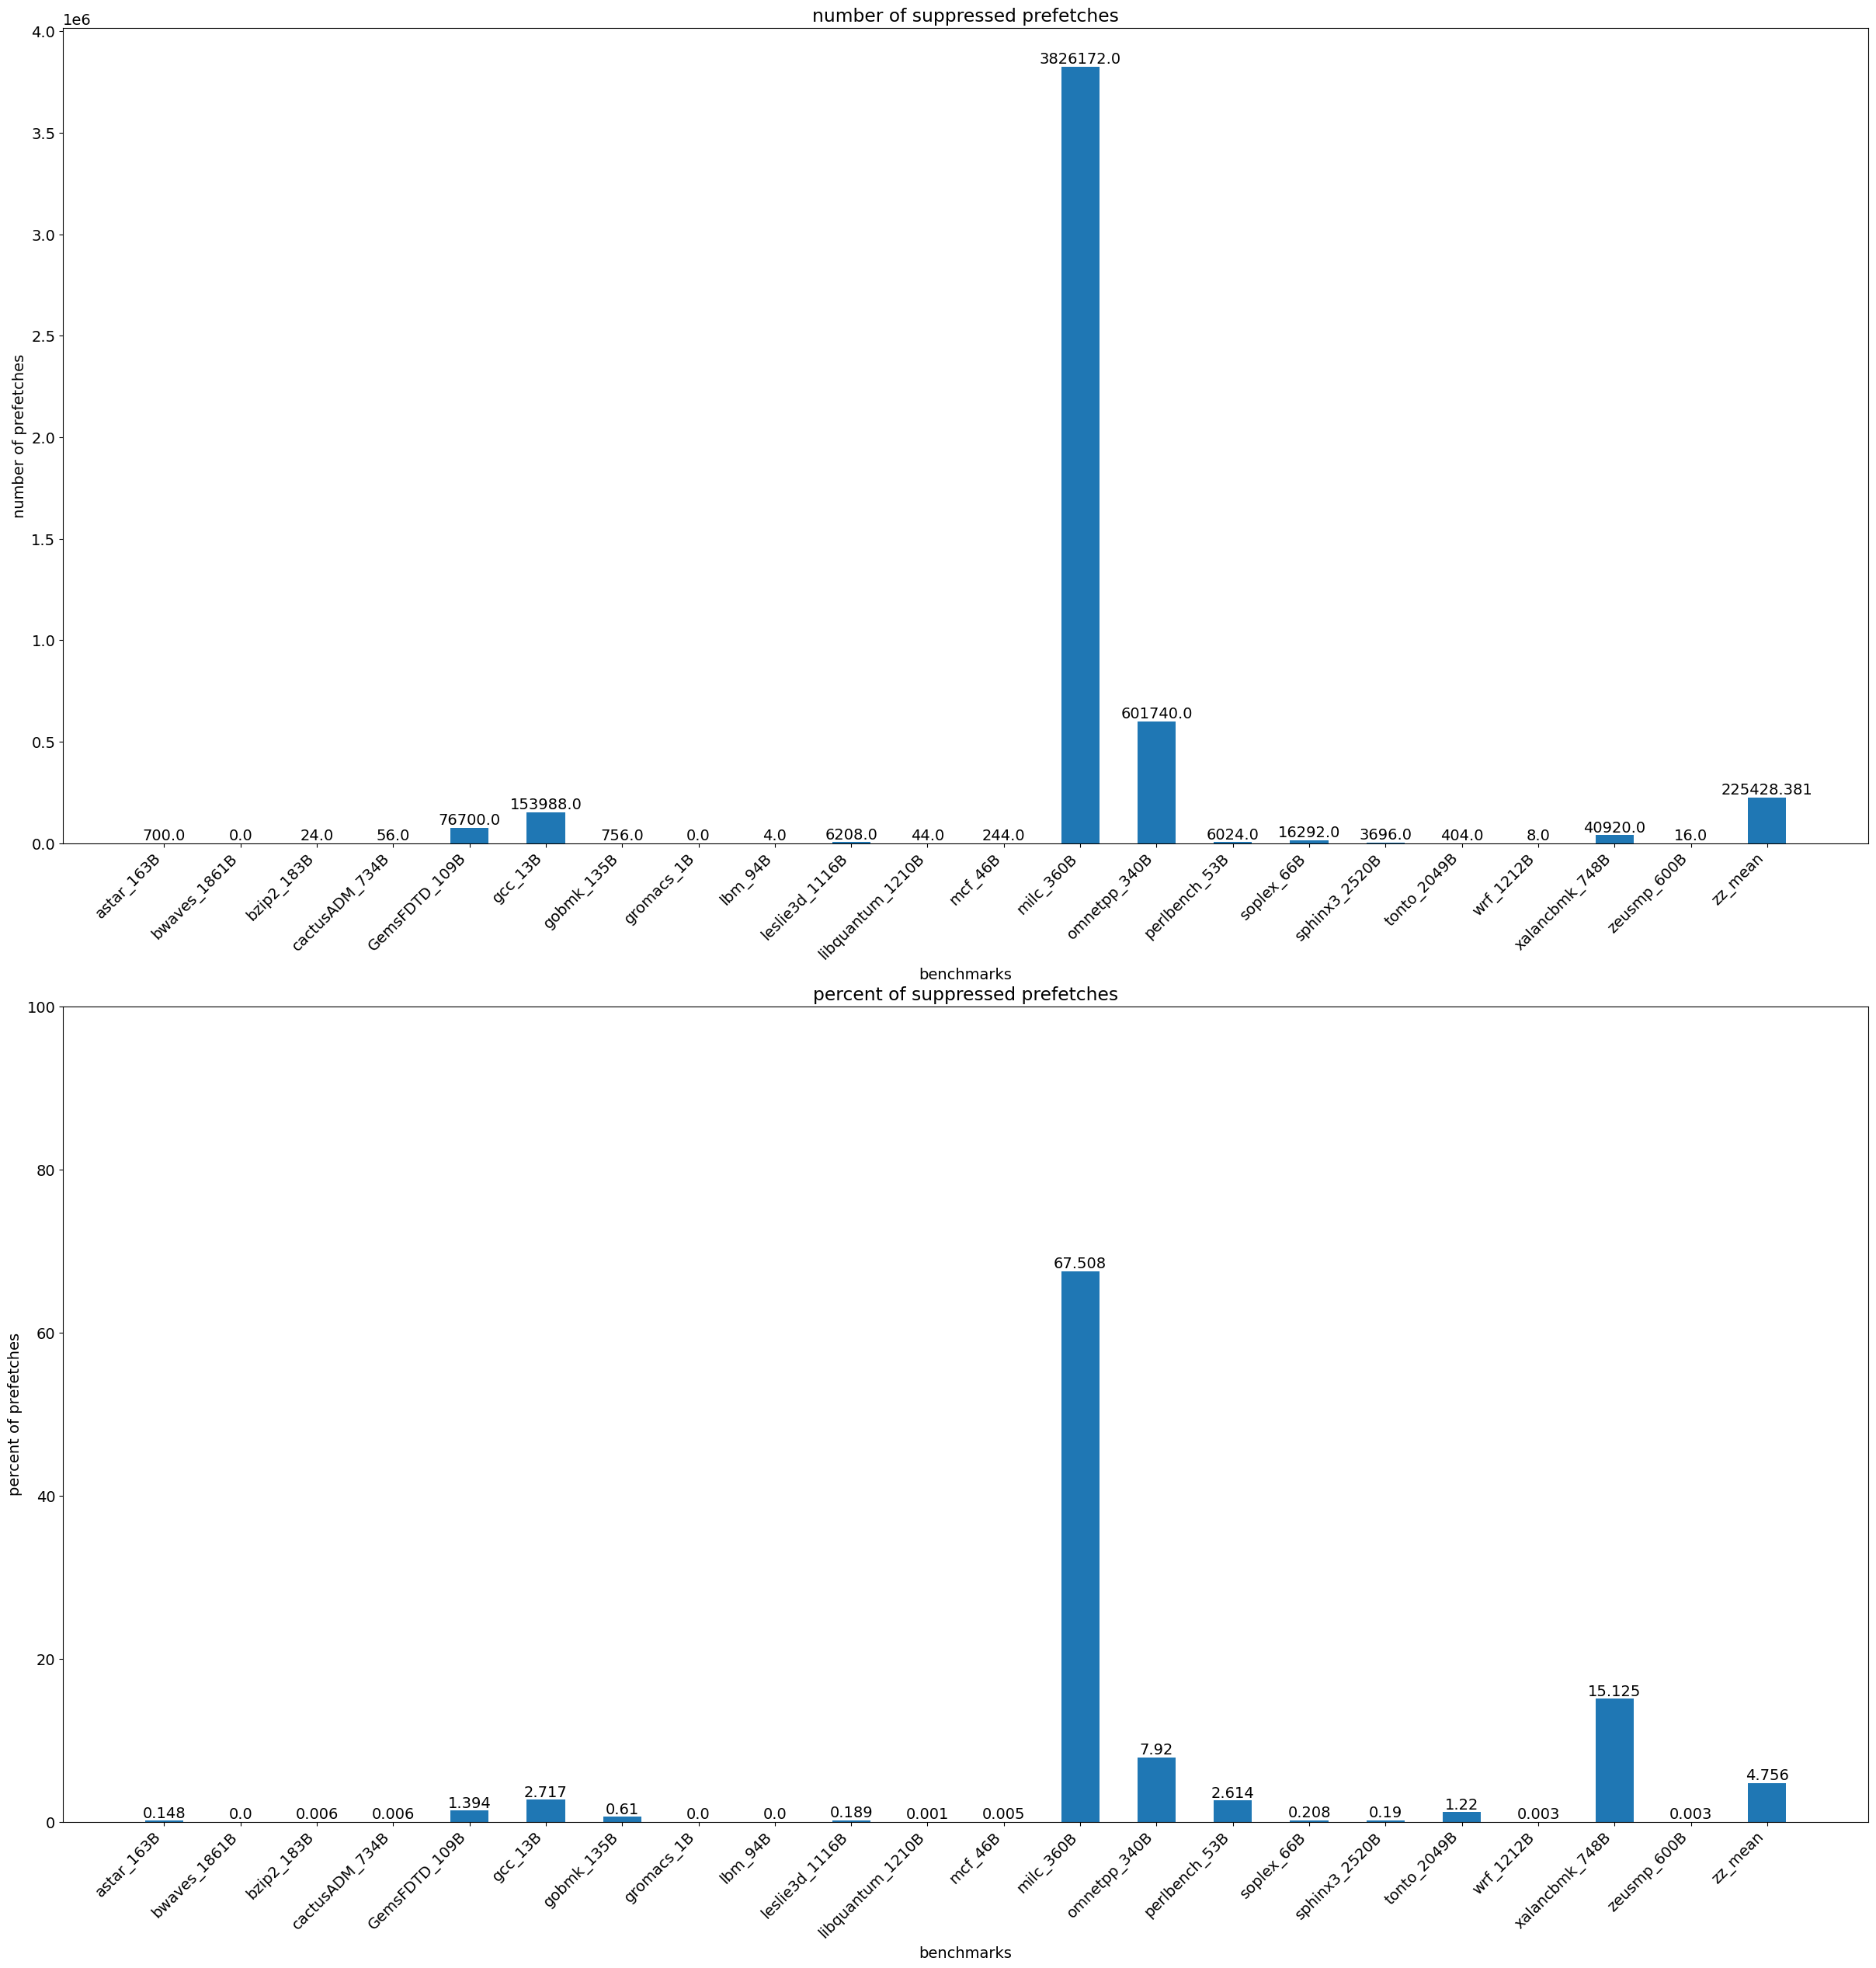

In [170]:
graph_prefetch_suppression_stats(comp_trace_files, traces, cmp_experiment)
plt.show()

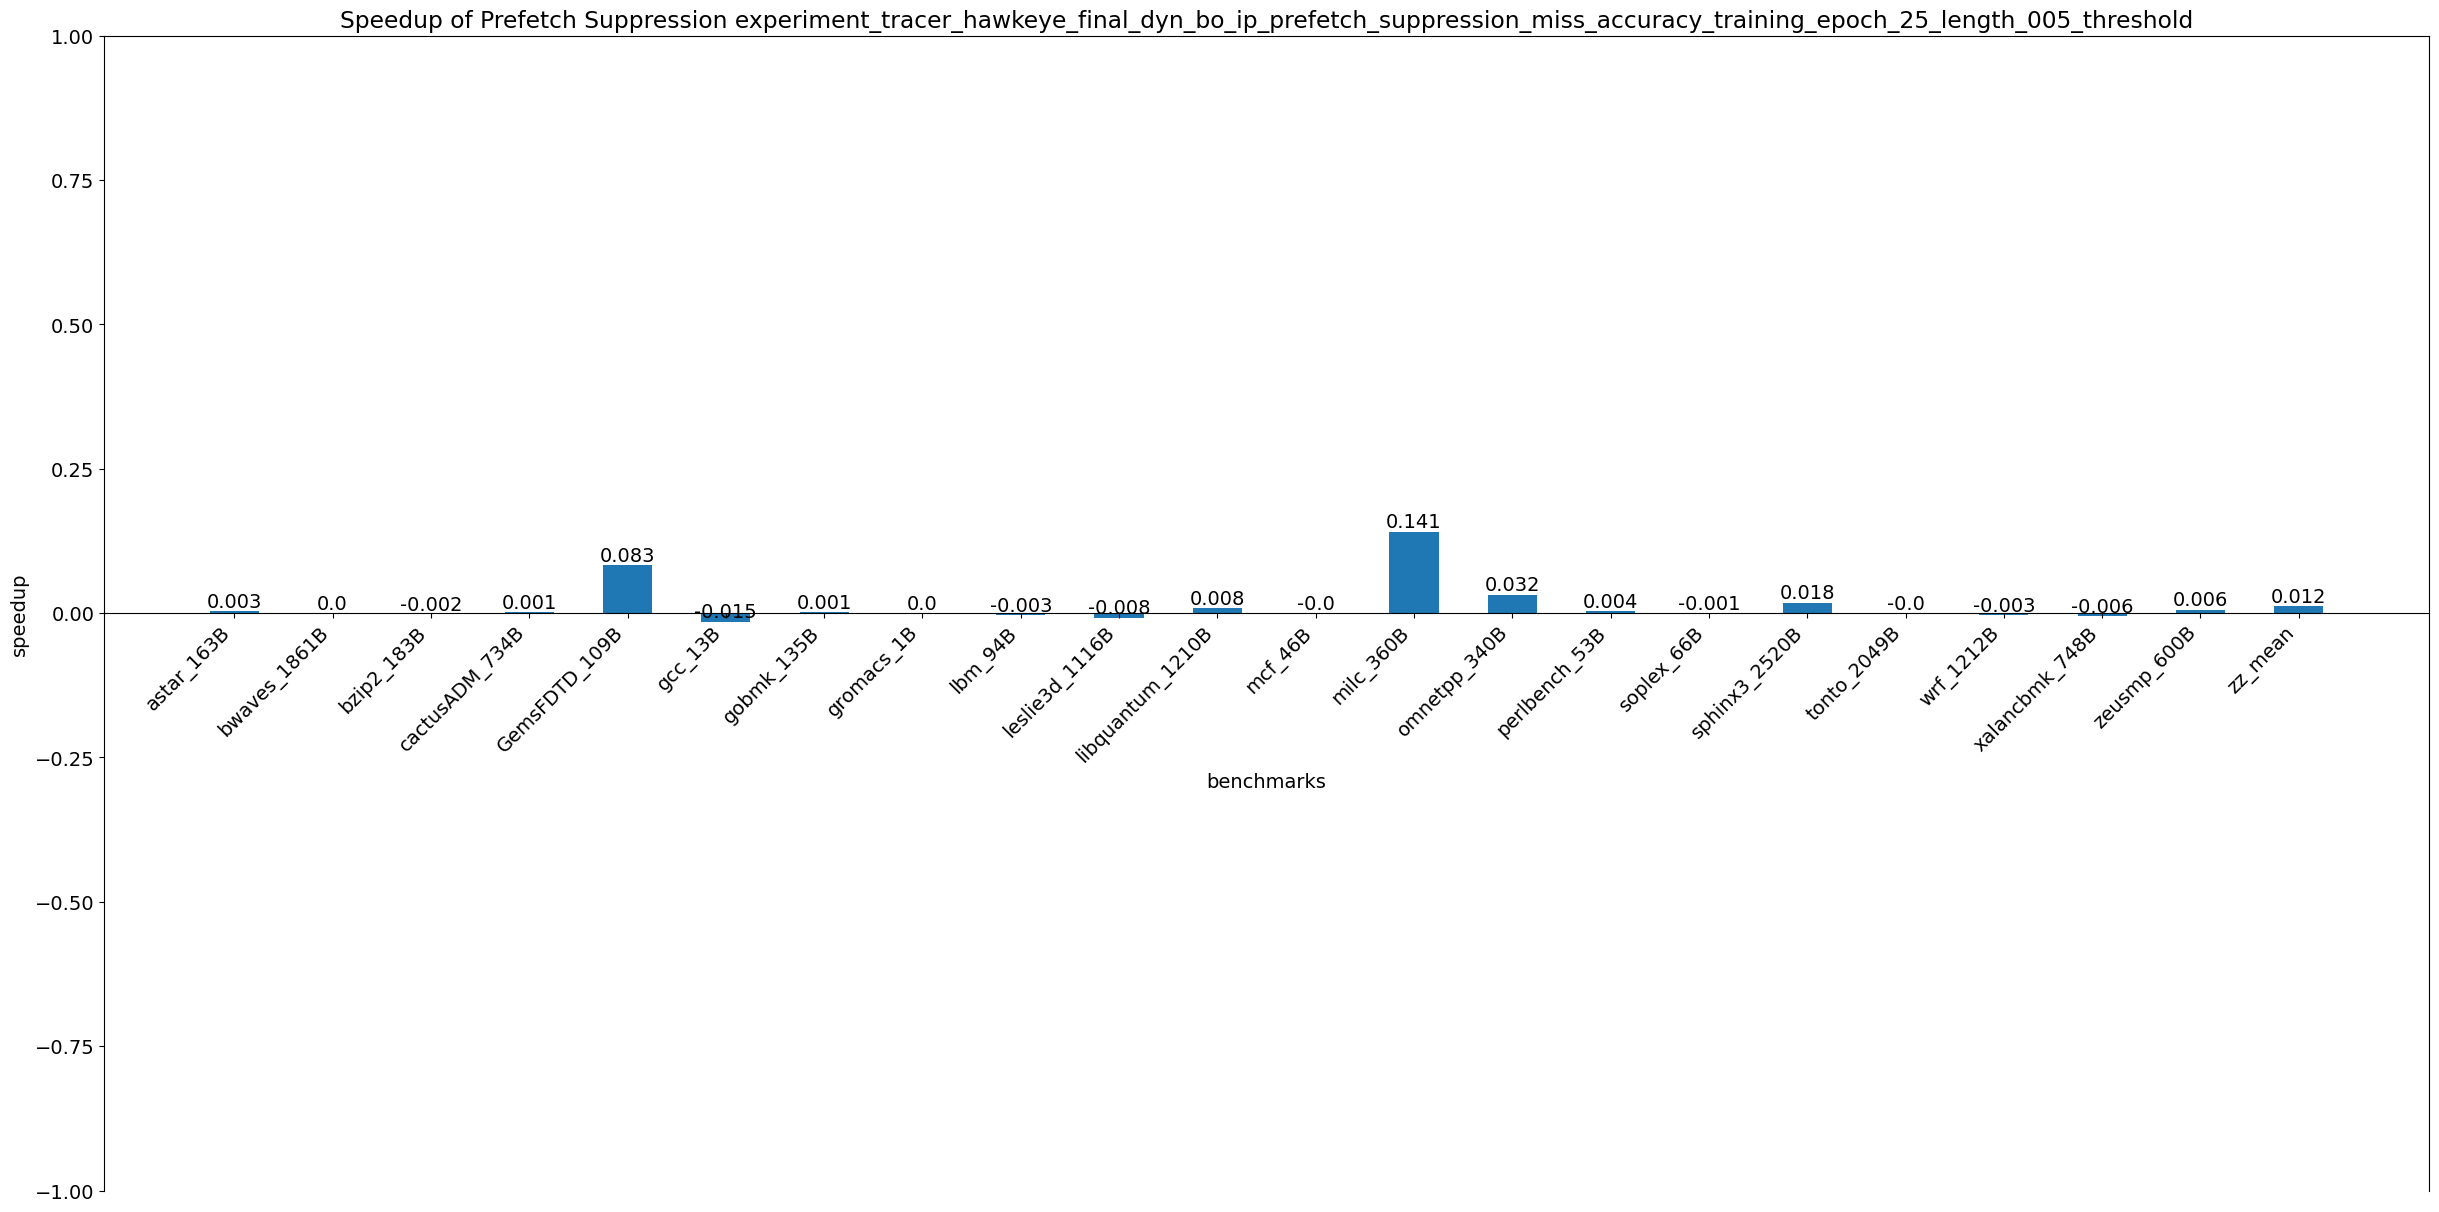

In [171]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

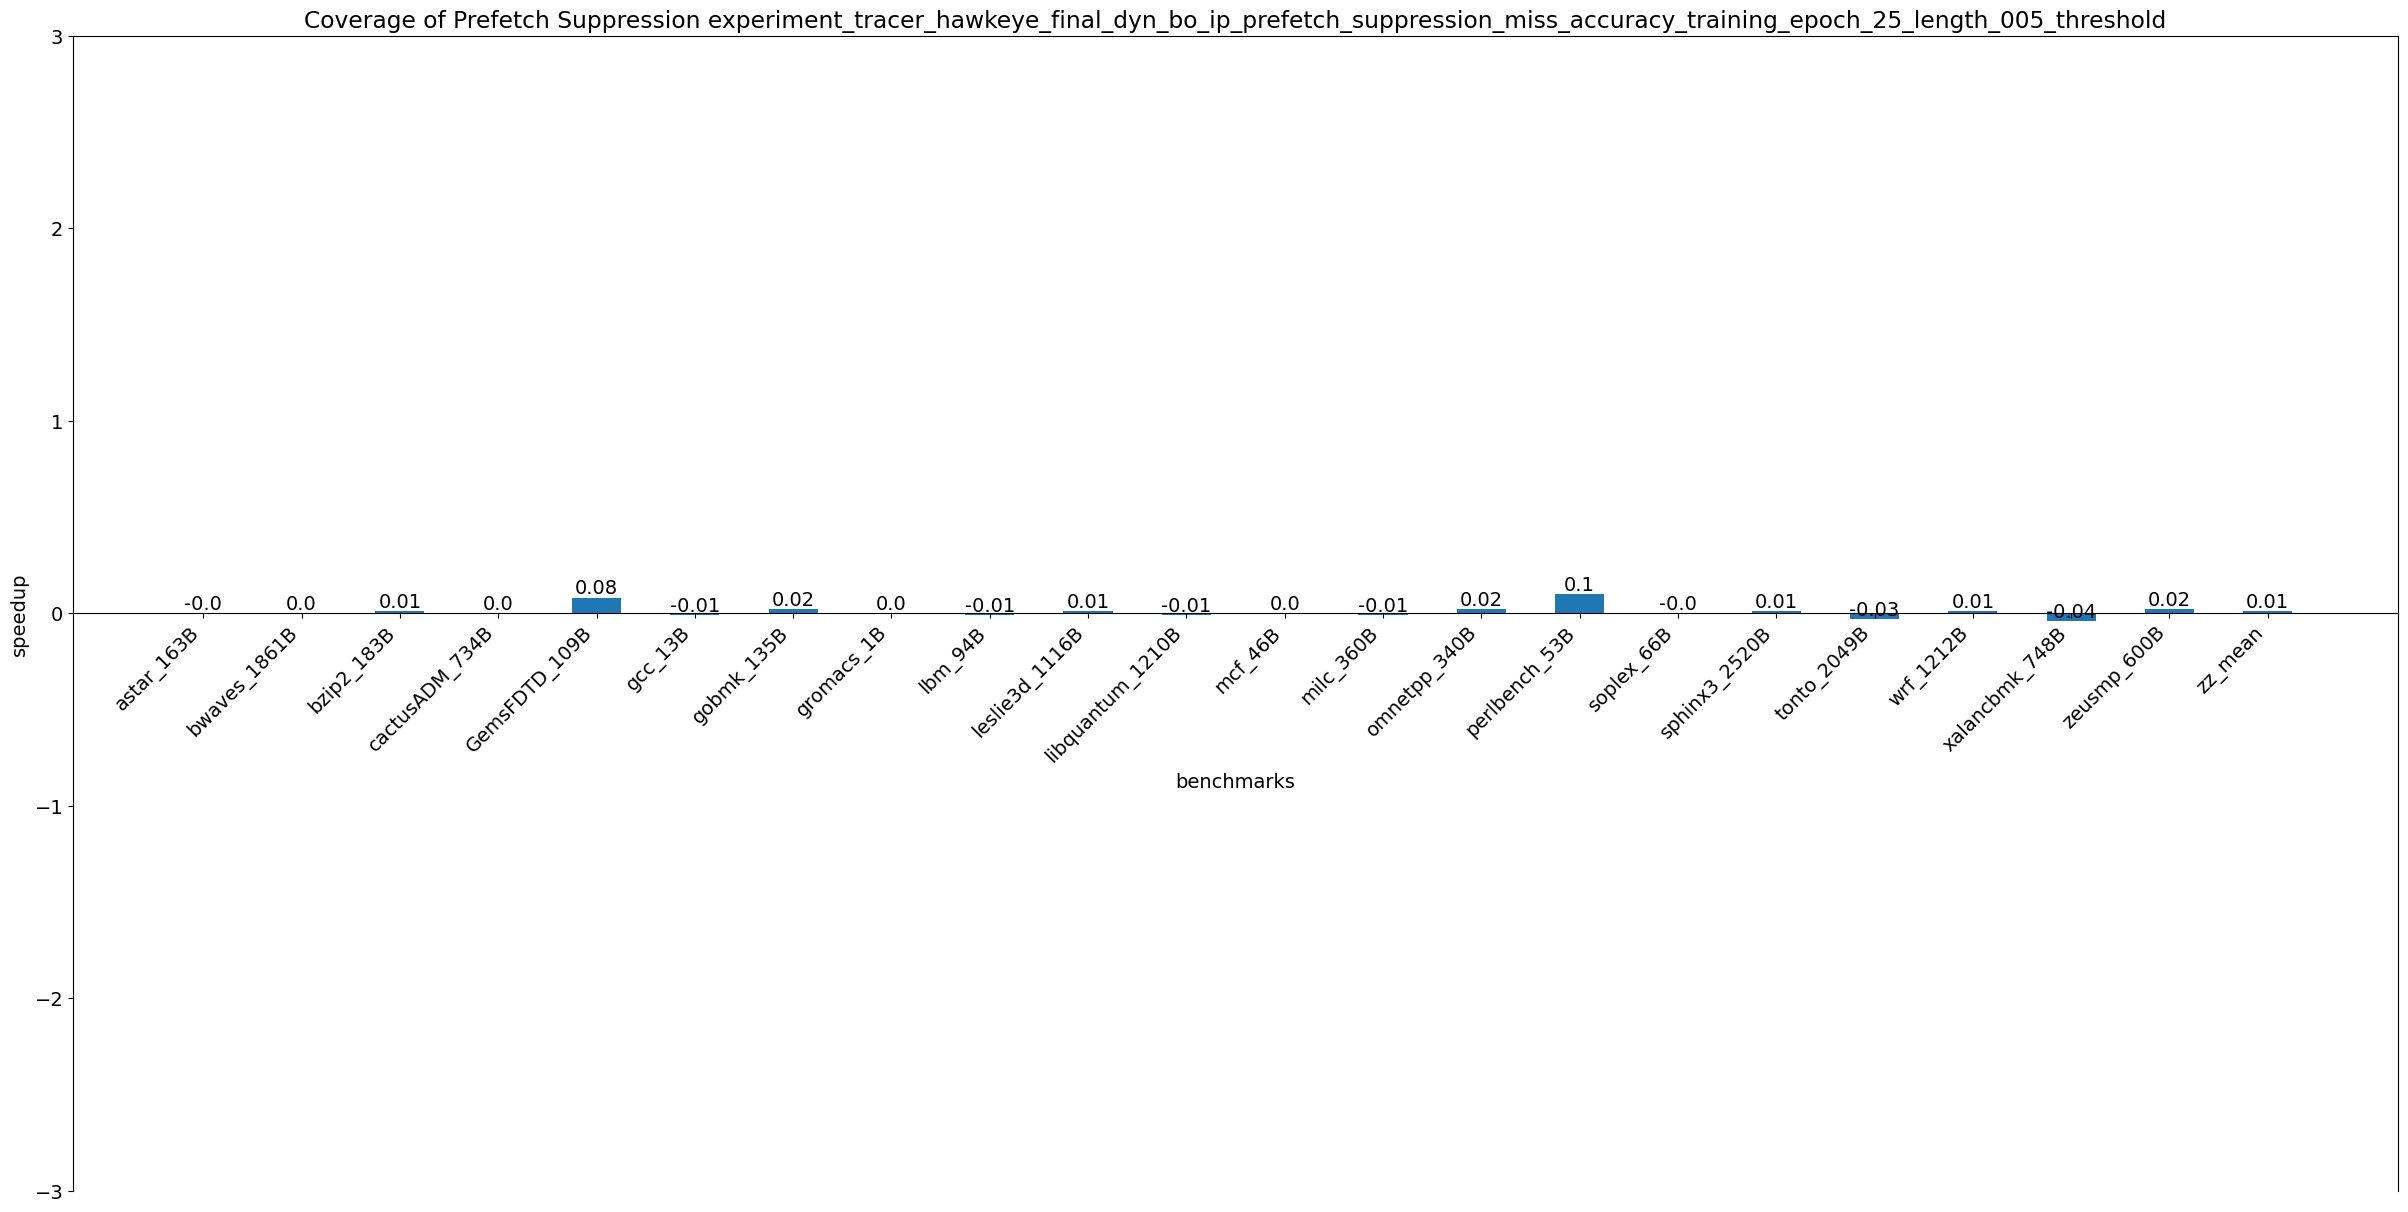

In [172]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

### Analysis of Harmony with BO Prefetch Suppression Sensitivity Study

It seems that there are a few specific benchmarks that benefit the most from prefetch suppression on a per PC basis, namely milc, omnetpp, and Gems.

## Study of Harmony with BO compared to Harmony with No Prefetching

Our headroom with suppressing prefetches is lower-bounded by the performance of harmony without prefetching. We can see from the graphs below that the benchmarks milc, omnetpp, and soplex benefit the most from no prefetching. However, from the sensitivity study above, the benchmarks milc, omnetpp, sphinx, and gems benefit the most from reduced prefetching.

In [173]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetcher_baseline'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_baseline_prefetch_suppress'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

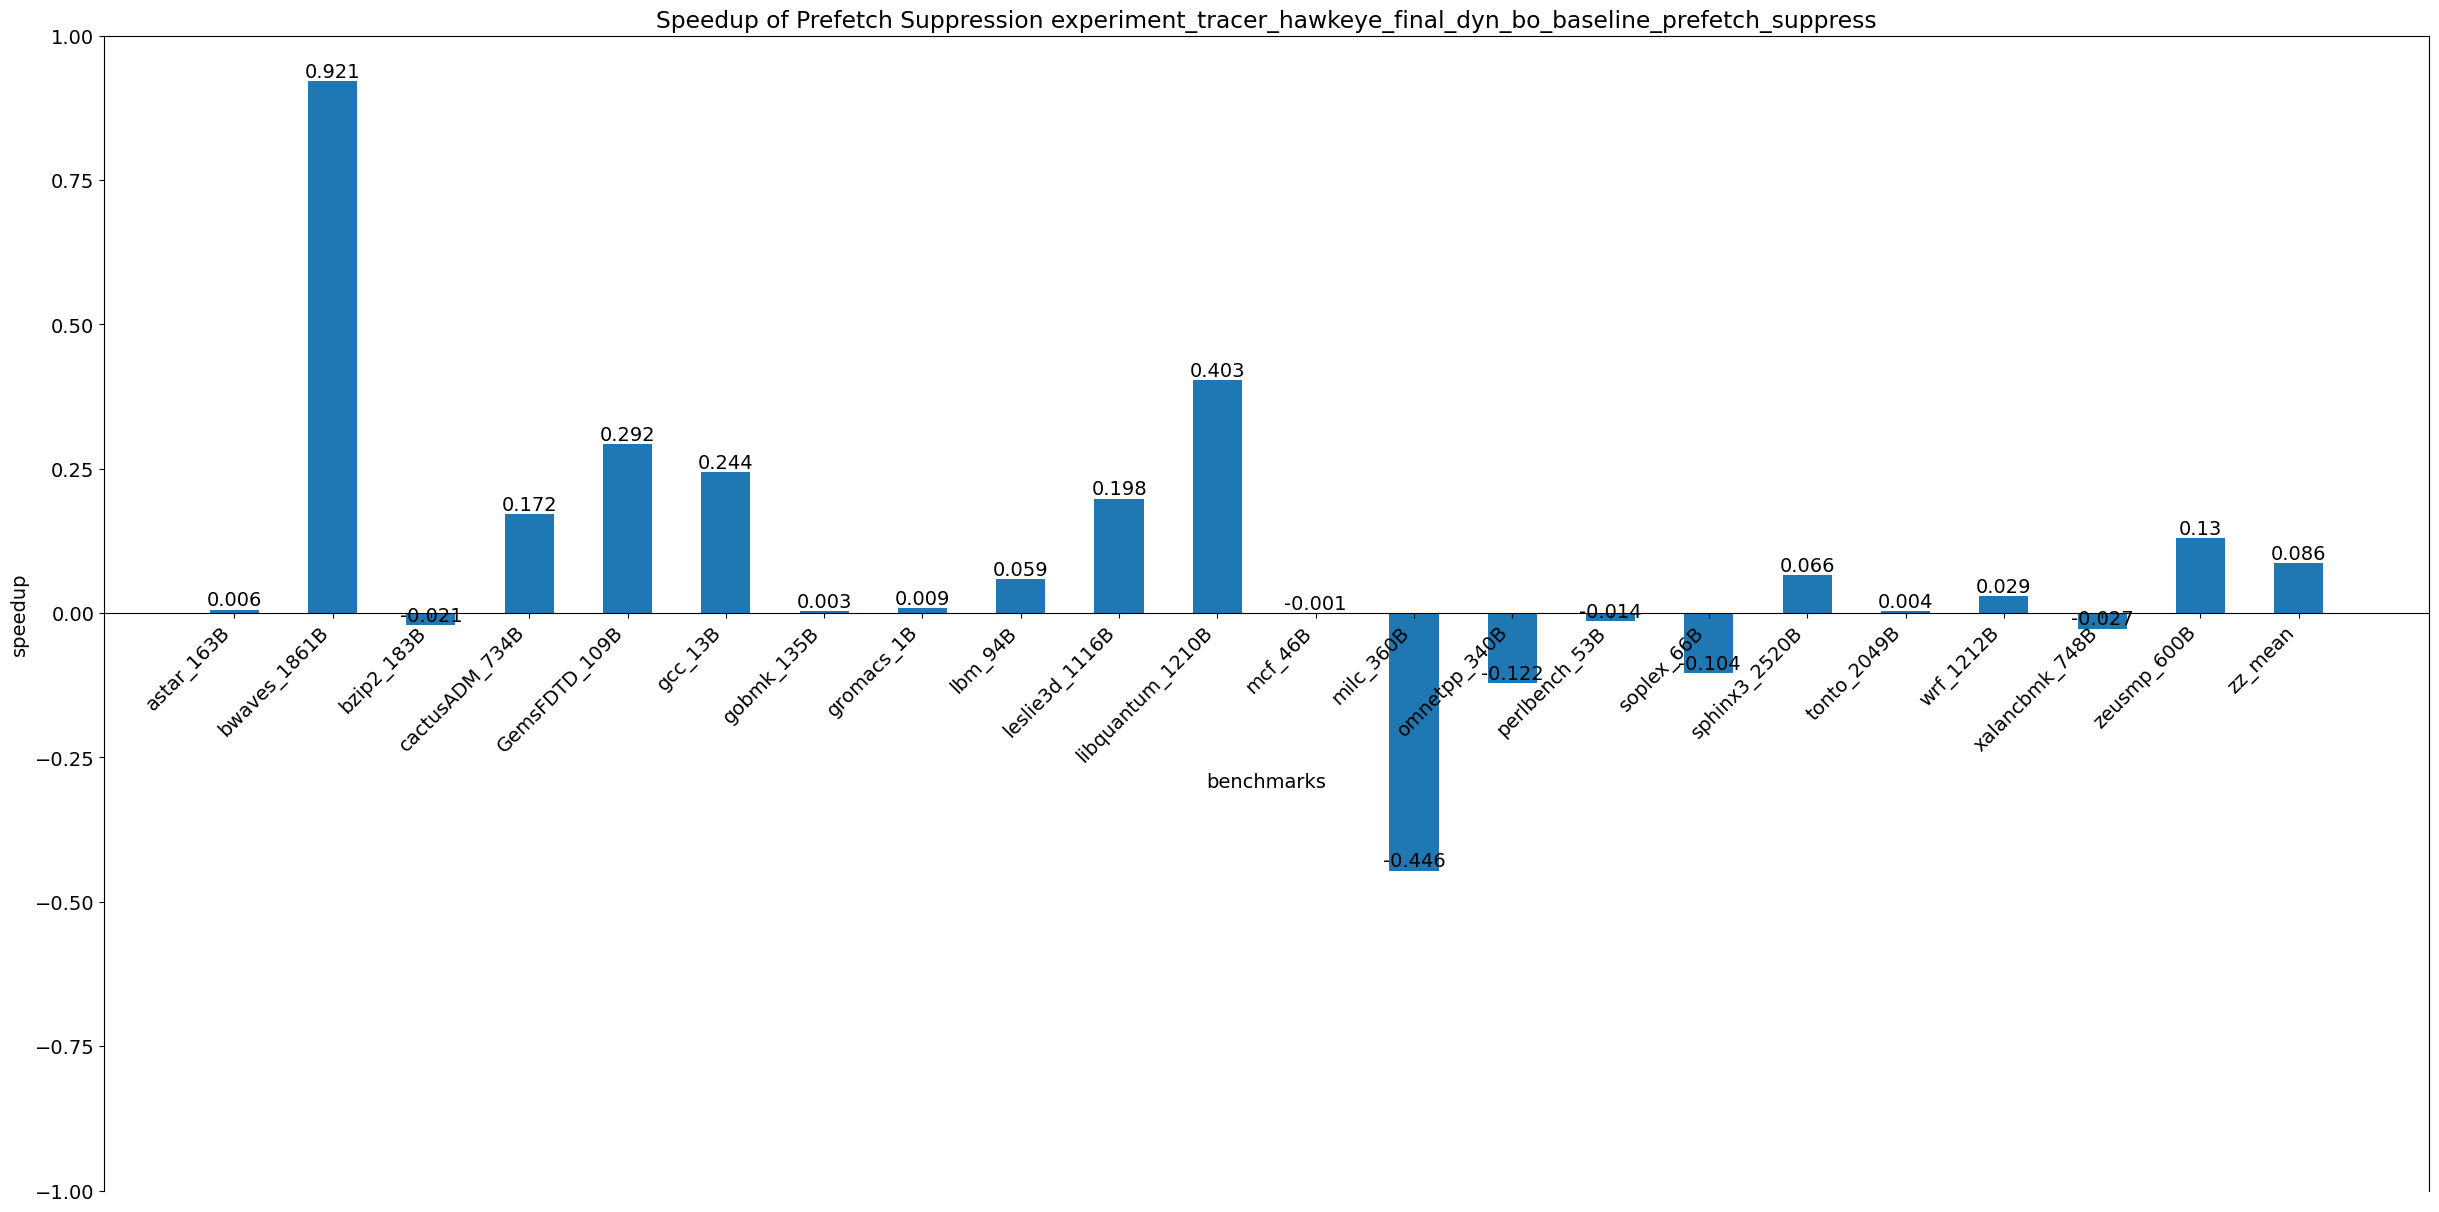

In [174]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

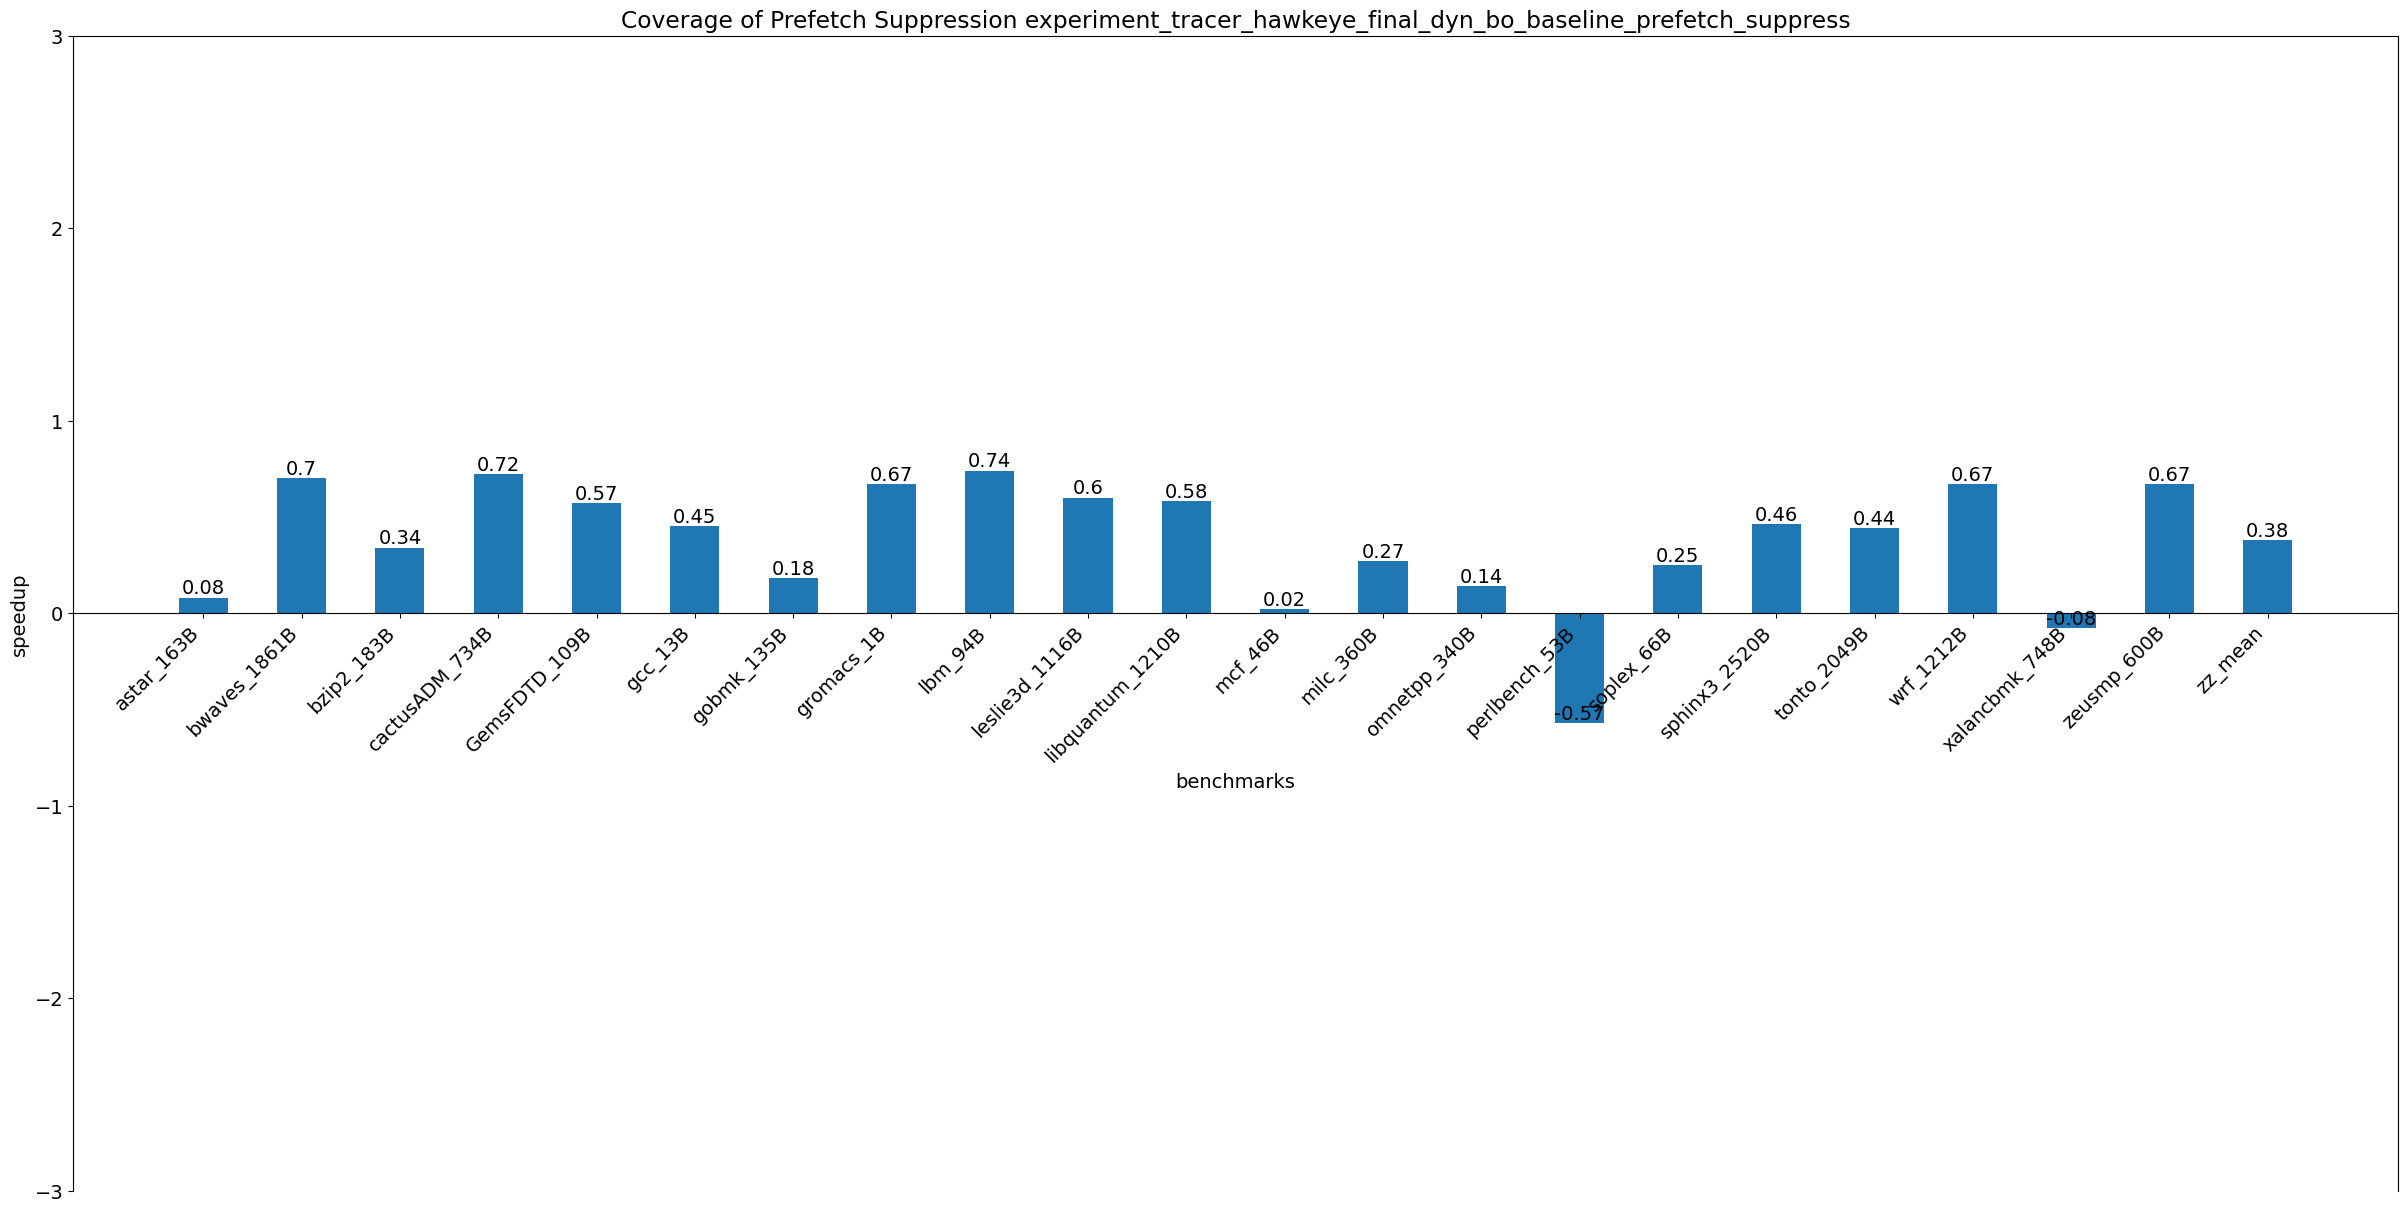

In [175]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

## Study of Harmony with ISB compared to Harmony with No Prefetching

In [194]:
# Harmony with ISB Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetcher_baseline'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_isb_baseline_prefetch_suppress'
trace_list = open('../sim_list/traces_isb.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces_isb.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

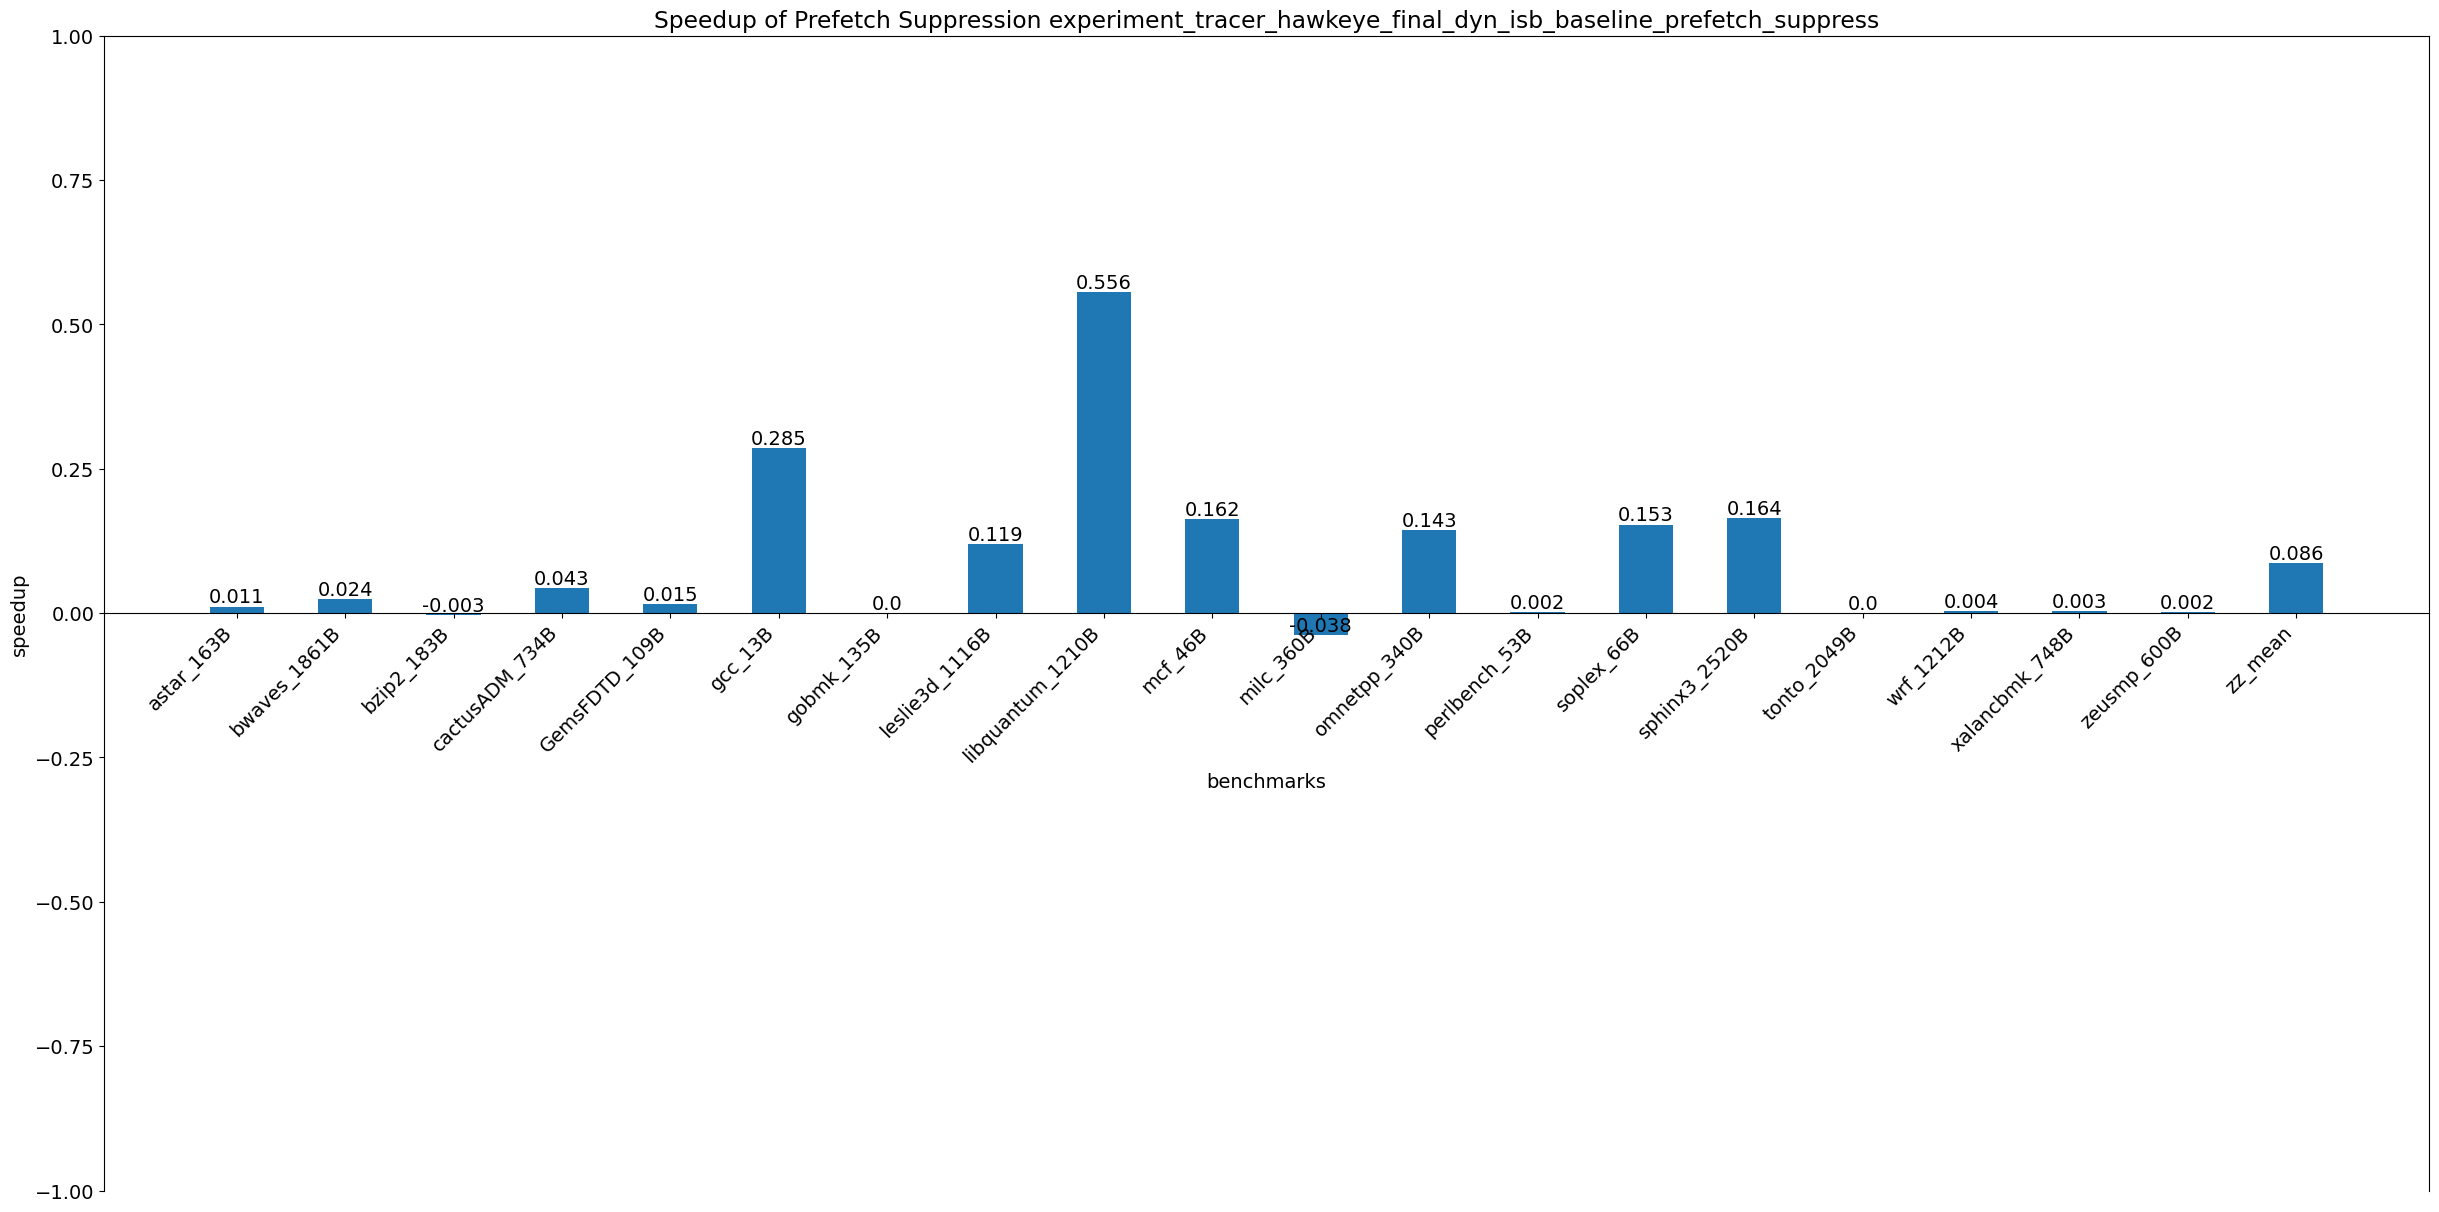

In [195]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

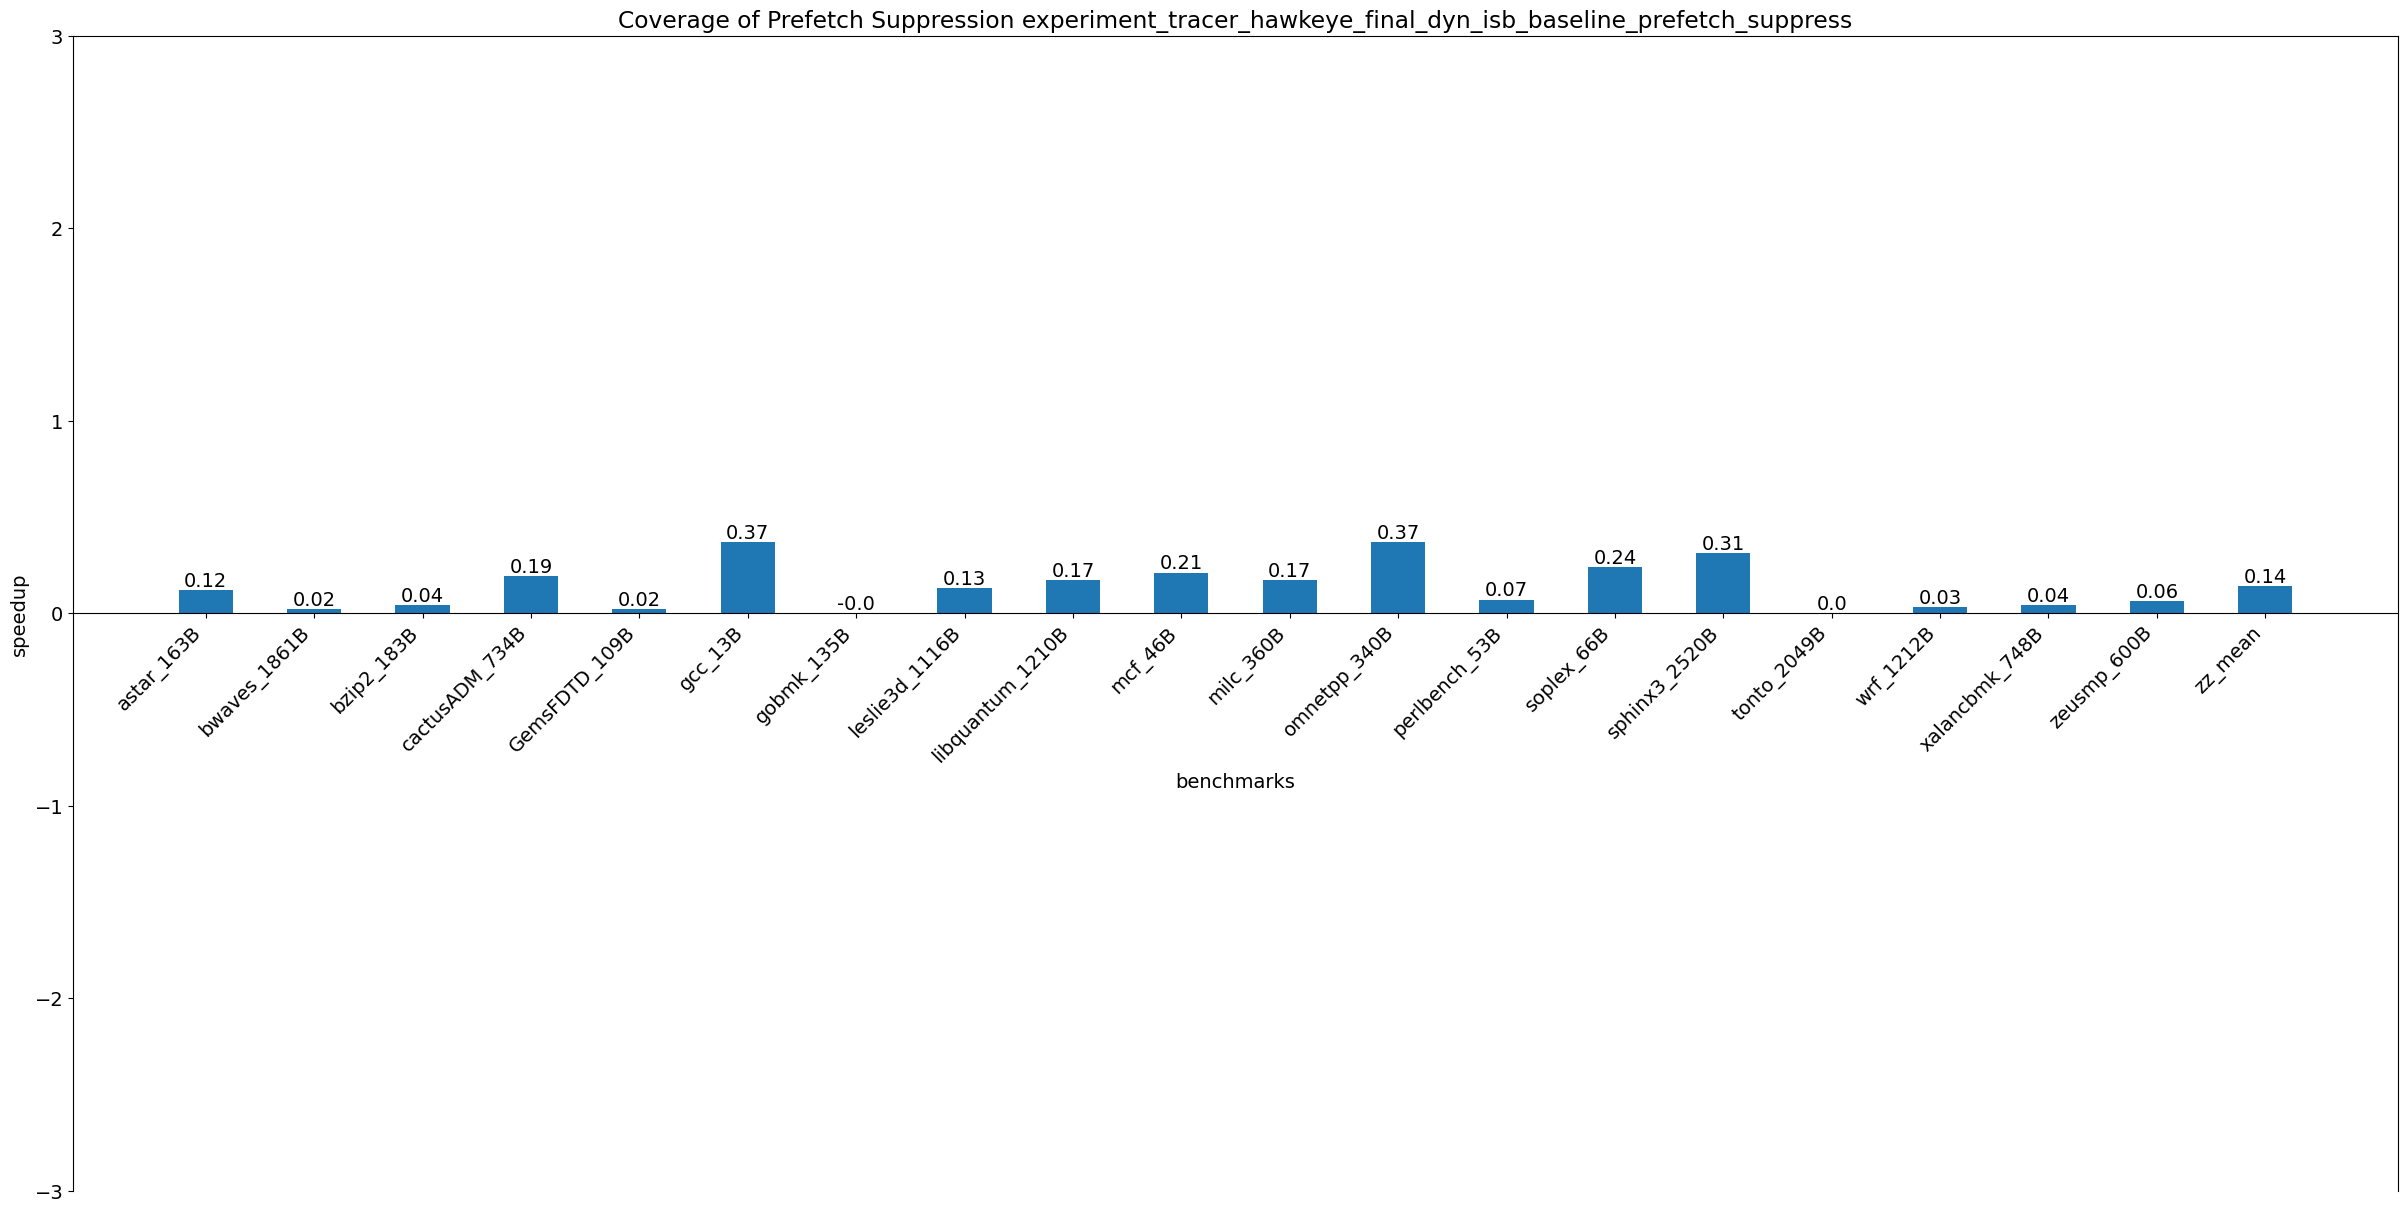

In [196]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

## Harmony with ISB Prefetch Suppression Sensitivity Study

There are four studies:

1.    Training Length: 50 million cycles (half of the epoch length), Accuracy Threshold: 0.000
2.    Training Length: 25 million cycles (25% of epoch length), Accuracy Threshold: 0.000
3.    Training Length: 50 million cycles (half of epoch length), Accuracy Threshold: 0.005
4.    Training Length: 25 million cycles (25% of epoch length), Accuracy Threshold: 0.005

In [201]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_isb_baseline_prefetch_suppress'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_isb_ip_prefetch_suppression_miss_accuracy_training_epoch_25_length_005_threshold'
trace_list = open('../sim_list/traces_isb.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces_isb.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

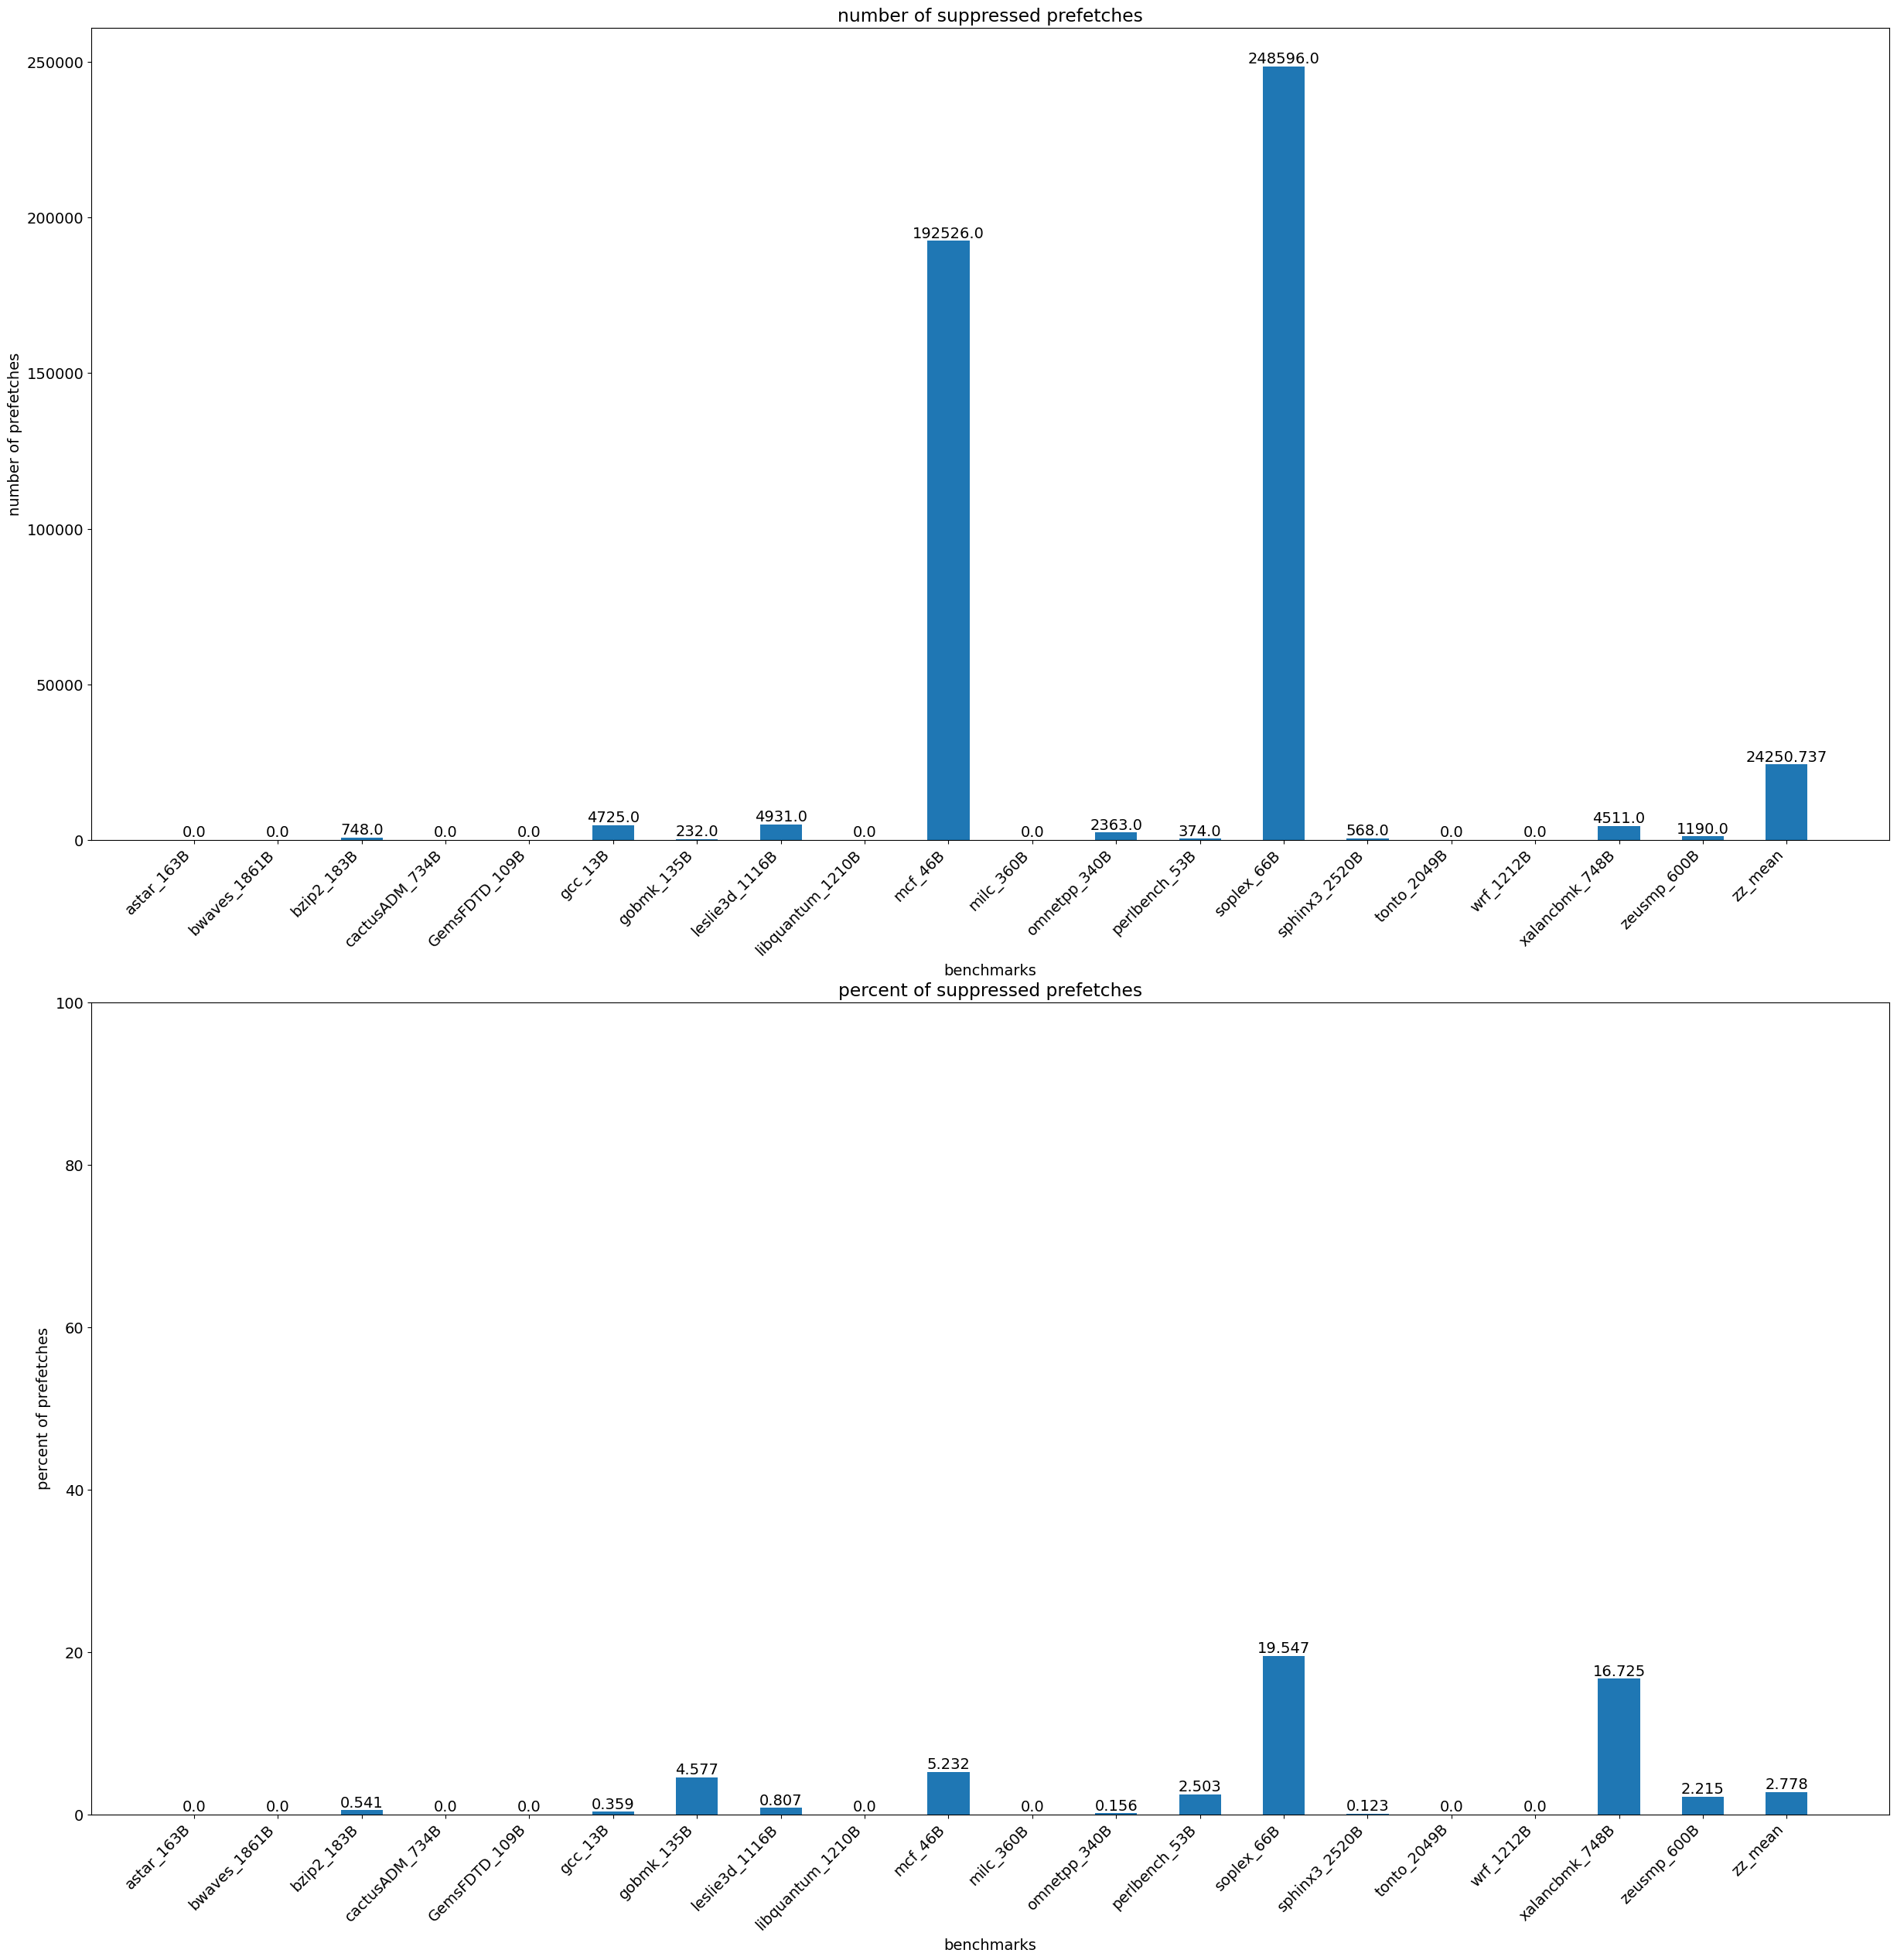

In [202]:
graph_prefetch_suppression_stats(comp_trace_files, traces, cmp_experiment)
plt.show()

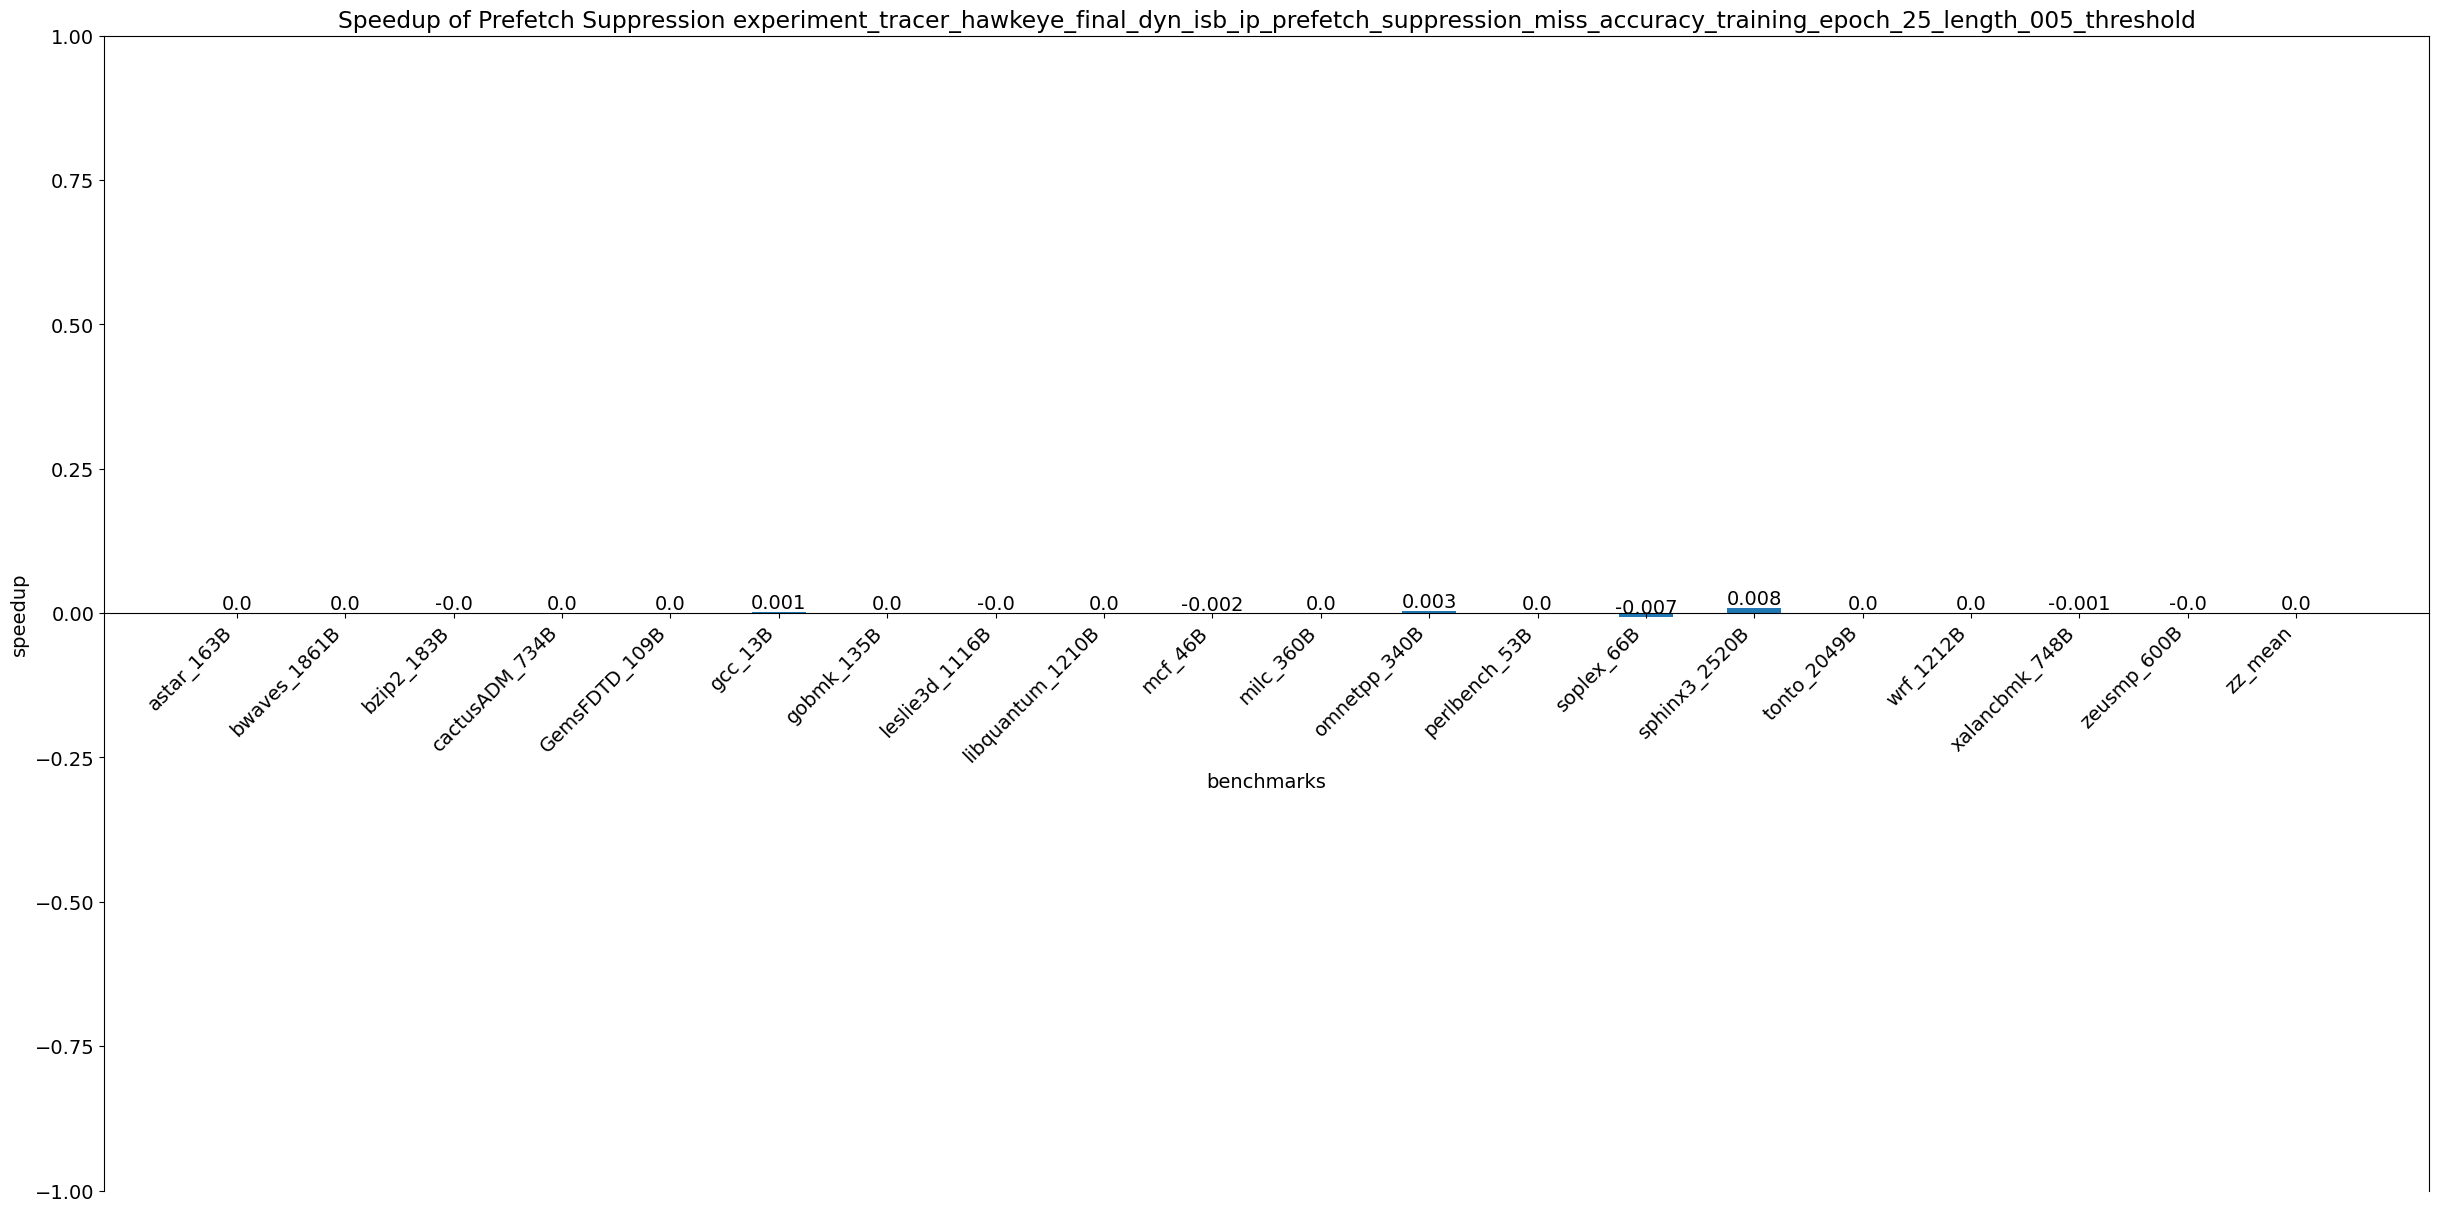

In [203]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

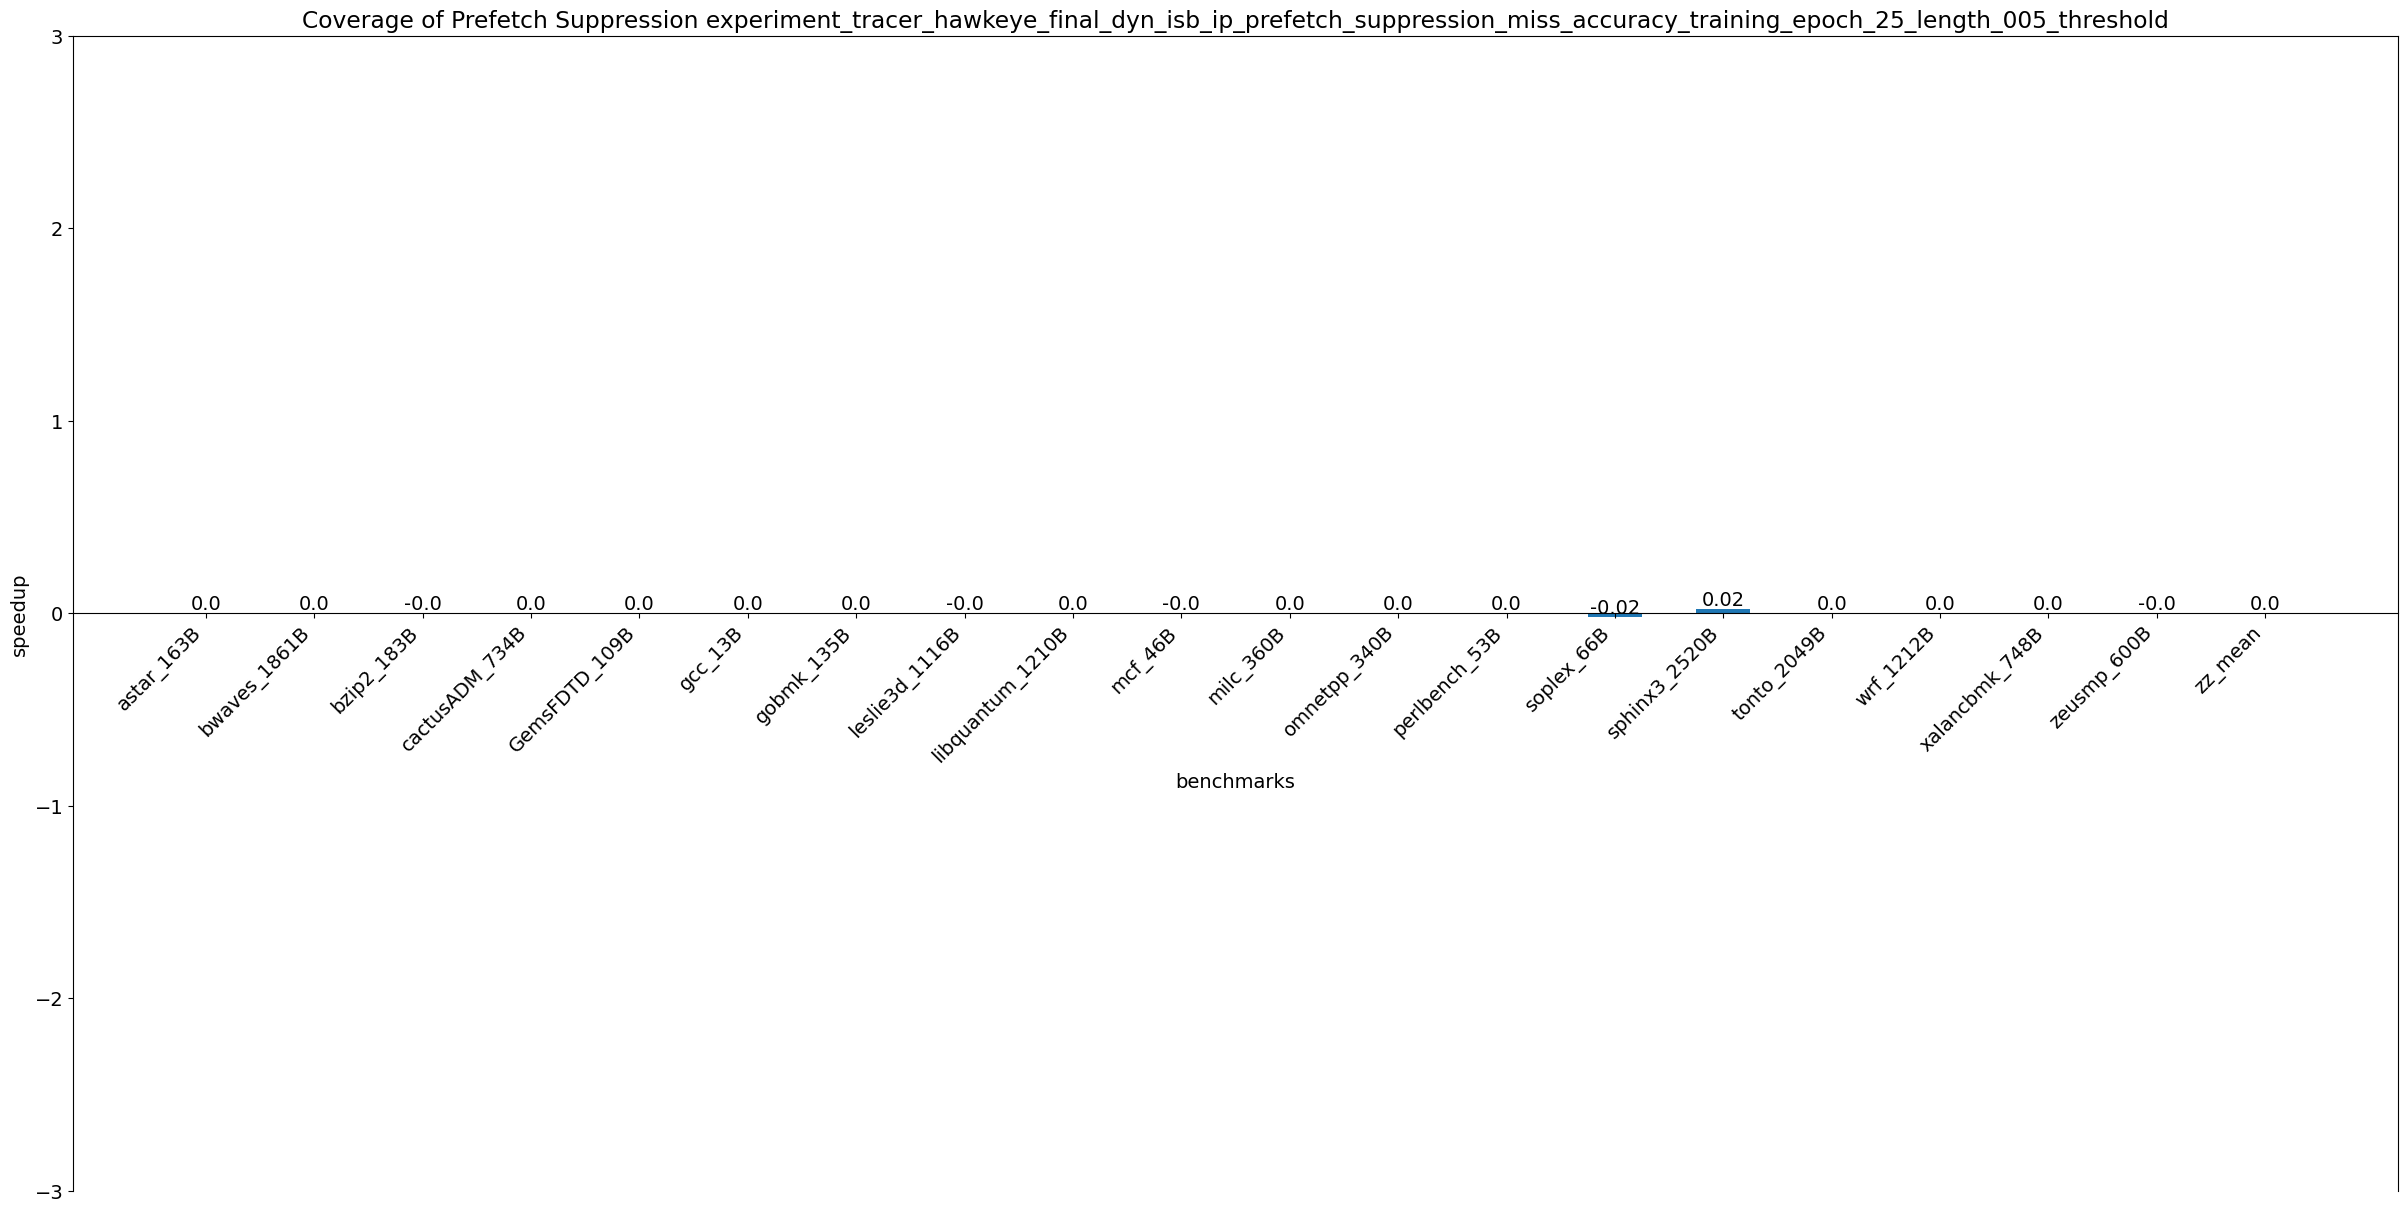

In [204]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

### Analysis

Since ISB is more accurate compared to the Best Offset prefetcher, we expect to see reduced prefetch suppression, and thus reduced effects on speedup and coverage. Speedup and coverage are hardly affected, suggesting prefetch suppression with the ISB prefetcher has little effect since the ISB prefetcher is already highly accurate. 

In [26]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_baseline_prefetch_suppress'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_prefetch_suppression_08_threshold_ips'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

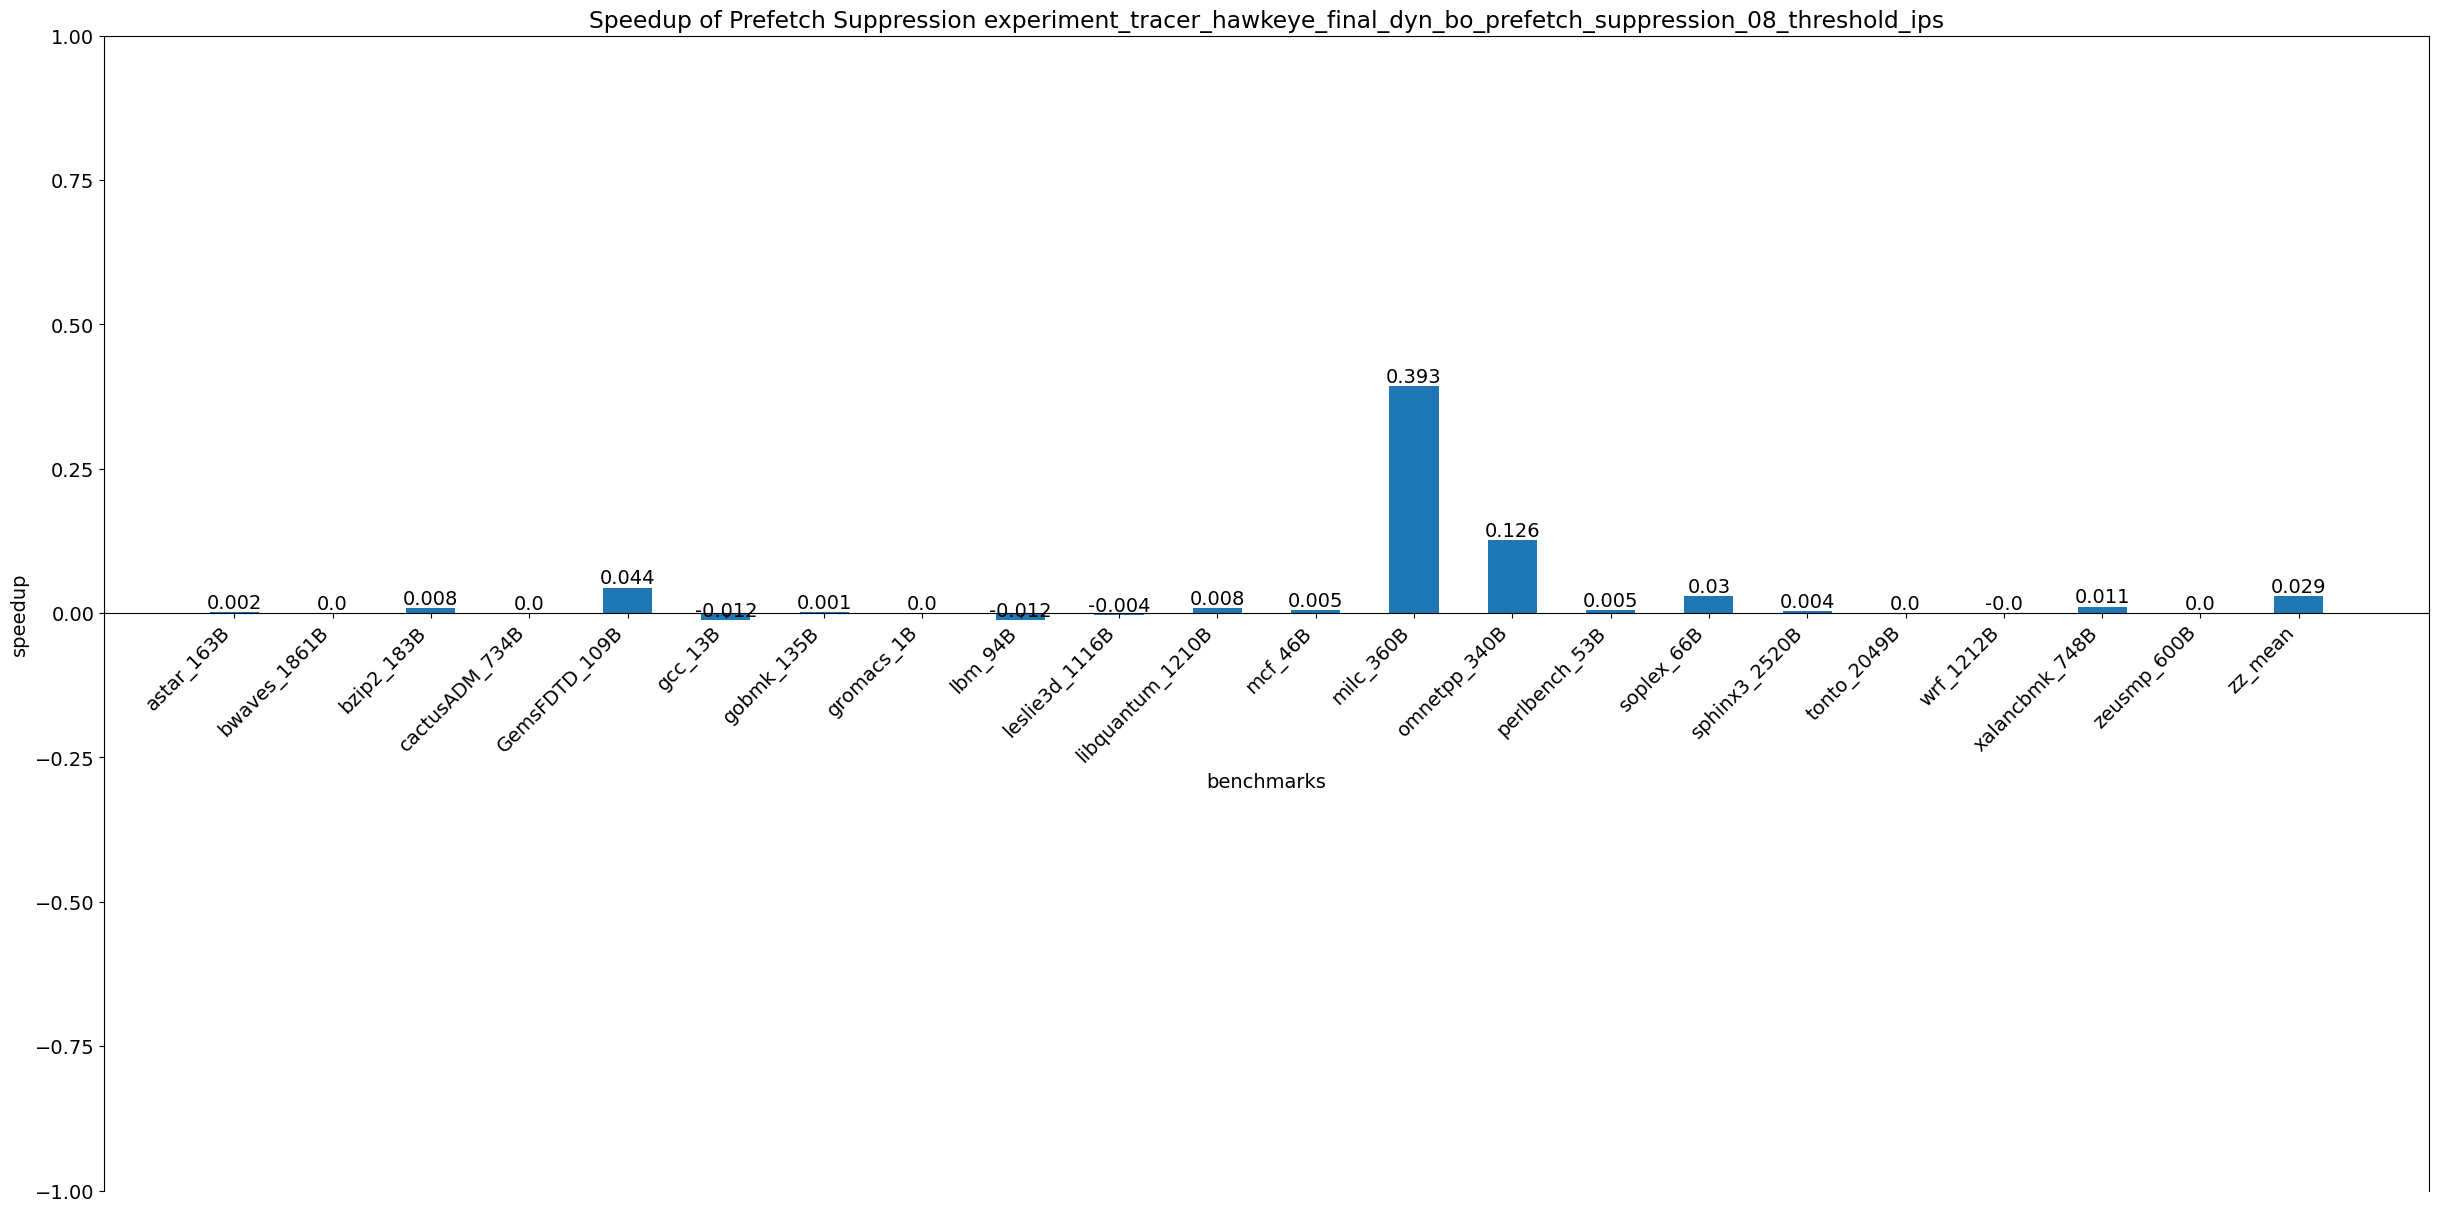

In [27]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

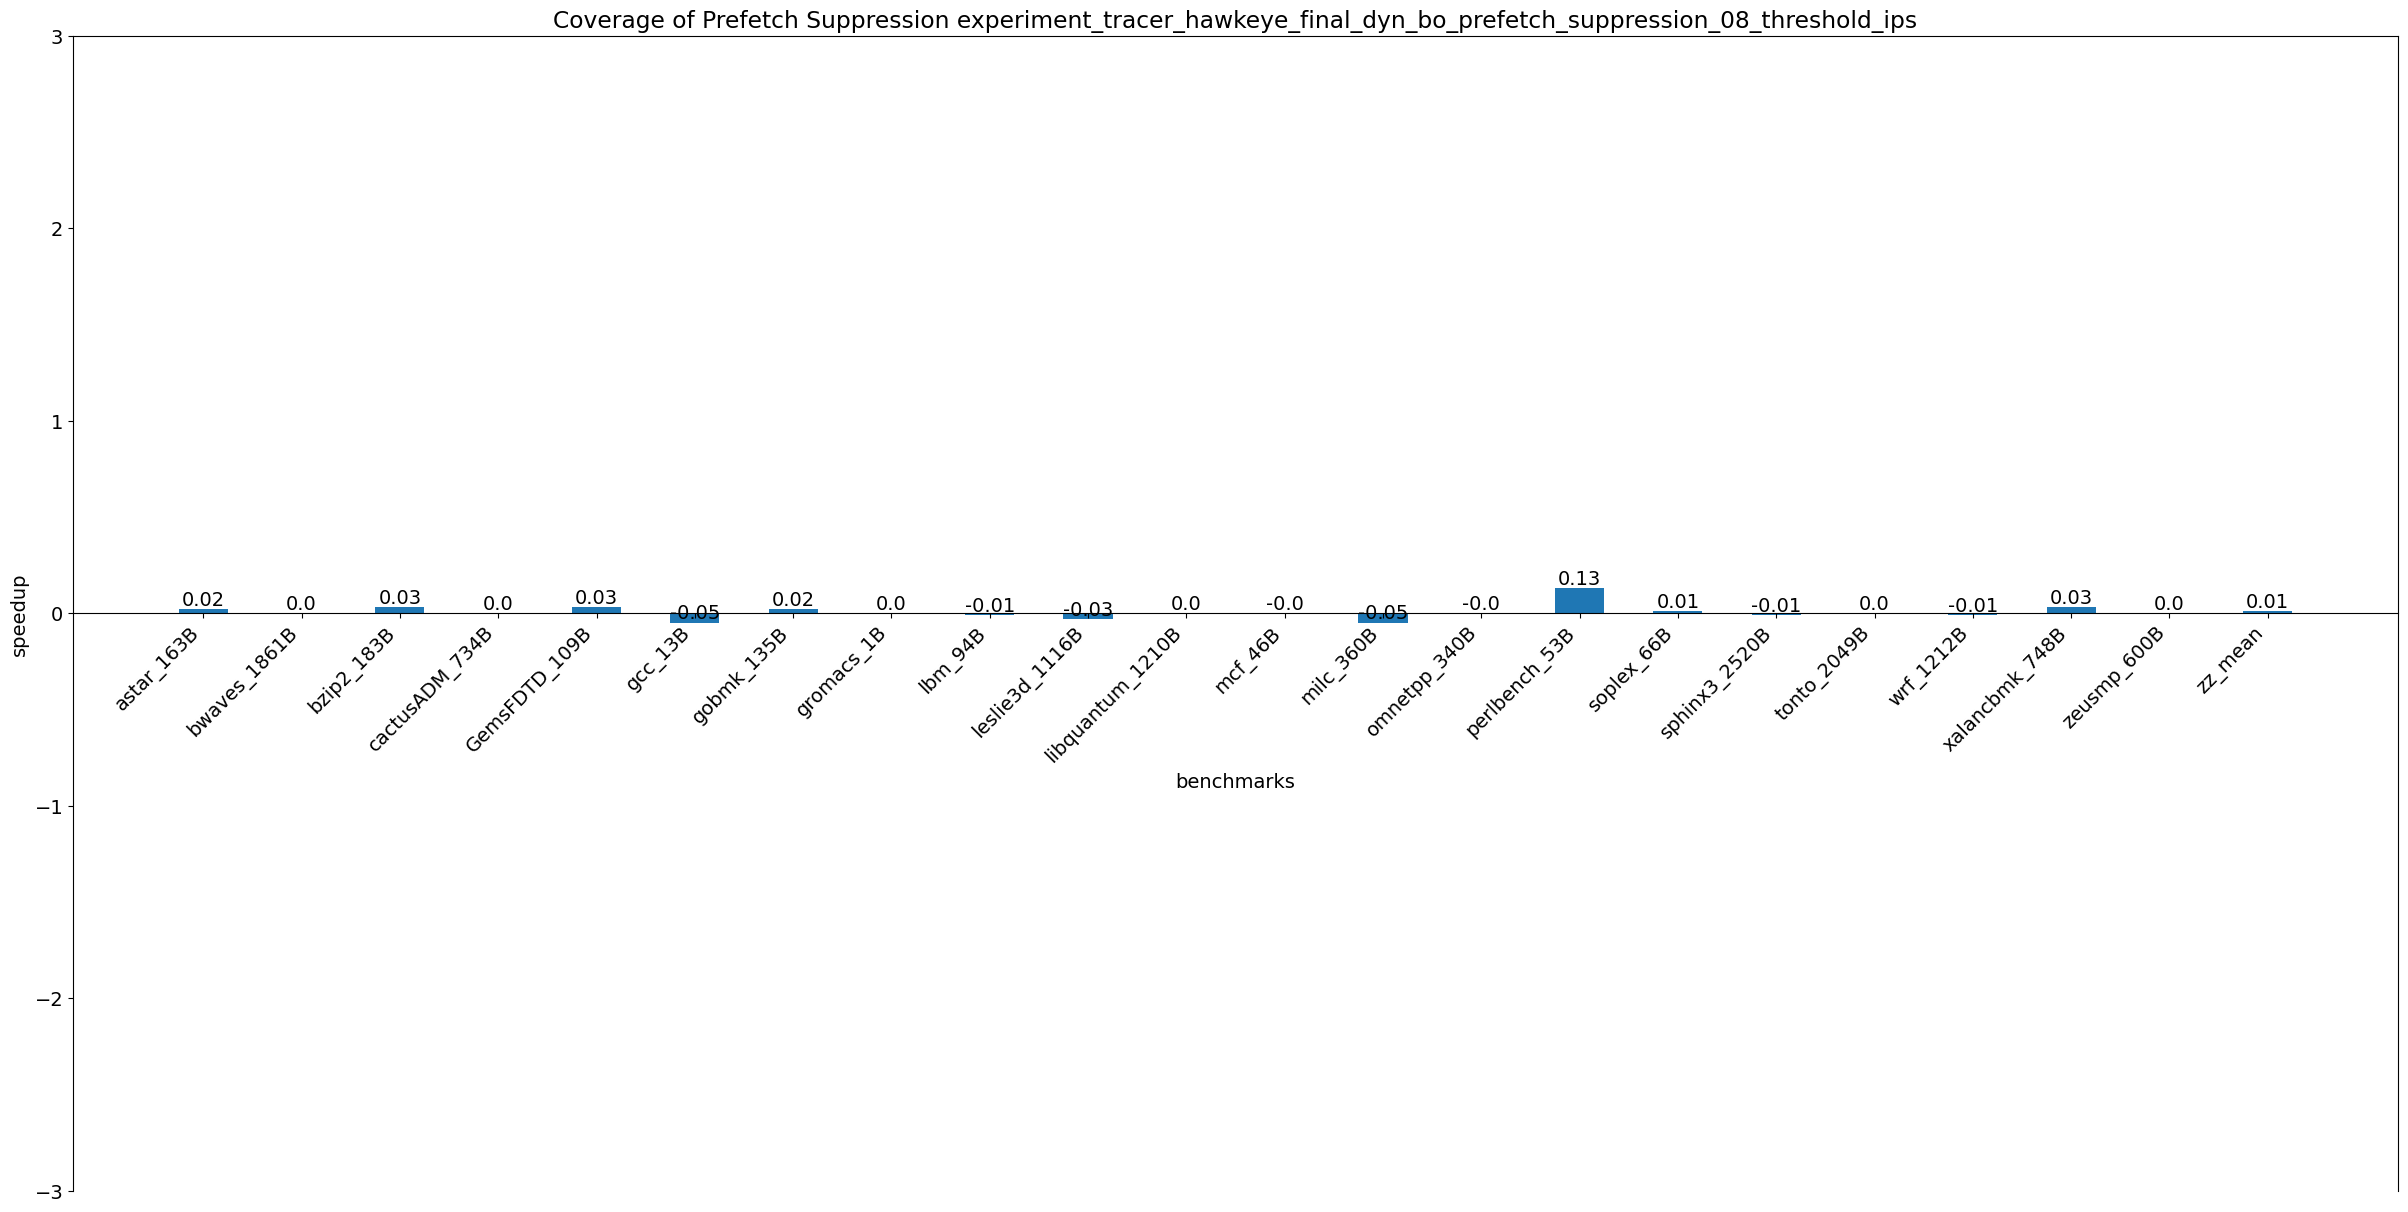

In [28]:
graph_coverage(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [47]:
(best_accuracy_thresholds, best_speedup) = find_best_accuracy_threshold(base_trace_files, traces)
print(best_accuracy_thresholds)
print(best_speedup)

[20, 65, 75, 35, 5, 5, 35, 5, 80, 75, 5, 30, 90, 15, 60, 70, 75, 50, 35, 75, 45]
[1.004817679284103, 1.00419930309438, 1.0184094368340944, 1.0005202767309747, 1.0438746454332348, 0.9867154244638985, 1.001700526541773, 1.0, 1.0064556302131604, 1.0196644641298744, 1.0078119141293036, 1.0053978278234073, 1.669815314083278, 1.1325313496046143, 1.009412191801543, 1.1209502145078245, 1.0480849750980652, 1.0000401214342074, 1.0014151267431477, 1.0153697710109253, 1.0144189096846092]


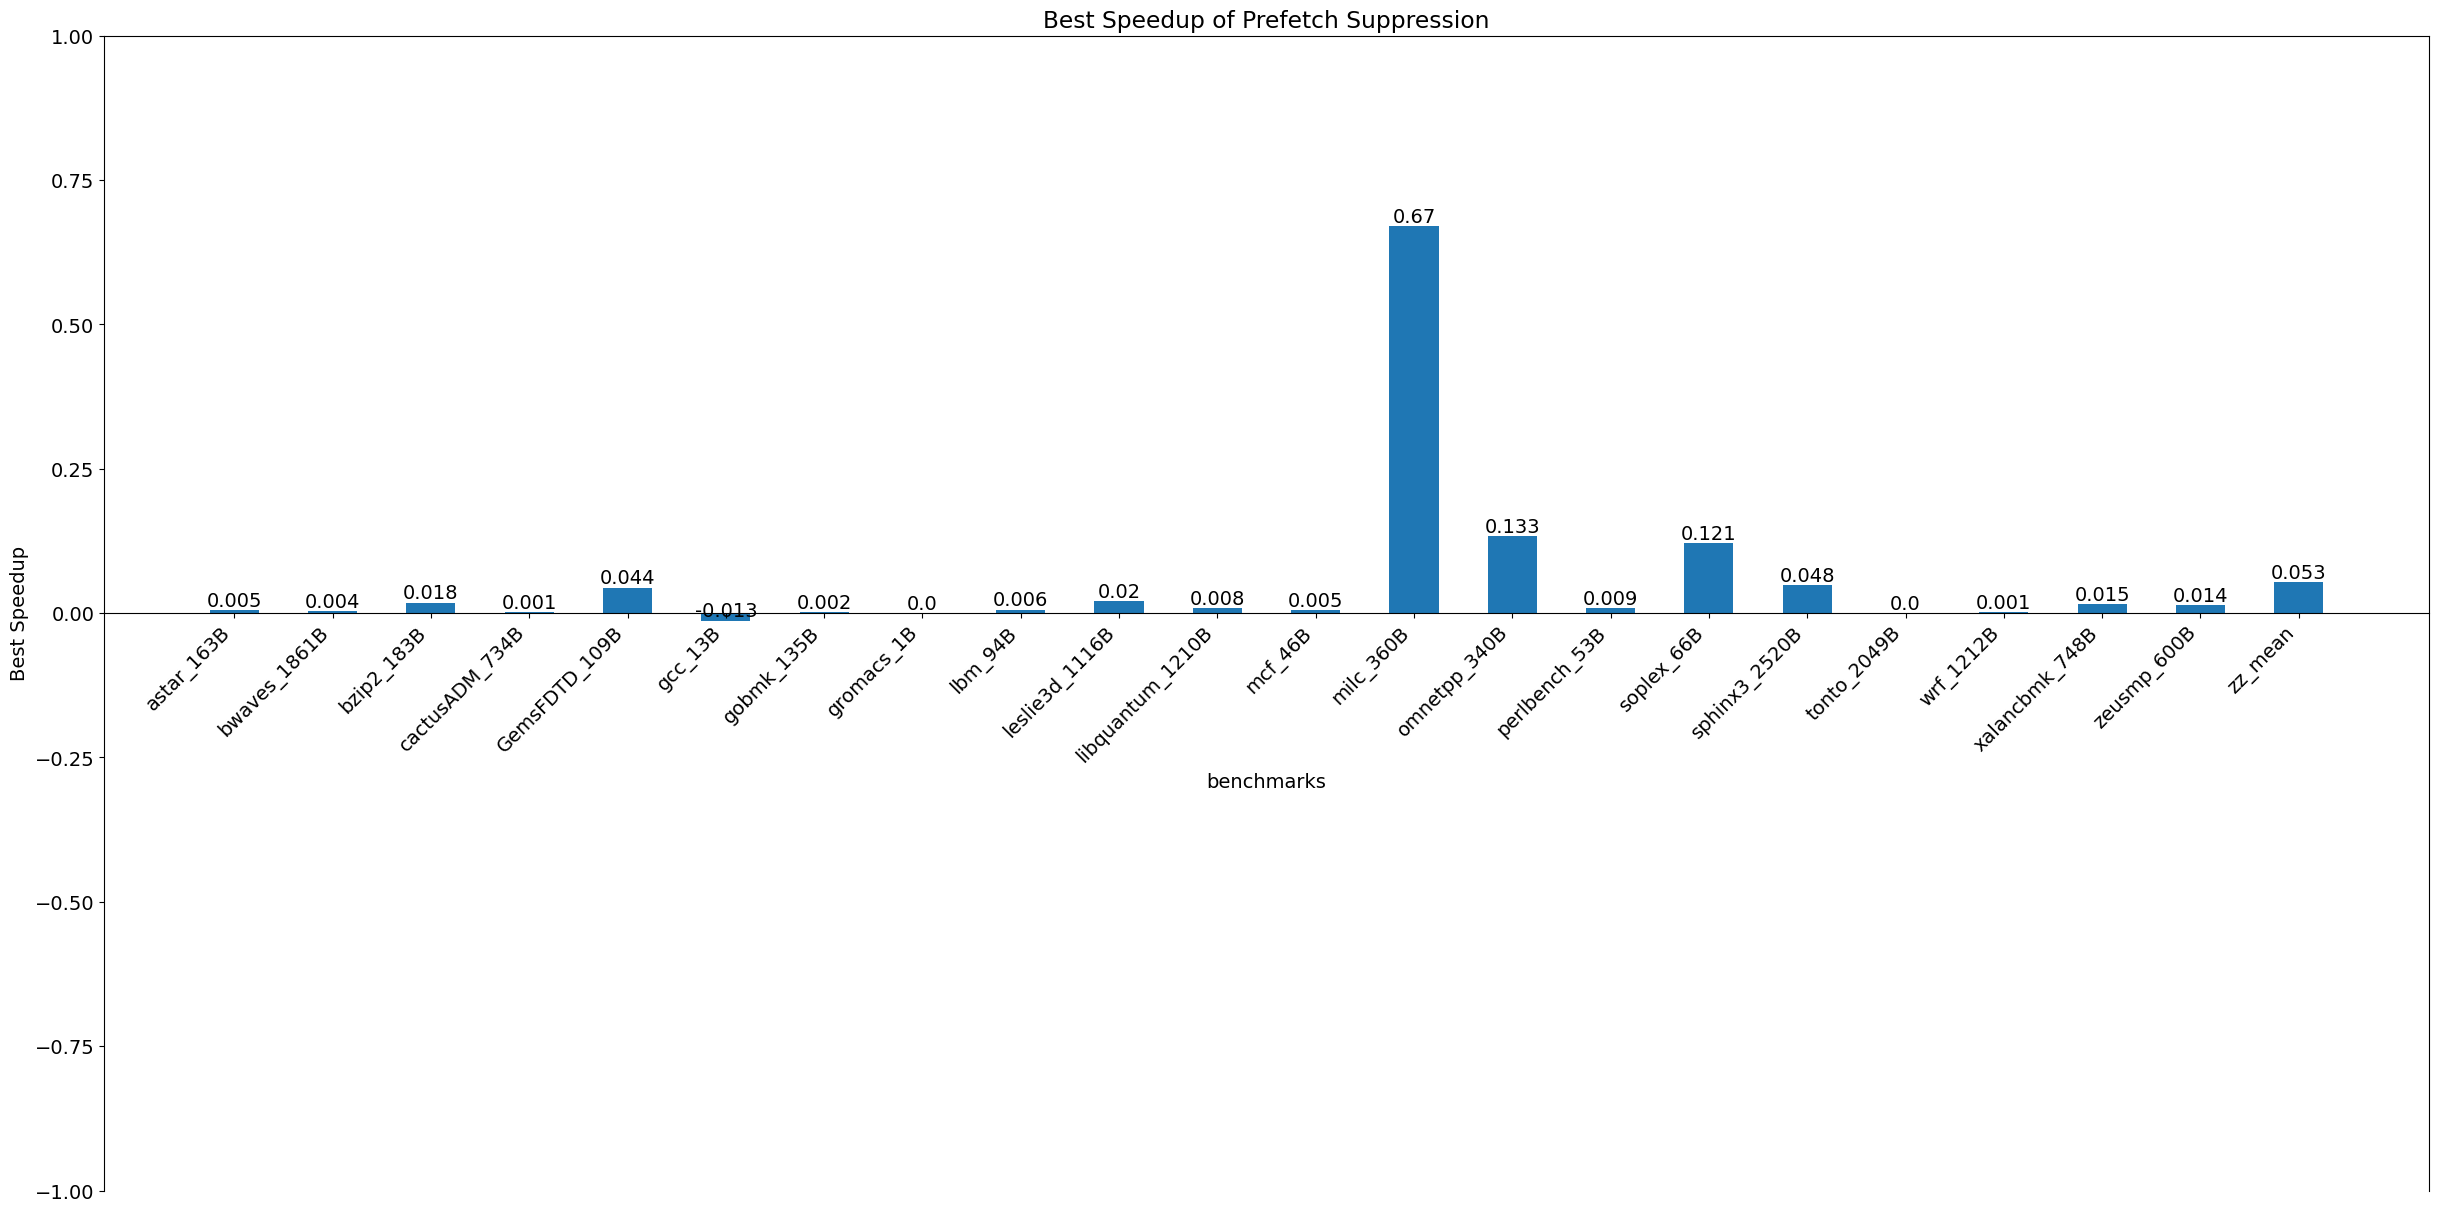

In [48]:
old_speedup = compare_performance(base_trace_files, comp_trace_files, traces)
graph_best_speedup(best_speedup, traces)

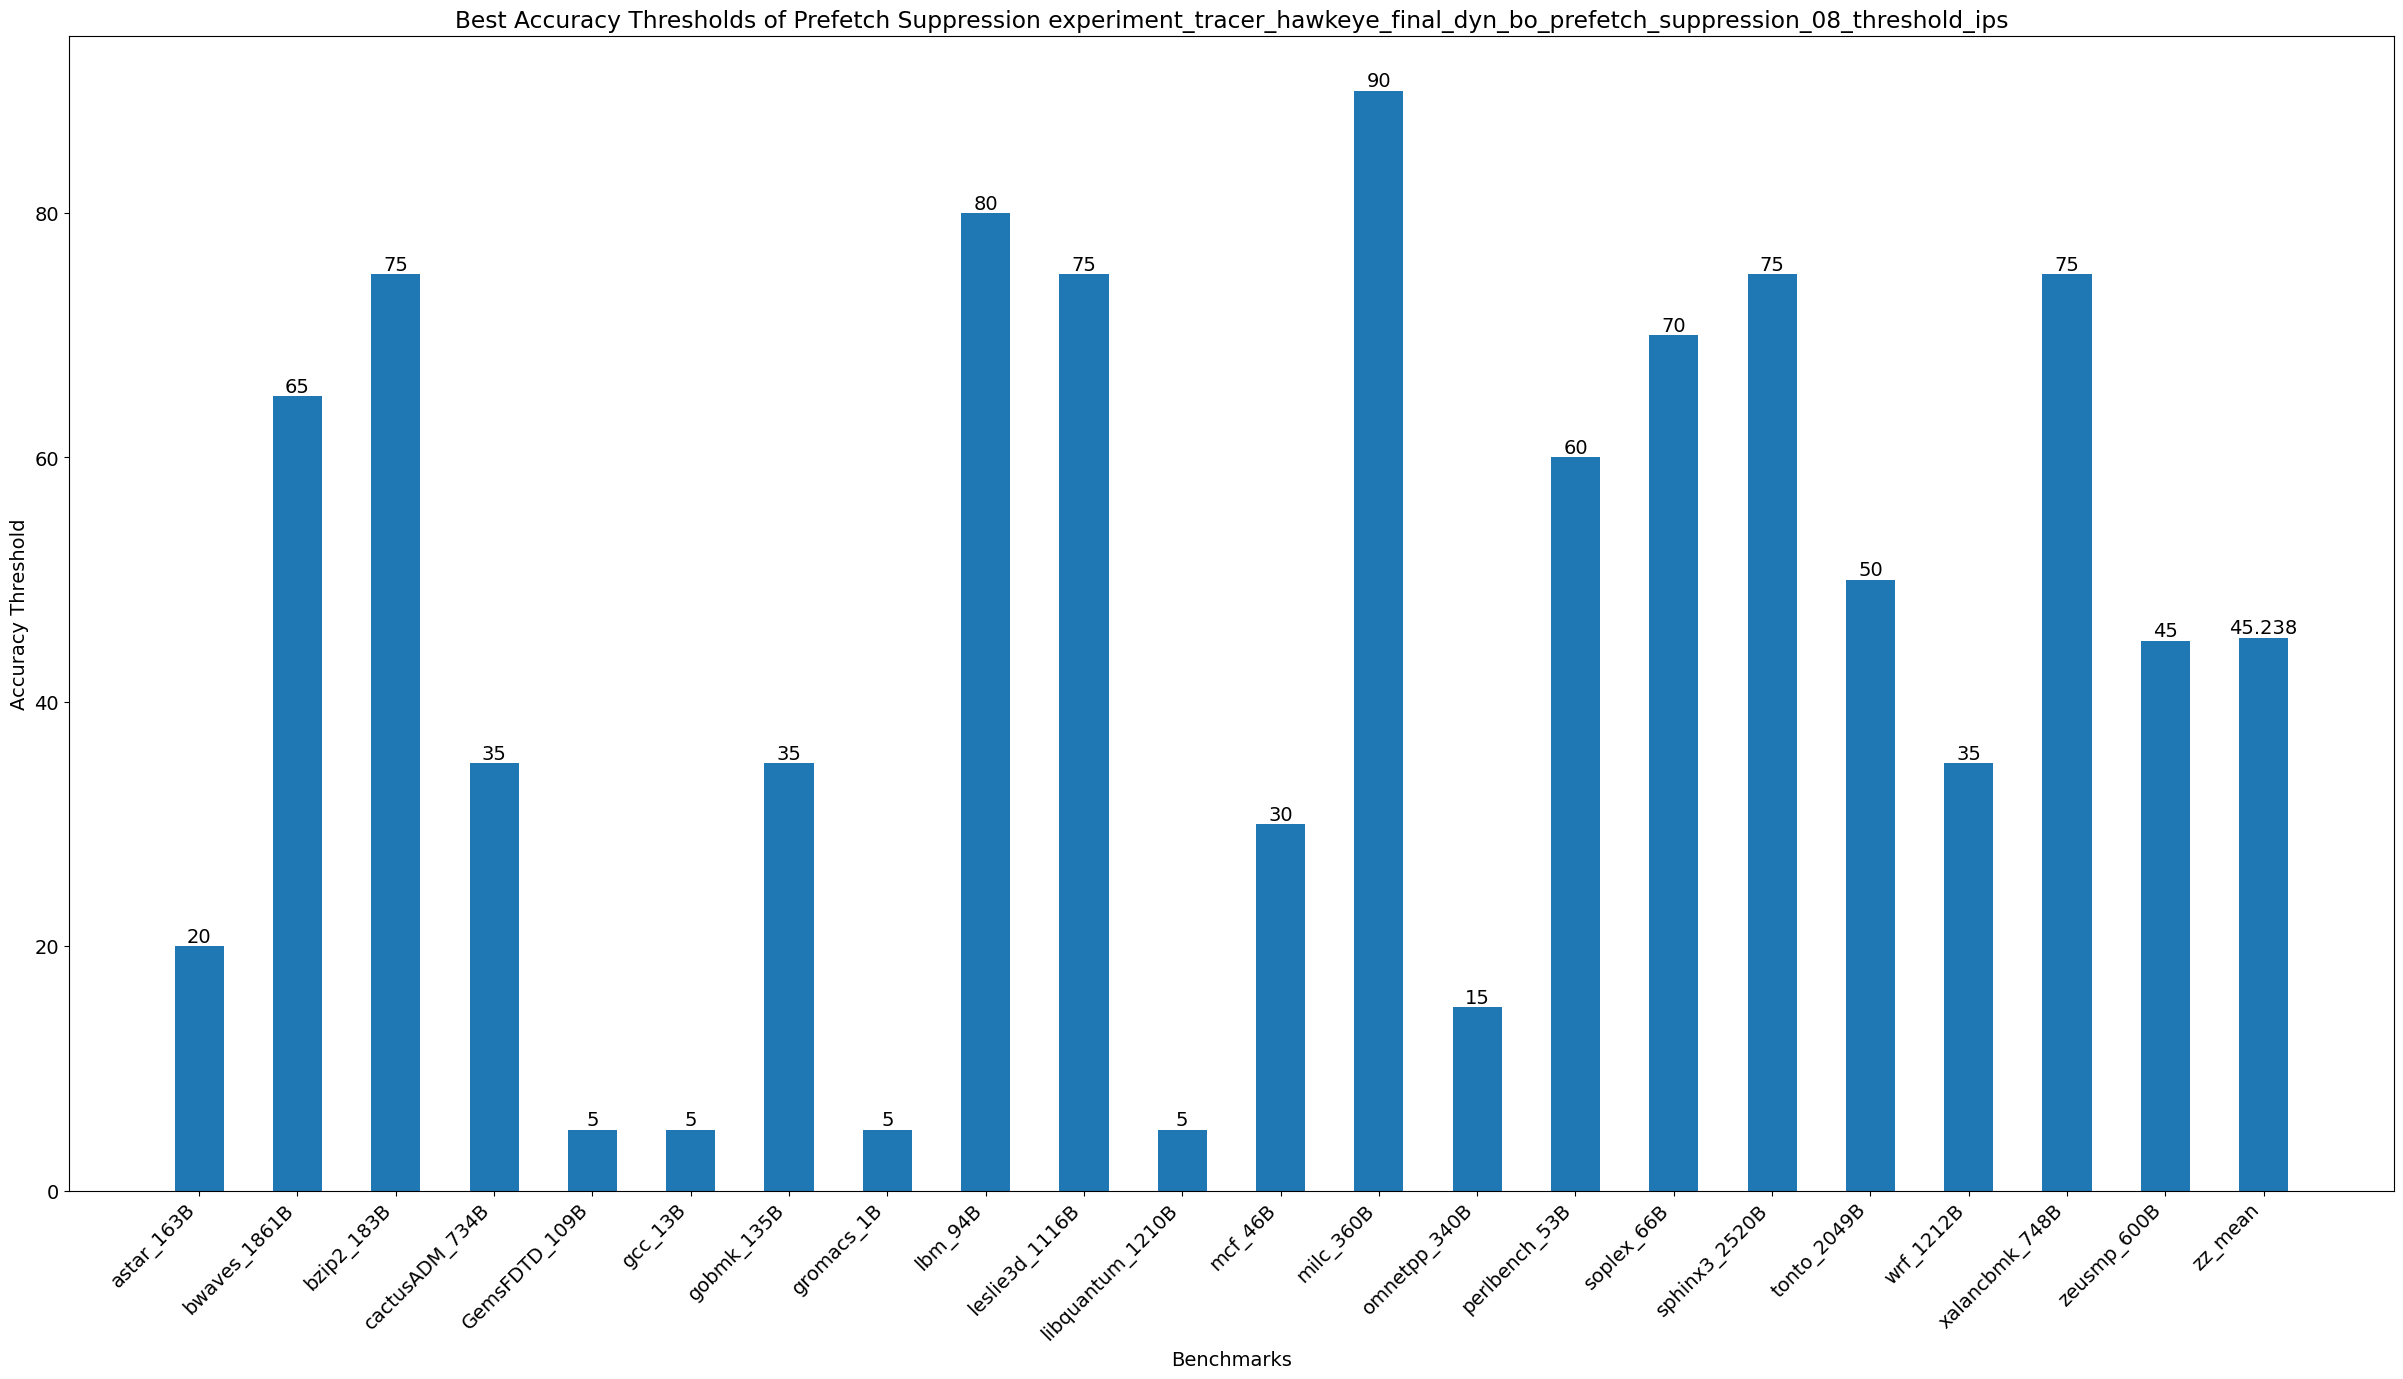

In [31]:
graph_stat(best_accuracy_thresholds, traces, 'Best Accuracy Thresholds of Prefetch Suppression', 'Accuracy Threshold', cmp_experiment)

In [73]:
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetching_memory_traffic'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

In [74]:
memory_traffic_no_prefetching = get_memory_traffic(base_trace_files)
print(memory_traffic_no_prefetching)

[1.664, 23.052, 1.574, 7.922, 37.756, 20.551, 0.343, 0.113, 37.826, 28.68, 35.539, 64.581, 29.419, 20.325, 0.276, 24.954, 5.806, 0.102, 1.784, 3.661, 3.365]


In [75]:
avg_dram_latency_no_prefetching = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_no_prefetching)

[116.508, 1078.64, 438.748, 408.618, 630.167, 220.621, 171.045, 163.087, 471.255, 681.671, 130.821, 419.331, 280.378, 138.724, 146.477, 326.403, 173.105, 207.933, 416.37, 116.35, 142.922]


In [76]:
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_no_prefetch_suppression_memory_traffic/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

In [77]:
memory_traffic_prefetching = get_memory_traffic(base_trace_files)
print(memory_traffic_prefetching)

[3.363, 27.718, 2.659, 9.423, 52.724, 39.913, 0.803, 0.119, 44.375, 33.877, 46.48, 85.513, 61.857, 55.19, 1.224, 52.079, 11.547, 0.191, 2.171, 4.907, 4.096]


In [78]:
avg_dram_latency_prefetching = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_prefetching)

[161.135, 1383.02, 640.567, 520.371, 1134.47, 275.56, 232.161, 195.544, 985.651, 1073.65, 414.543, 407.015, 912.483, 280.984, 175.717, 686.682, 355.29, 231.031, 843.62, 199.052, 315.832]


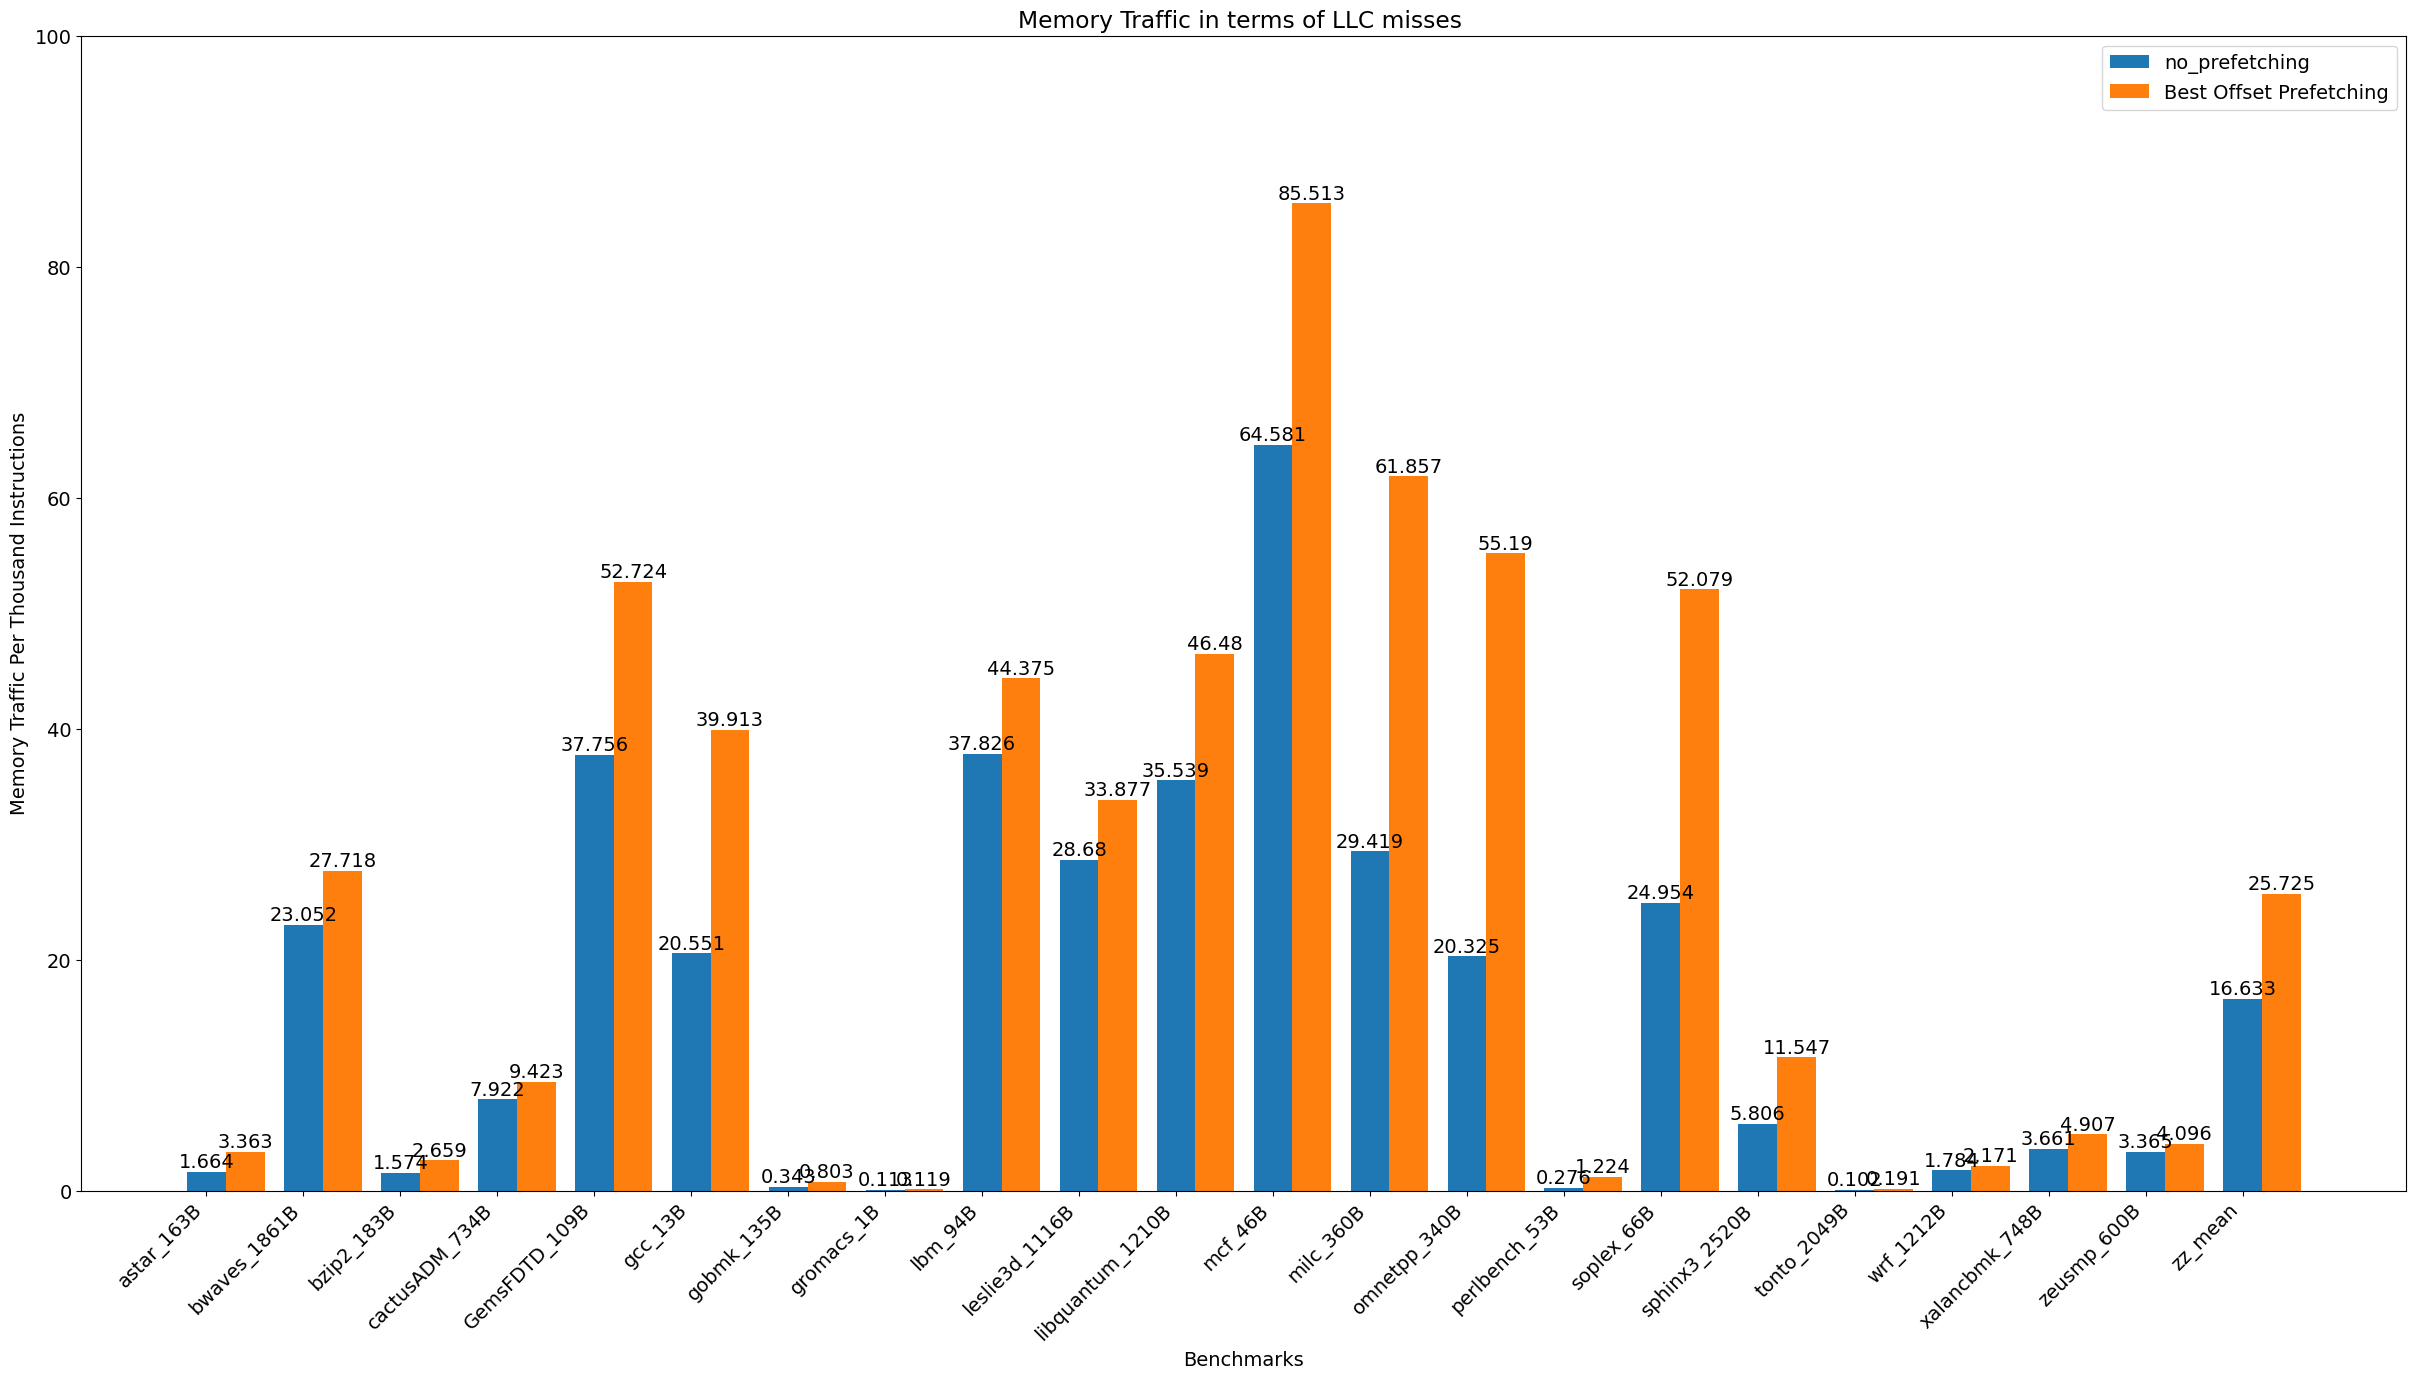

In [79]:
graph_two_stats(memory_traffic_no_prefetching, memory_traffic_prefetching, traces, 'Memory Traffic in terms of LLC misses',
                'Memory Traffic Per Thousand Instructions', '', 'no_prefetching', 'Best Offset Prefetching', 0, 100)

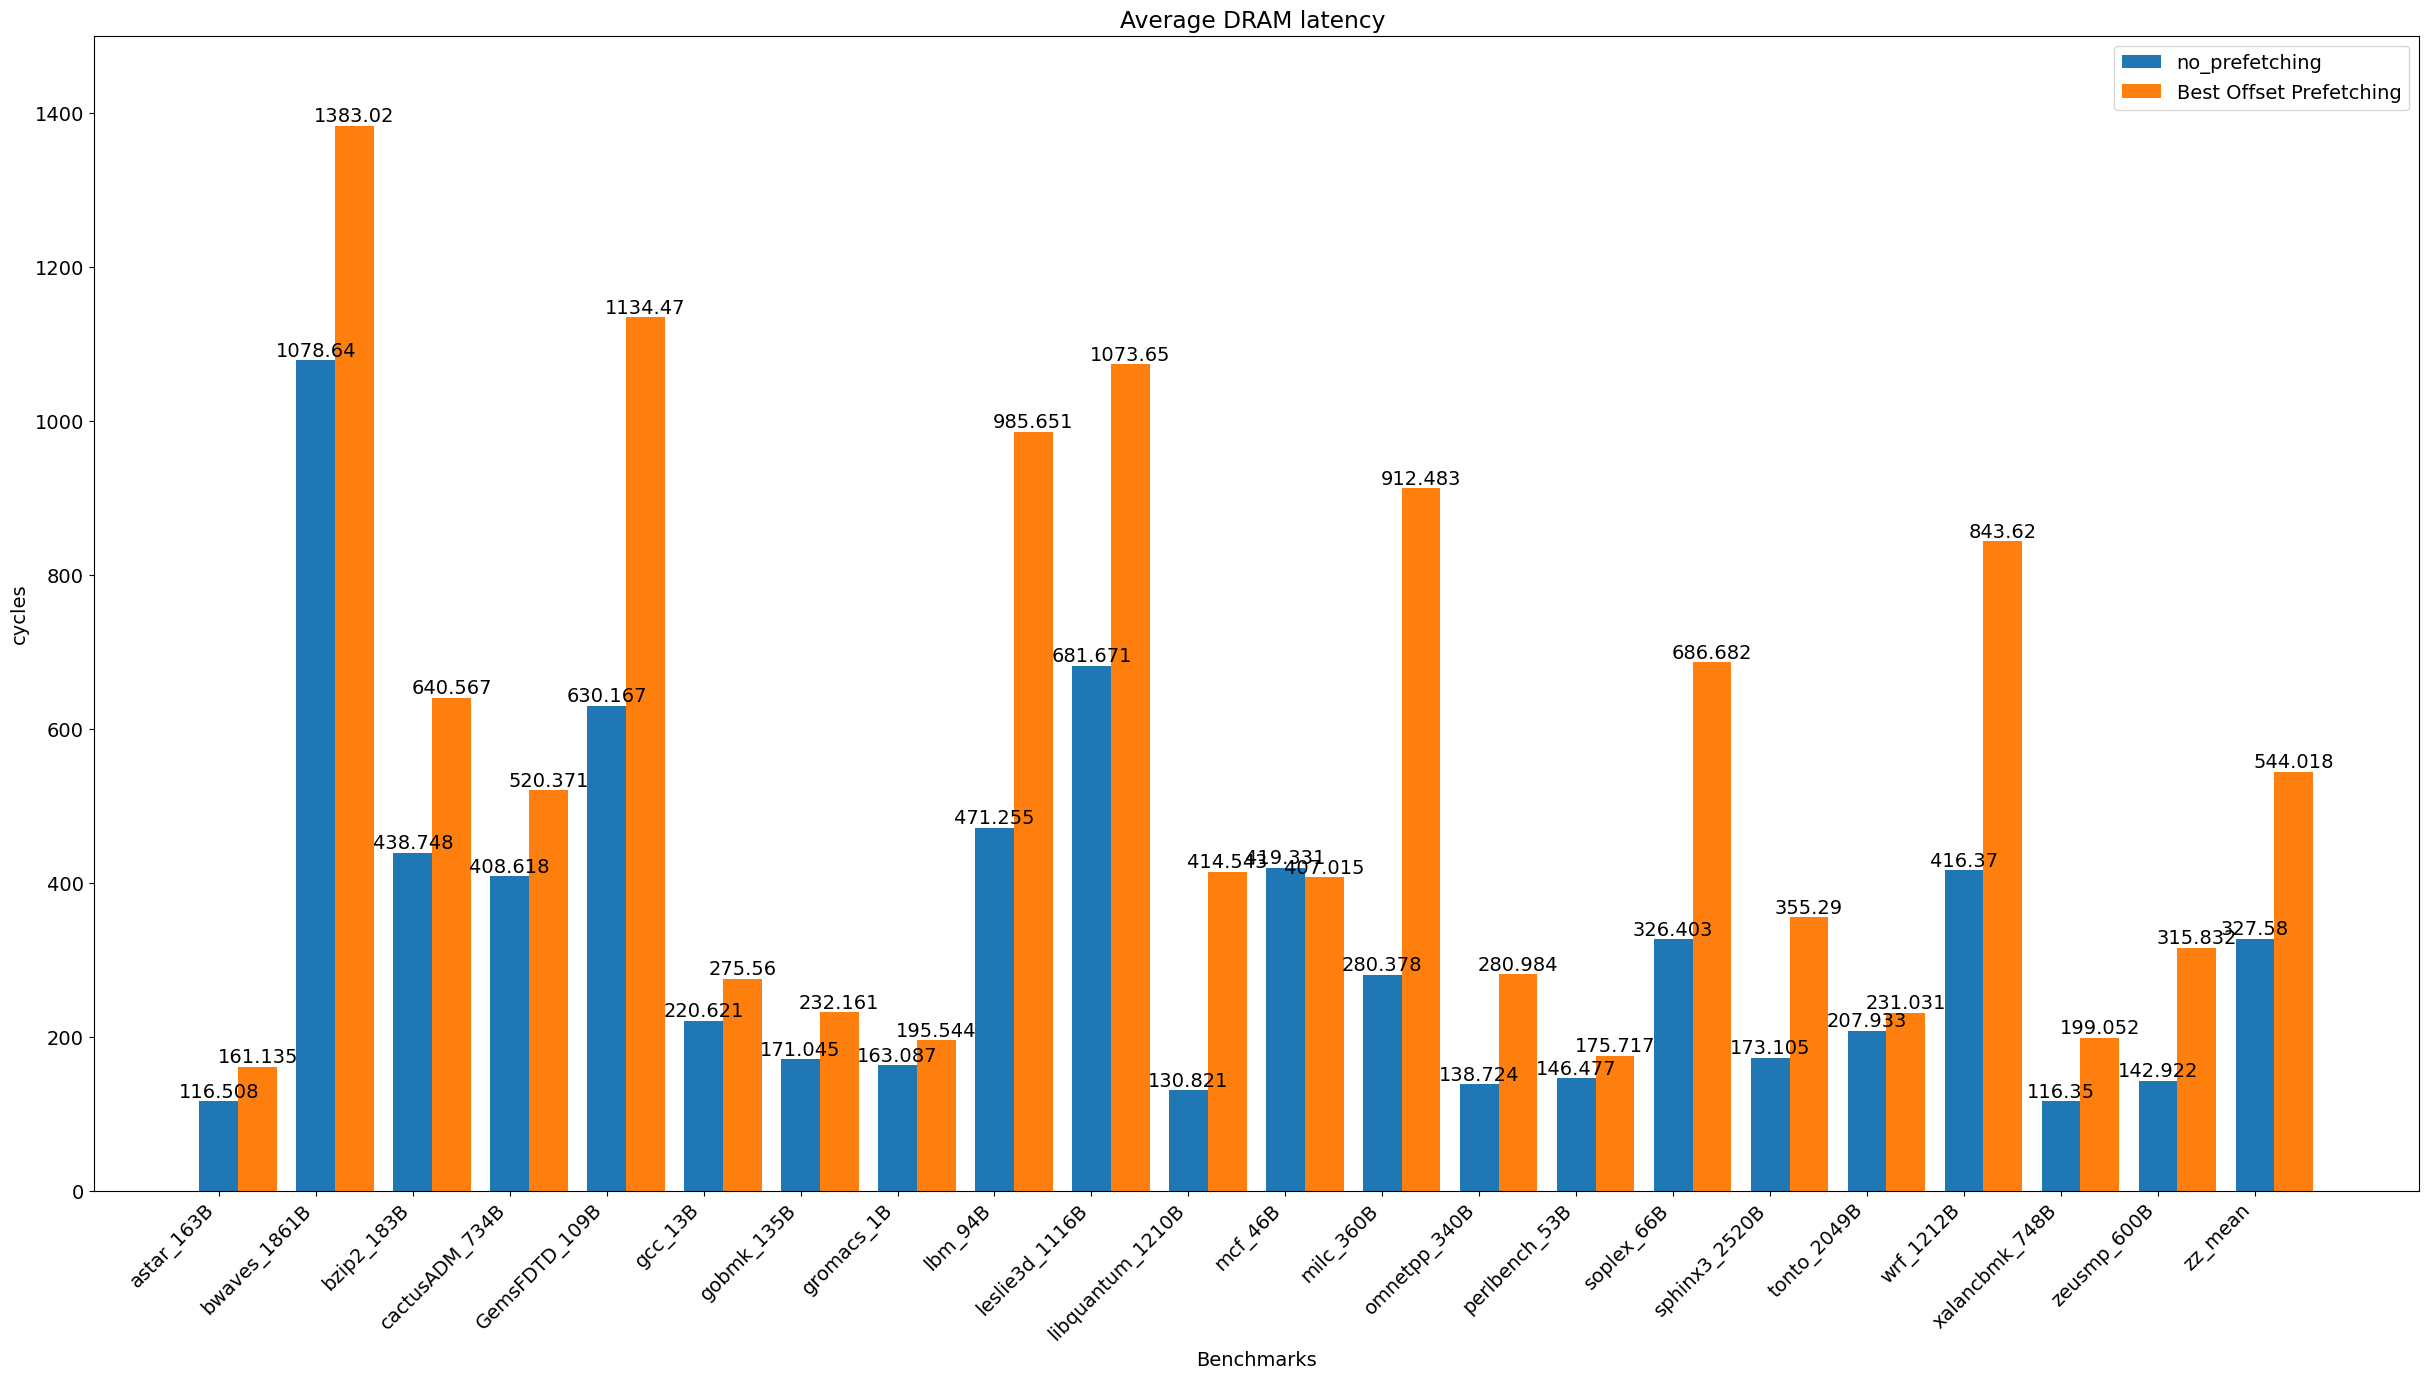

In [80]:
graph_two_stats(avg_dram_latency_no_prefetching, avg_dram_latency_prefetching, traces, 'Average DRAM latency',
                'cycles', '', 'no_prefetching', 'Best Offset Prefetching', 0, 1500)

In [34]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetching_memory_traffic'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_full_bandwidth'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

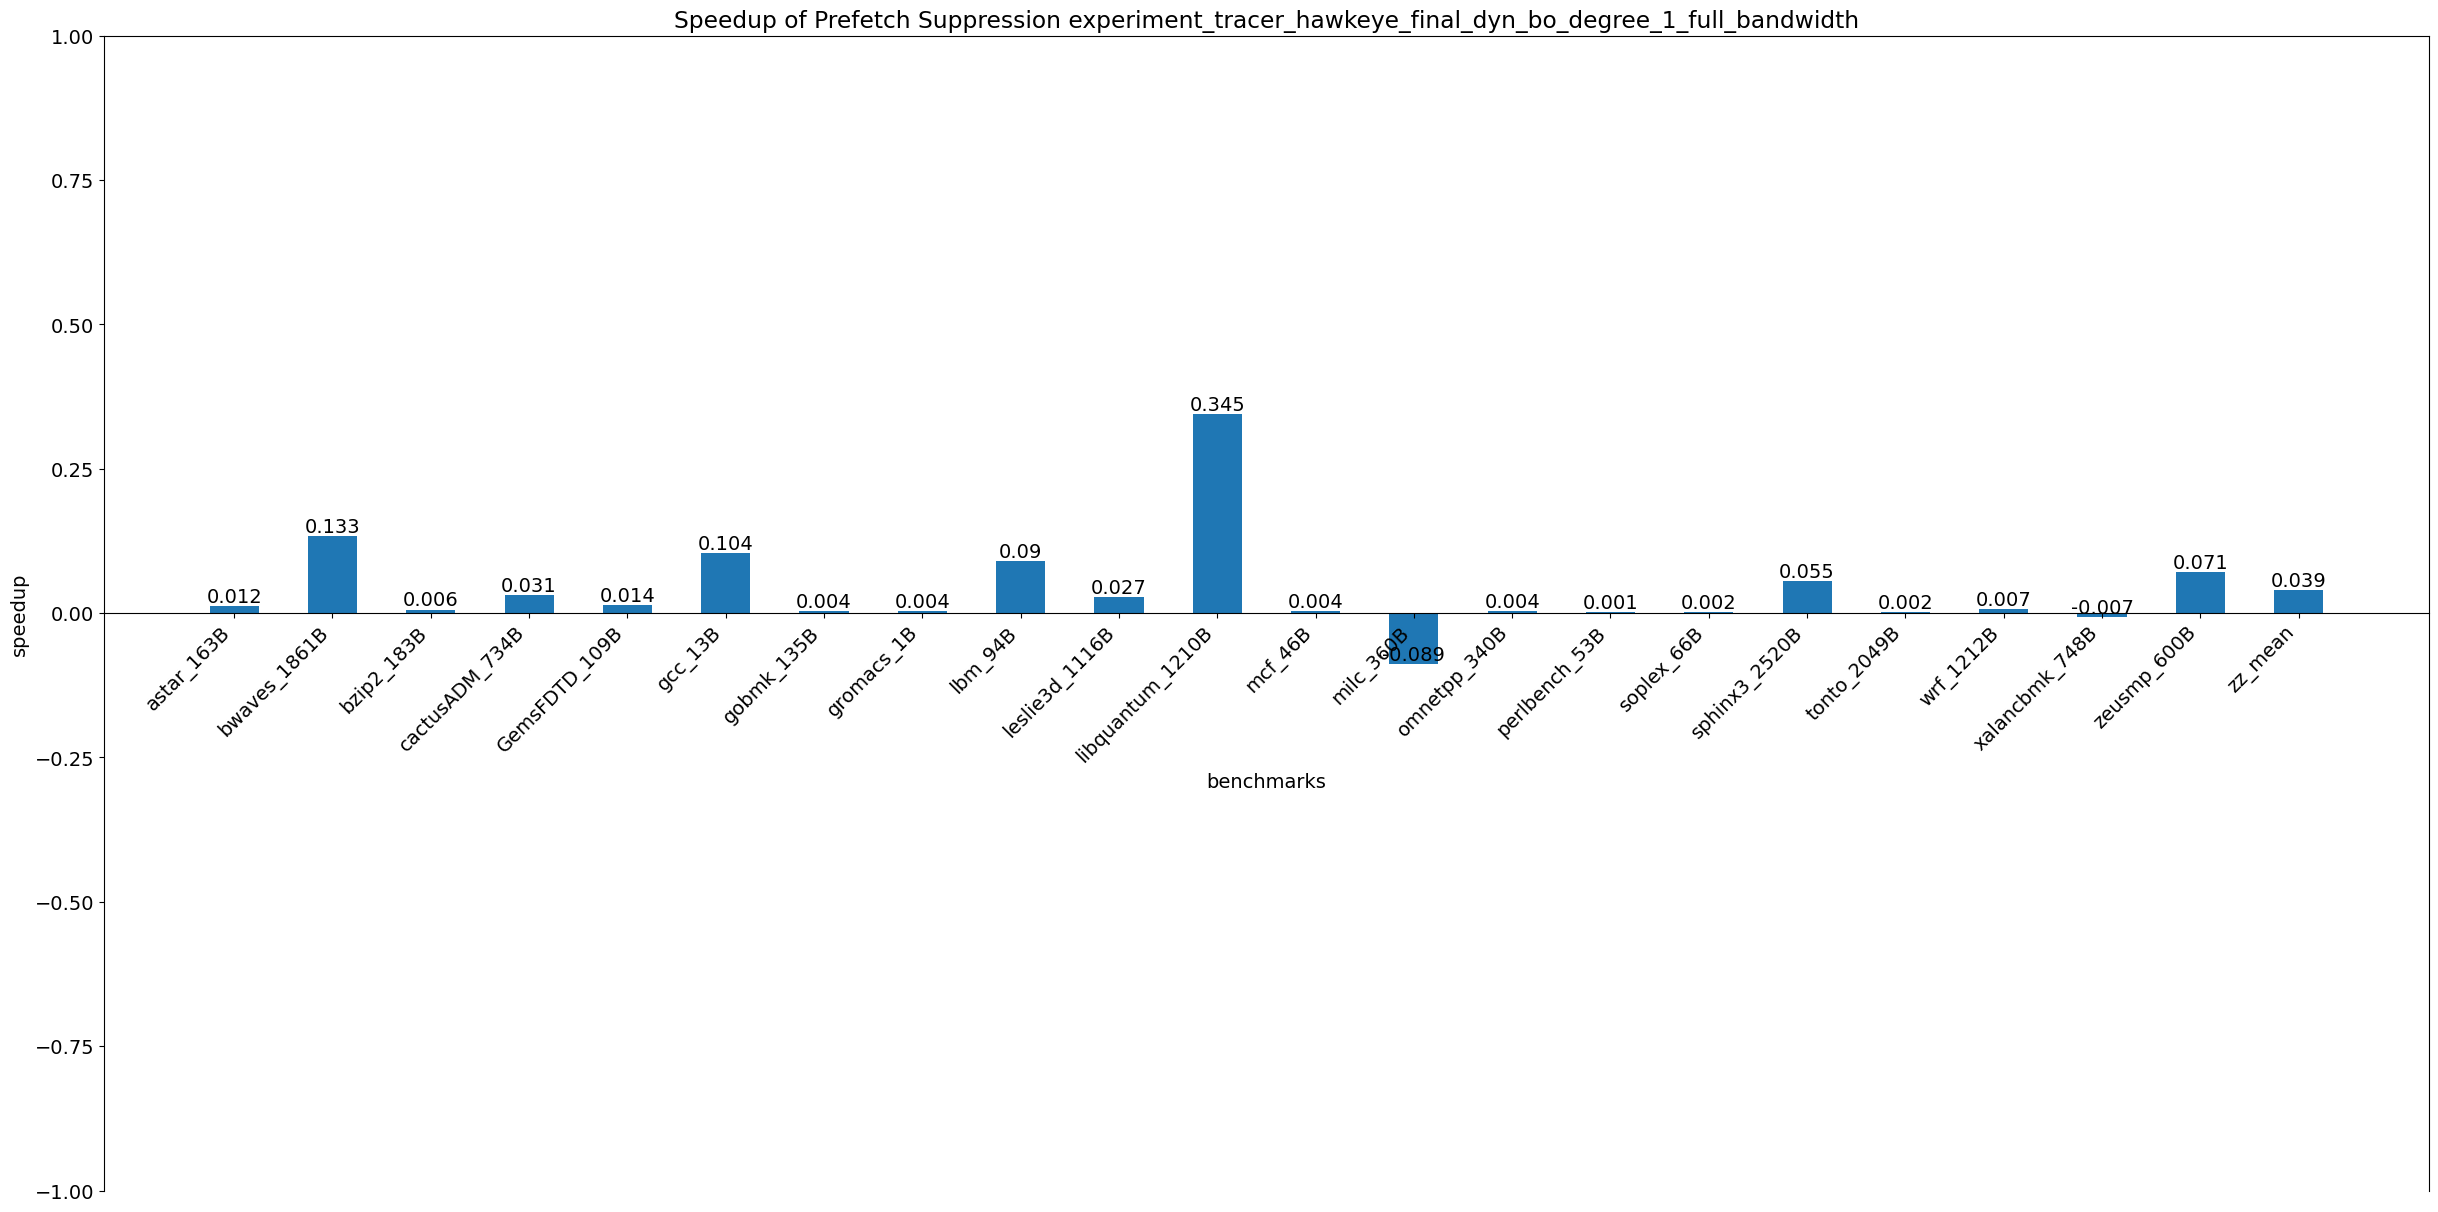

In [35]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [26]:
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetching_memory_traffic/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

In [27]:
memory_traffic_no_prefetching = get_memory_traffic(base_trace_files)
print(memory_traffic_no_prefetching)

[1.664, 23.052, 1.574, 7.922, 37.756, 20.551, 0.343, 0.113, 37.826, 28.68, 35.539, 64.581, 29.419, 20.325, 0.276, 24.954, 5.806, 0.102, 1.784, 3.661, 3.365]


In [28]:
avg_dram_latency_no_prefetching = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_no_prefetching)

[116.508, 1078.64, 438.748, 408.618, 630.167, 220.621, 171.045, 163.087, 471.255, 681.671, 130.821, 419.331, 280.378, 138.724, 146.477, 326.403, 173.105, 207.933, 416.37, 116.35, 142.922]


In [29]:
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_full_bandwidth'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

In [30]:
memory_traffic_prefetching = get_memory_traffic(base_trace_files)
print(memory_traffic_prefetching)

[2.115, 24.6, 1.829, 8.279, 40.373, 27.328, 0.493, 0.114, 40.078, 29.995, 39.255, 68.554, 35.611, 28.903, 0.401, 32.084, 7.175, 0.124, 1.917, 3.963, 3.515]


In [31]:
avg_dram_latency_prefetching = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_prefetching)

[128.386, 1626.66, 487.172, 522.362, 851.981, 231.219, 155.677, 170.933, 645.22, 649.205, 177.413, 413.383, 363.305, 165.467, 147.229, 412.753, 233.24, 217.866, 546.977, 131.961, 188.677]


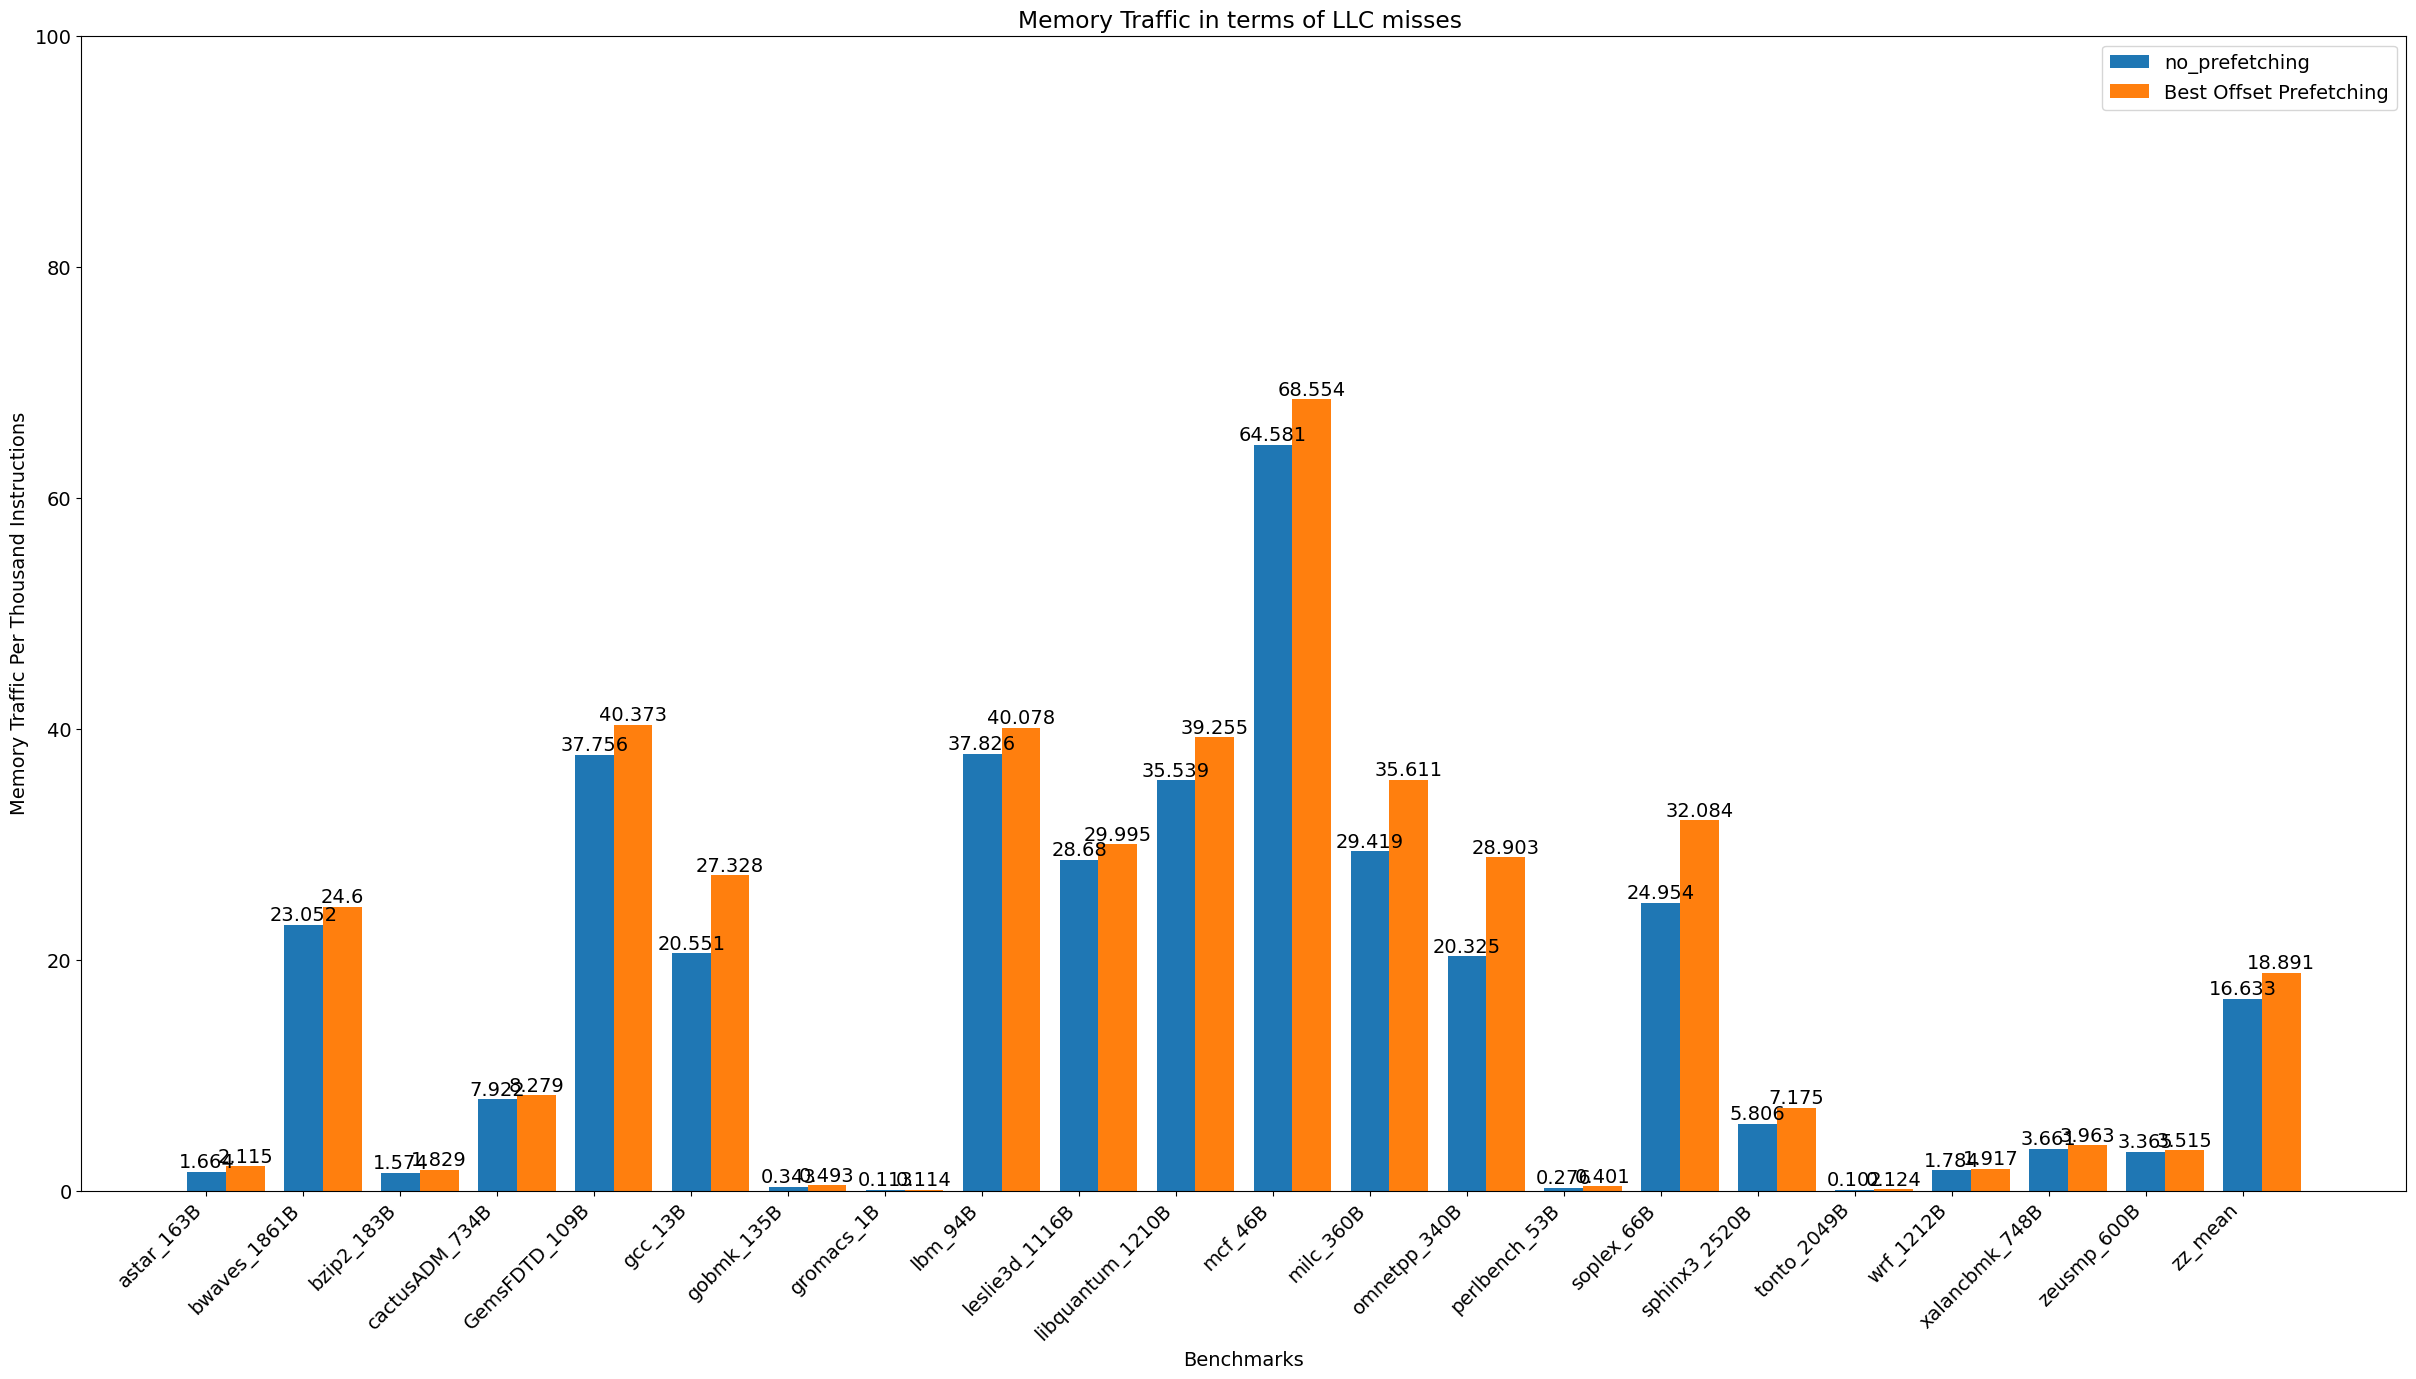

In [32]:
graph_two_stats(memory_traffic_no_prefetching, memory_traffic_prefetching, traces, 'Memory Traffic in terms of LLC misses',
                'Memory Traffic Per Thousand Instructions', '', 'no_prefetching', 'Best Offset Prefetching', 0, 100)

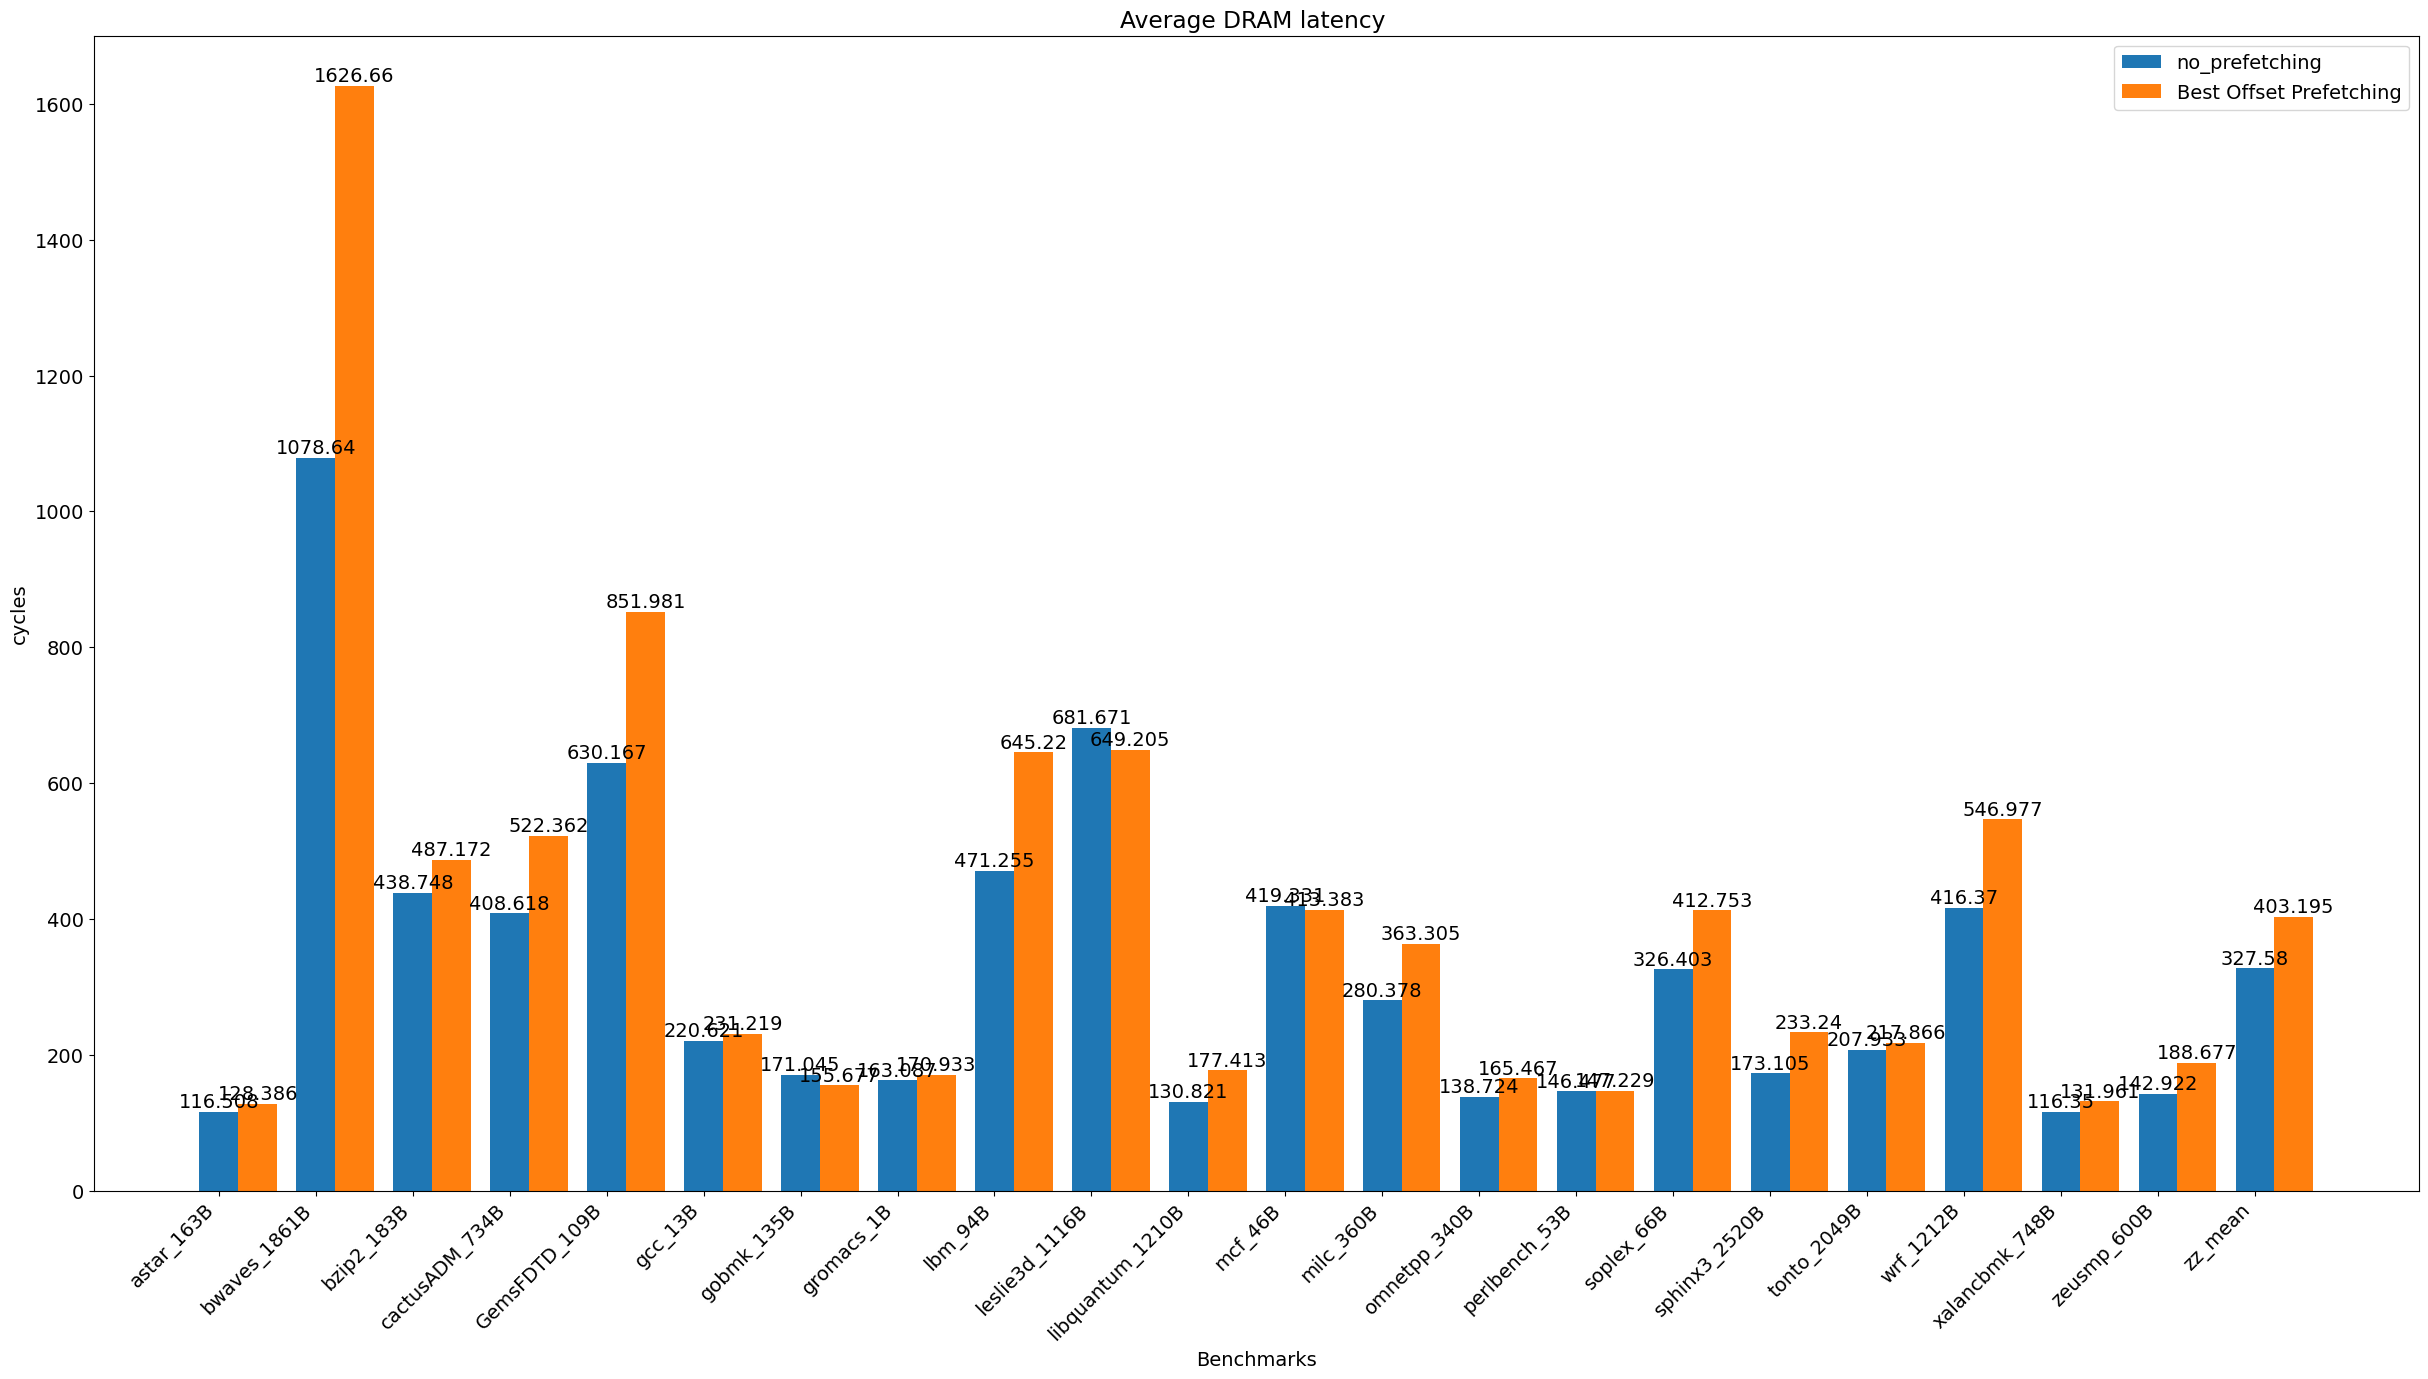

In [33]:
graph_two_stats(avg_dram_latency_no_prefetching, avg_dram_latency_prefetching, traces, 'Average DRAM latency',
                'cycles', '', 'no_prefetching', 'Best Offset Prefetching', 0, 1700)

In [34]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_no_prefetch_suppression_memory_traffic'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_no_prefetch_suppression_half_bandwidth'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

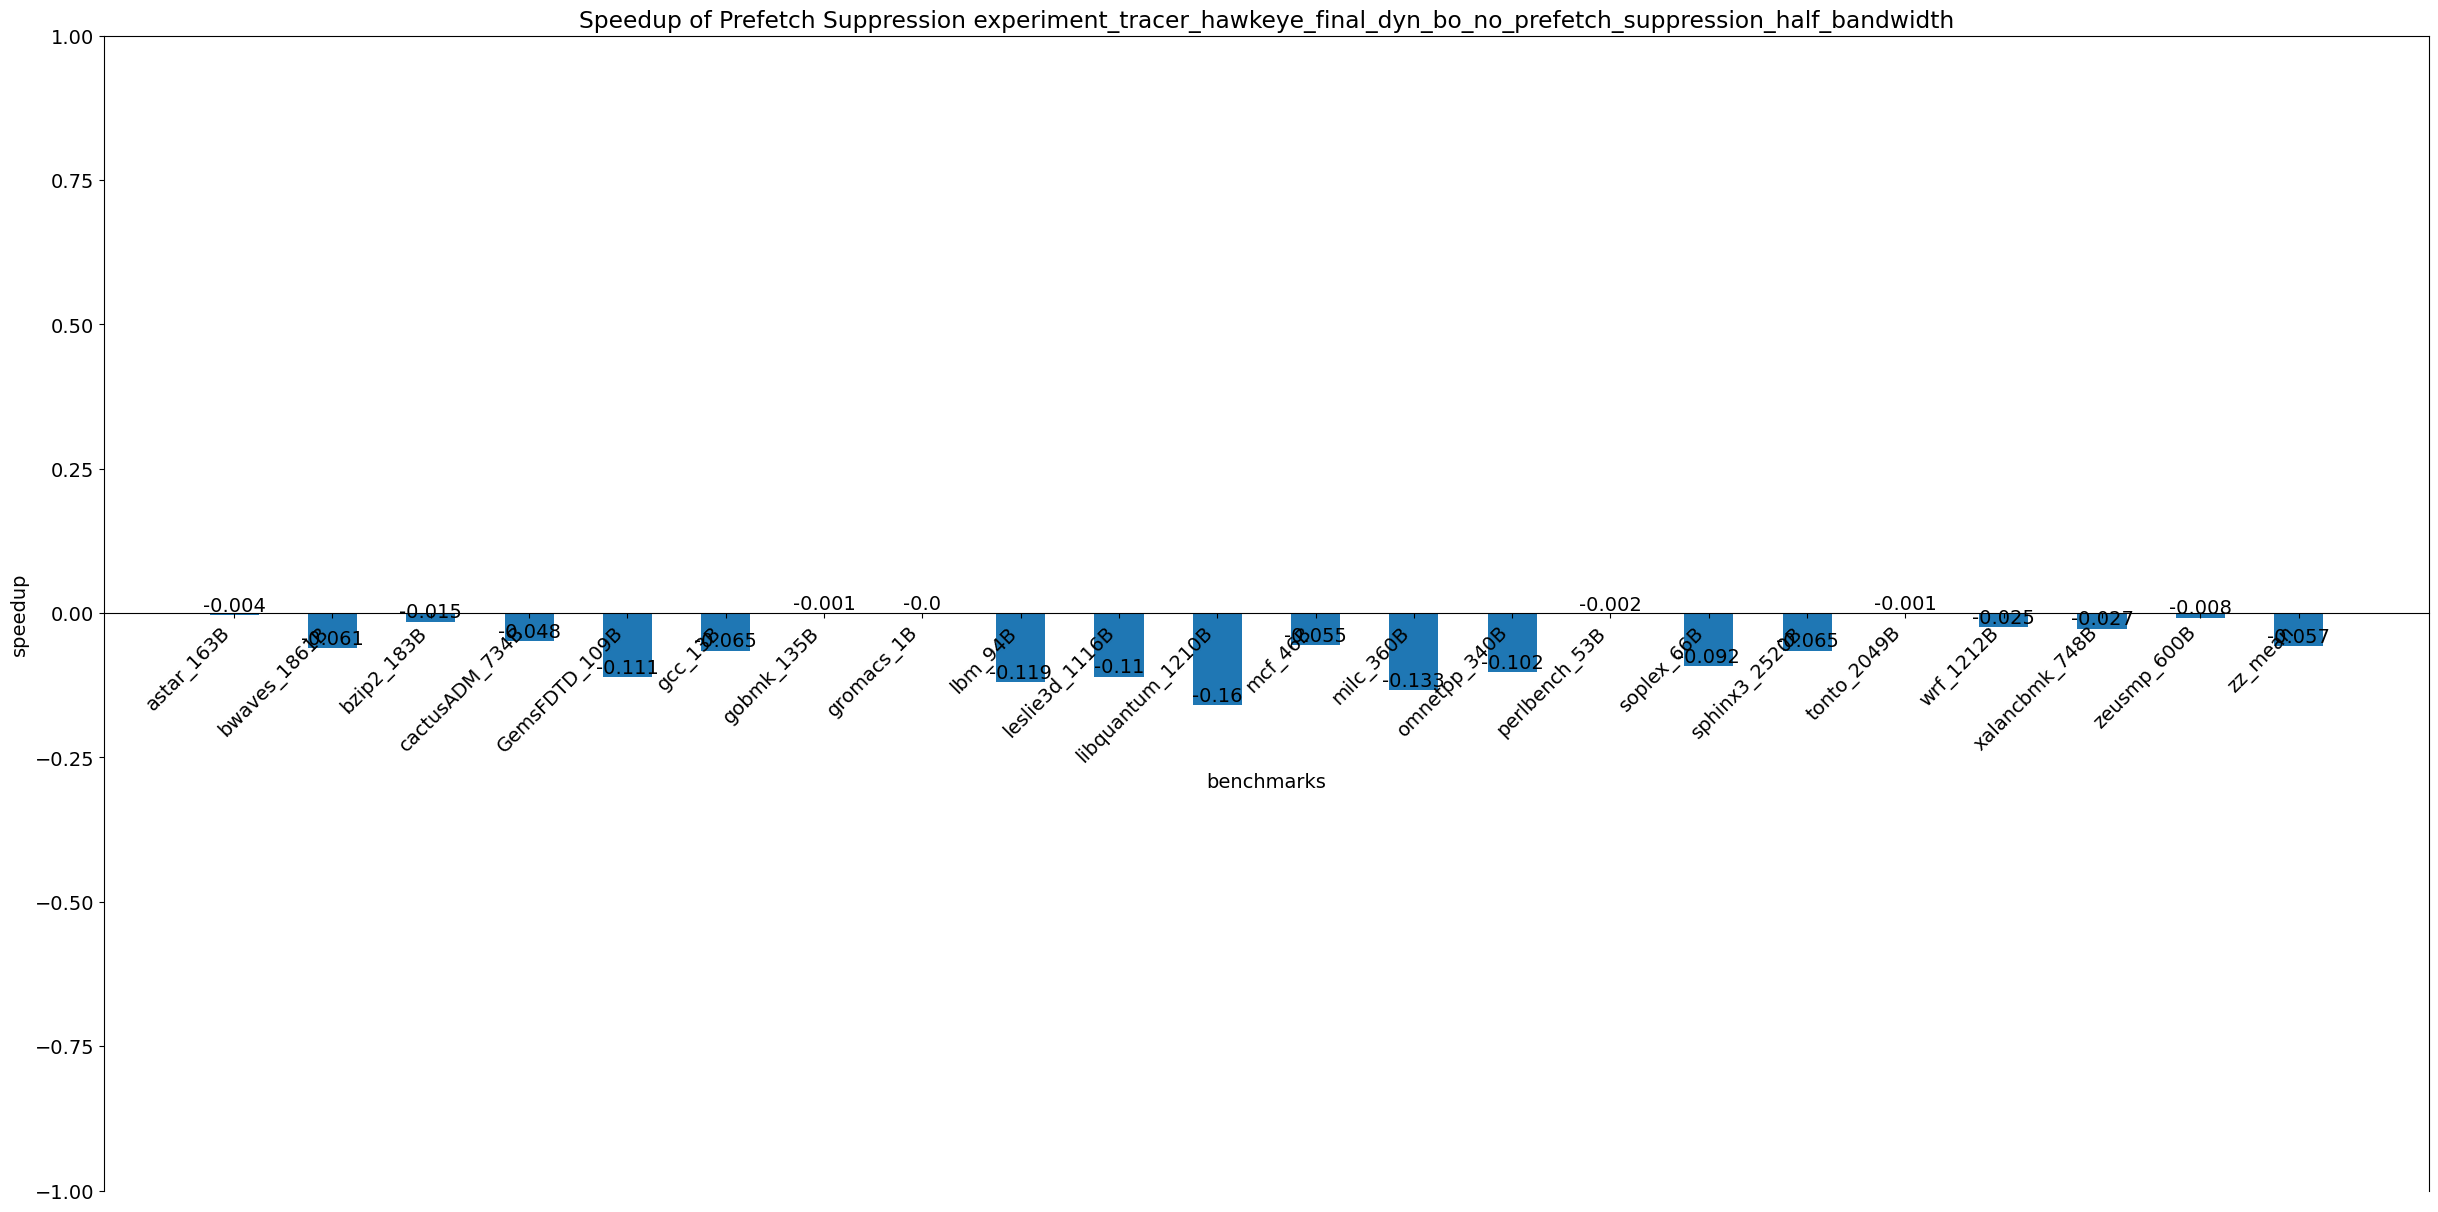

In [55]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

21
21
21
21
21
21
[163.0, 1336.0, 292.5, 354.0, 1403.0, 181.0, 171.0, 163.0, 1464.0, 1105.0, 312.0, 262.0, 1056.0, 232.0, 163.0, 431.0, 304.0, 172.0, 747.0, 171.0, 250.0]
[162.0, 1114.0, 165.0, 346.0, 827.0, 162.0, 162.0, 162.0, 691.0, 649.0, 68.0, 207.0, 280.0, 162.0, 162.0, 199.0, 162.0, 162.0, 484.0, 163.0, 162.0]
[180.0, 1499.0, 311.0, 439.0, 1614.0, 219.0, 192.0, 174.0, 1676.0, 1310.0, 482.0, 273.0, 1240.0, 292.0, 174.0, 492.0, 351.0, 211.0, 937.0, 230.0, 290.0]
[252.0, 1807.0, 508.0, 607.0, 2010.0, 303.0, 255.0, 213.0, 2105.0, 1730.0, 862.0, 329.0, 1595.0, 424.0, 217.0, 685.0, 513.0, 292.0, 1158.0, 334.0, 504.0]
[173.0, 1186.0, 182.0, 420.0, 918.0, 174.0, 173.0, 173.0, 785.0, 772.0, 172.0, 238.0, 314.0, 174.0, 173.0, 279.0, 173.0, 173.0, 567.0, 248.0, 174.0]
[194.0, 1327.0, 228.0, 559.0, 1101.0, 195.0, 195.0, 195.0, 991.0, 1008.0, 234.0, 280.0, 399.0, 198.0, 194.0, 339.0, 196.0, 195.0, 713.0, 414.0, 196.0]


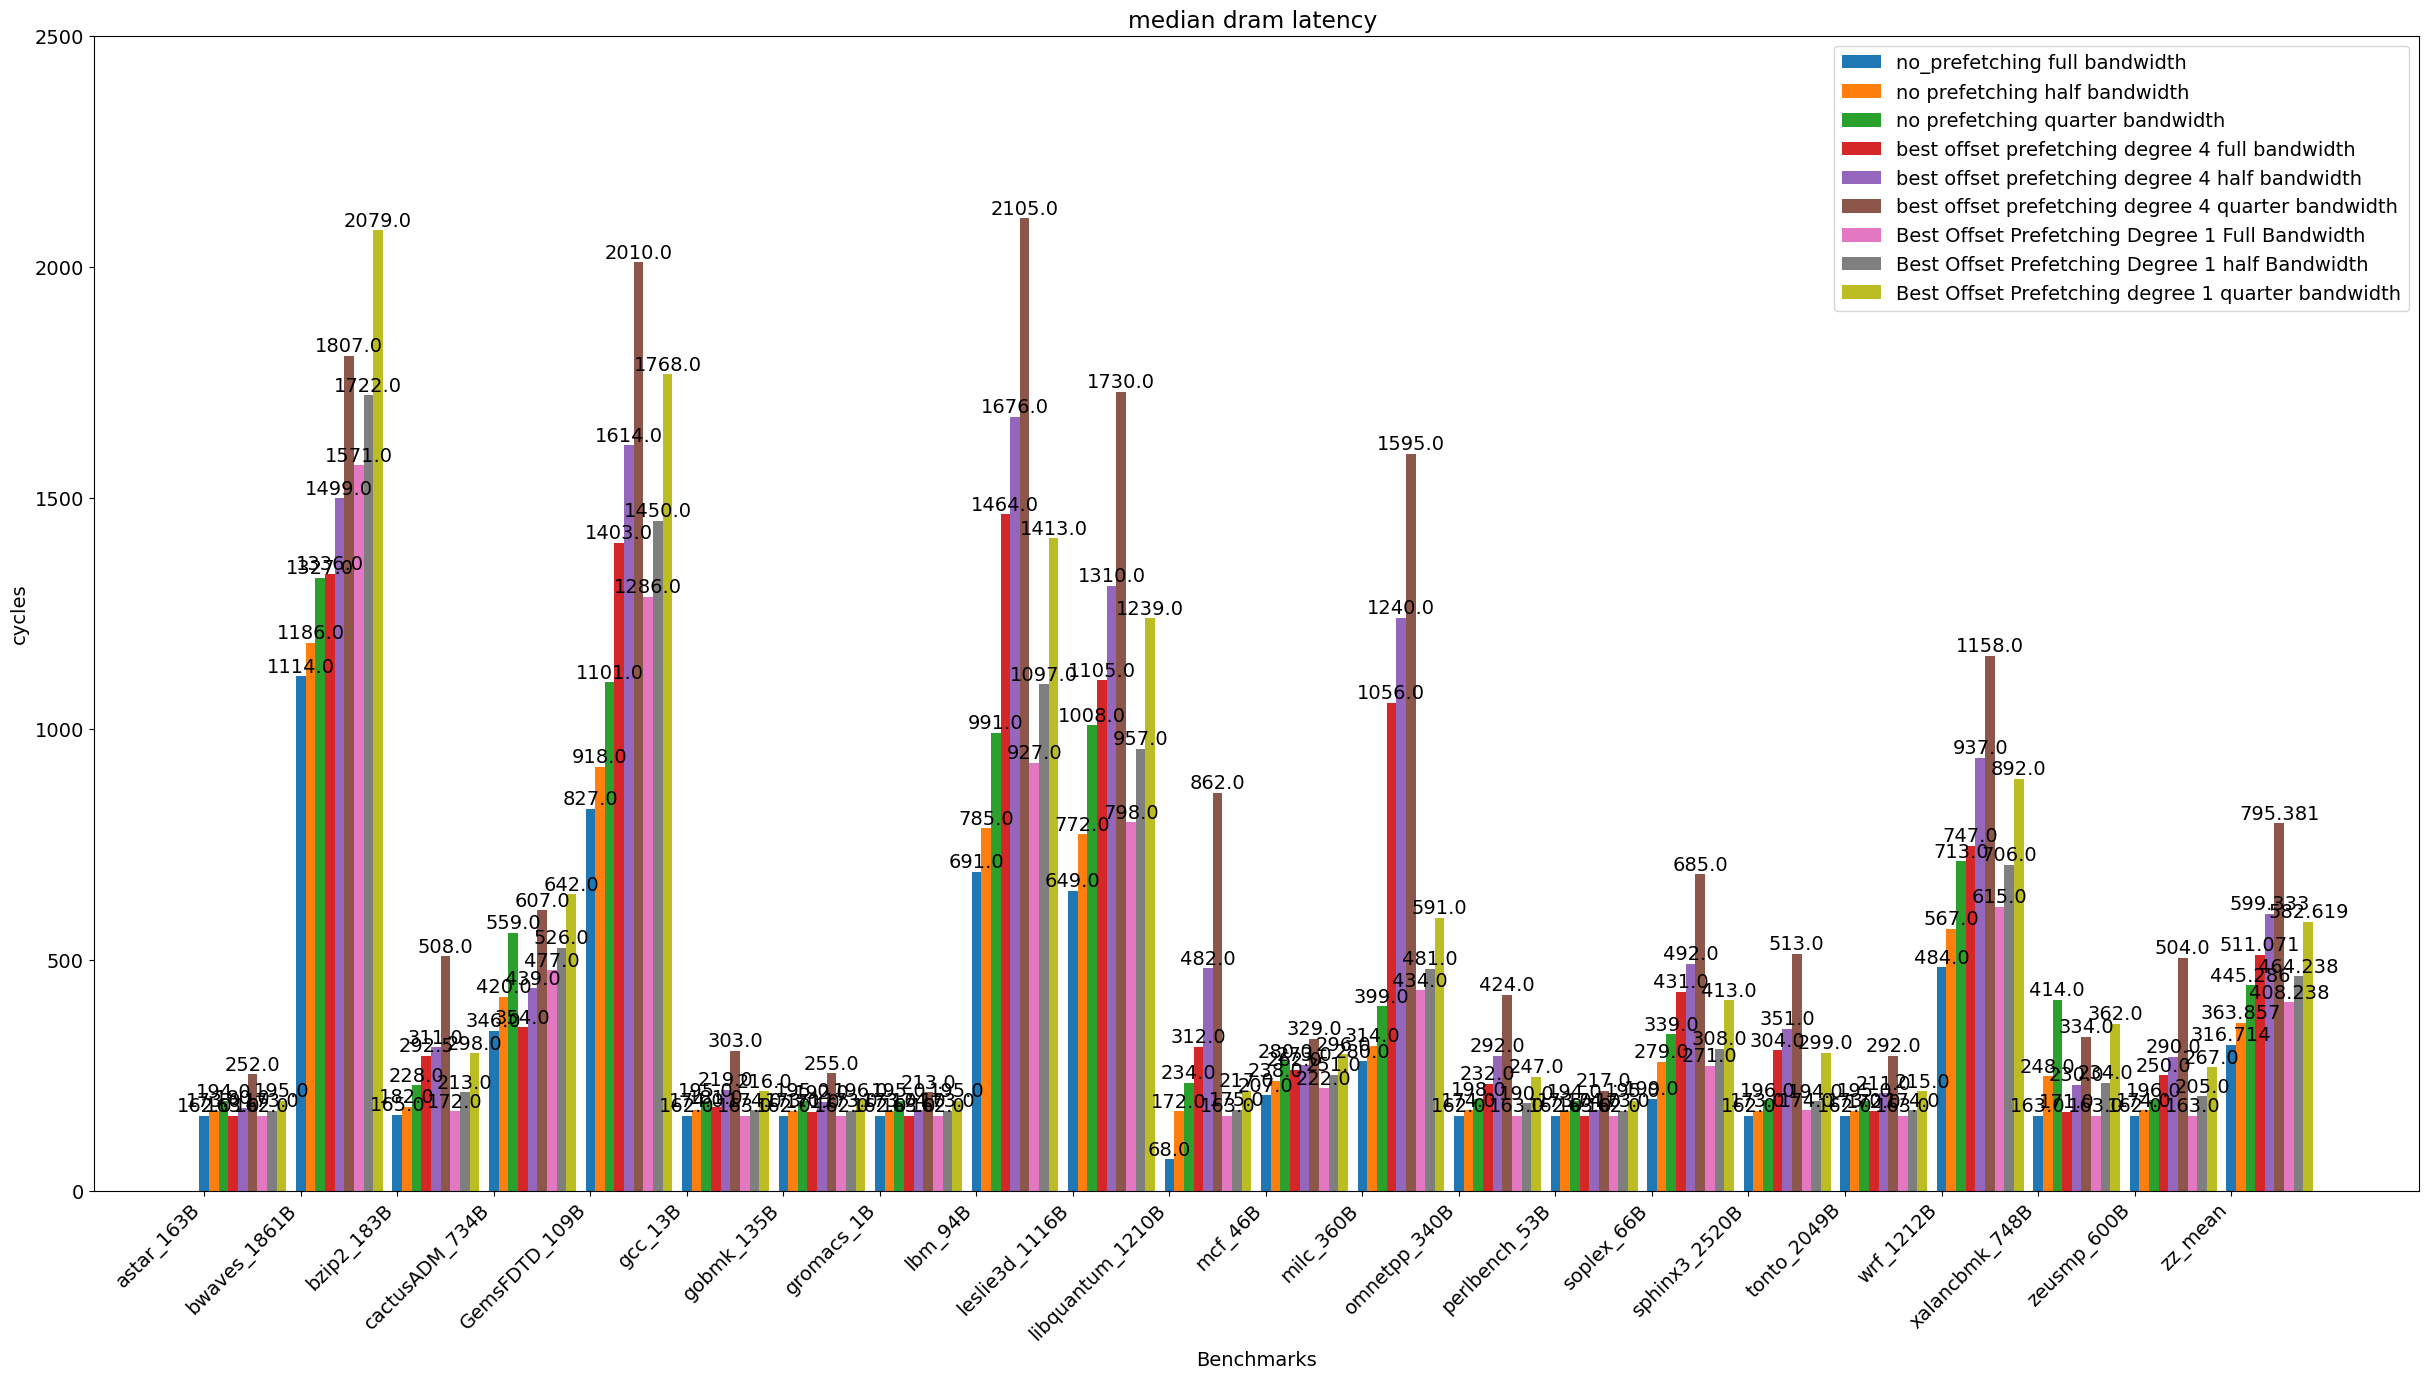

In [67]:
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_full_bandwidth_no_prefetch_suppression/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

memory_traffic_prefetching_full = get_memory_traffic(base_trace_files)
print(len(memory_traffic_prefetching_full))

avg_dram_latency_prefetching_full = get_average_DRAM_latency(base_trace_files)
print(len(avg_dram_latency_prefetching_full))

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_half_bandwidth_no_prefetch_suppression/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

memory_traffic_prefetching_half = get_memory_traffic(base_trace_files)
print(len(memory_traffic_prefetching_half))

avg_dram_latency_prefetching_half = get_average_DRAM_latency(base_trace_files)
print(len(avg_dram_latency_prefetching_half))

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_quarter_bandwidth_no_prefetch_suppression/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

memory_traffic_prefetching_quarter = get_memory_traffic(base_trace_files)
print(len(memory_traffic_prefetching_quarter))

avg_dram_latency_prefetching_quarter = get_average_DRAM_latency(base_trace_files)
print(len(avg_dram_latency_prefetching_quarter))

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_full_bandwidth_no_prefetch_suppression/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

avg_dram_latency_prefetching = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_prefetching)

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetching_full_bandwidth/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

avg_dram_latency_no_prefetching = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_no_prefetching)

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_half_bandwidth_no_prefetch_suppression/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

avg_dram_latency_prefetching_4_half = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_prefetching_4_half)

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_quarter_bandwidth_no_prefetch_suppression/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

avg_dram_latency_prefetching_4_quarter = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_prefetching_4_quarter)

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetching_half_bandwidth/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

avg_dram_latency_no_prefetching_half = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_no_prefetching_half)

# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_no_prefetching_quarter_bandwidth/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(experiment, trace_list)

avg_dram_latency_no_prefetching_quarter = get_average_DRAM_latency(base_trace_files)
print(avg_dram_latency_no_prefetching_quarter)

graph_9_stats(avg_dram_latency_no_prefetching, avg_dram_latency_no_prefetching_half, avg_dram_latency_no_prefetching_quarter, avg_dram_latency_prefetching, avg_dram_latency_prefetching_4_half,
              avg_dram_latency_prefetching_4_quarter, avg_dram_latency_prefetching_full, avg_dram_latency_prefetching_half, avg_dram_latency_prefetching_quarter, traces, 'median dram latency',
                'cycles', '', 'no_prefetching full bandwidth', 'no prefetching half bandwidth', 'no prefetching quarter bandwidth', 'best offset prefetching degree 4 full bandwidth', 
              'best offset prefetching degree 4 half bandwidth', 'best offset prefetching degree 4 quarter bandwidth', 'Best Offset Prefetching Degree 1 Full Bandwidth', 'Best Offset Prefetching Degree 1 half Bandwidth', 'Best Offset Prefetching degree 1 quarter bandwidth', 0, 2500)

In [23]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_full_bandwidth_no_prefetch_suppression/'
cmp_experiment = 'hawkeye_final_dyn_bo_harmony_prediction_degree_4_full_bandwidth//'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

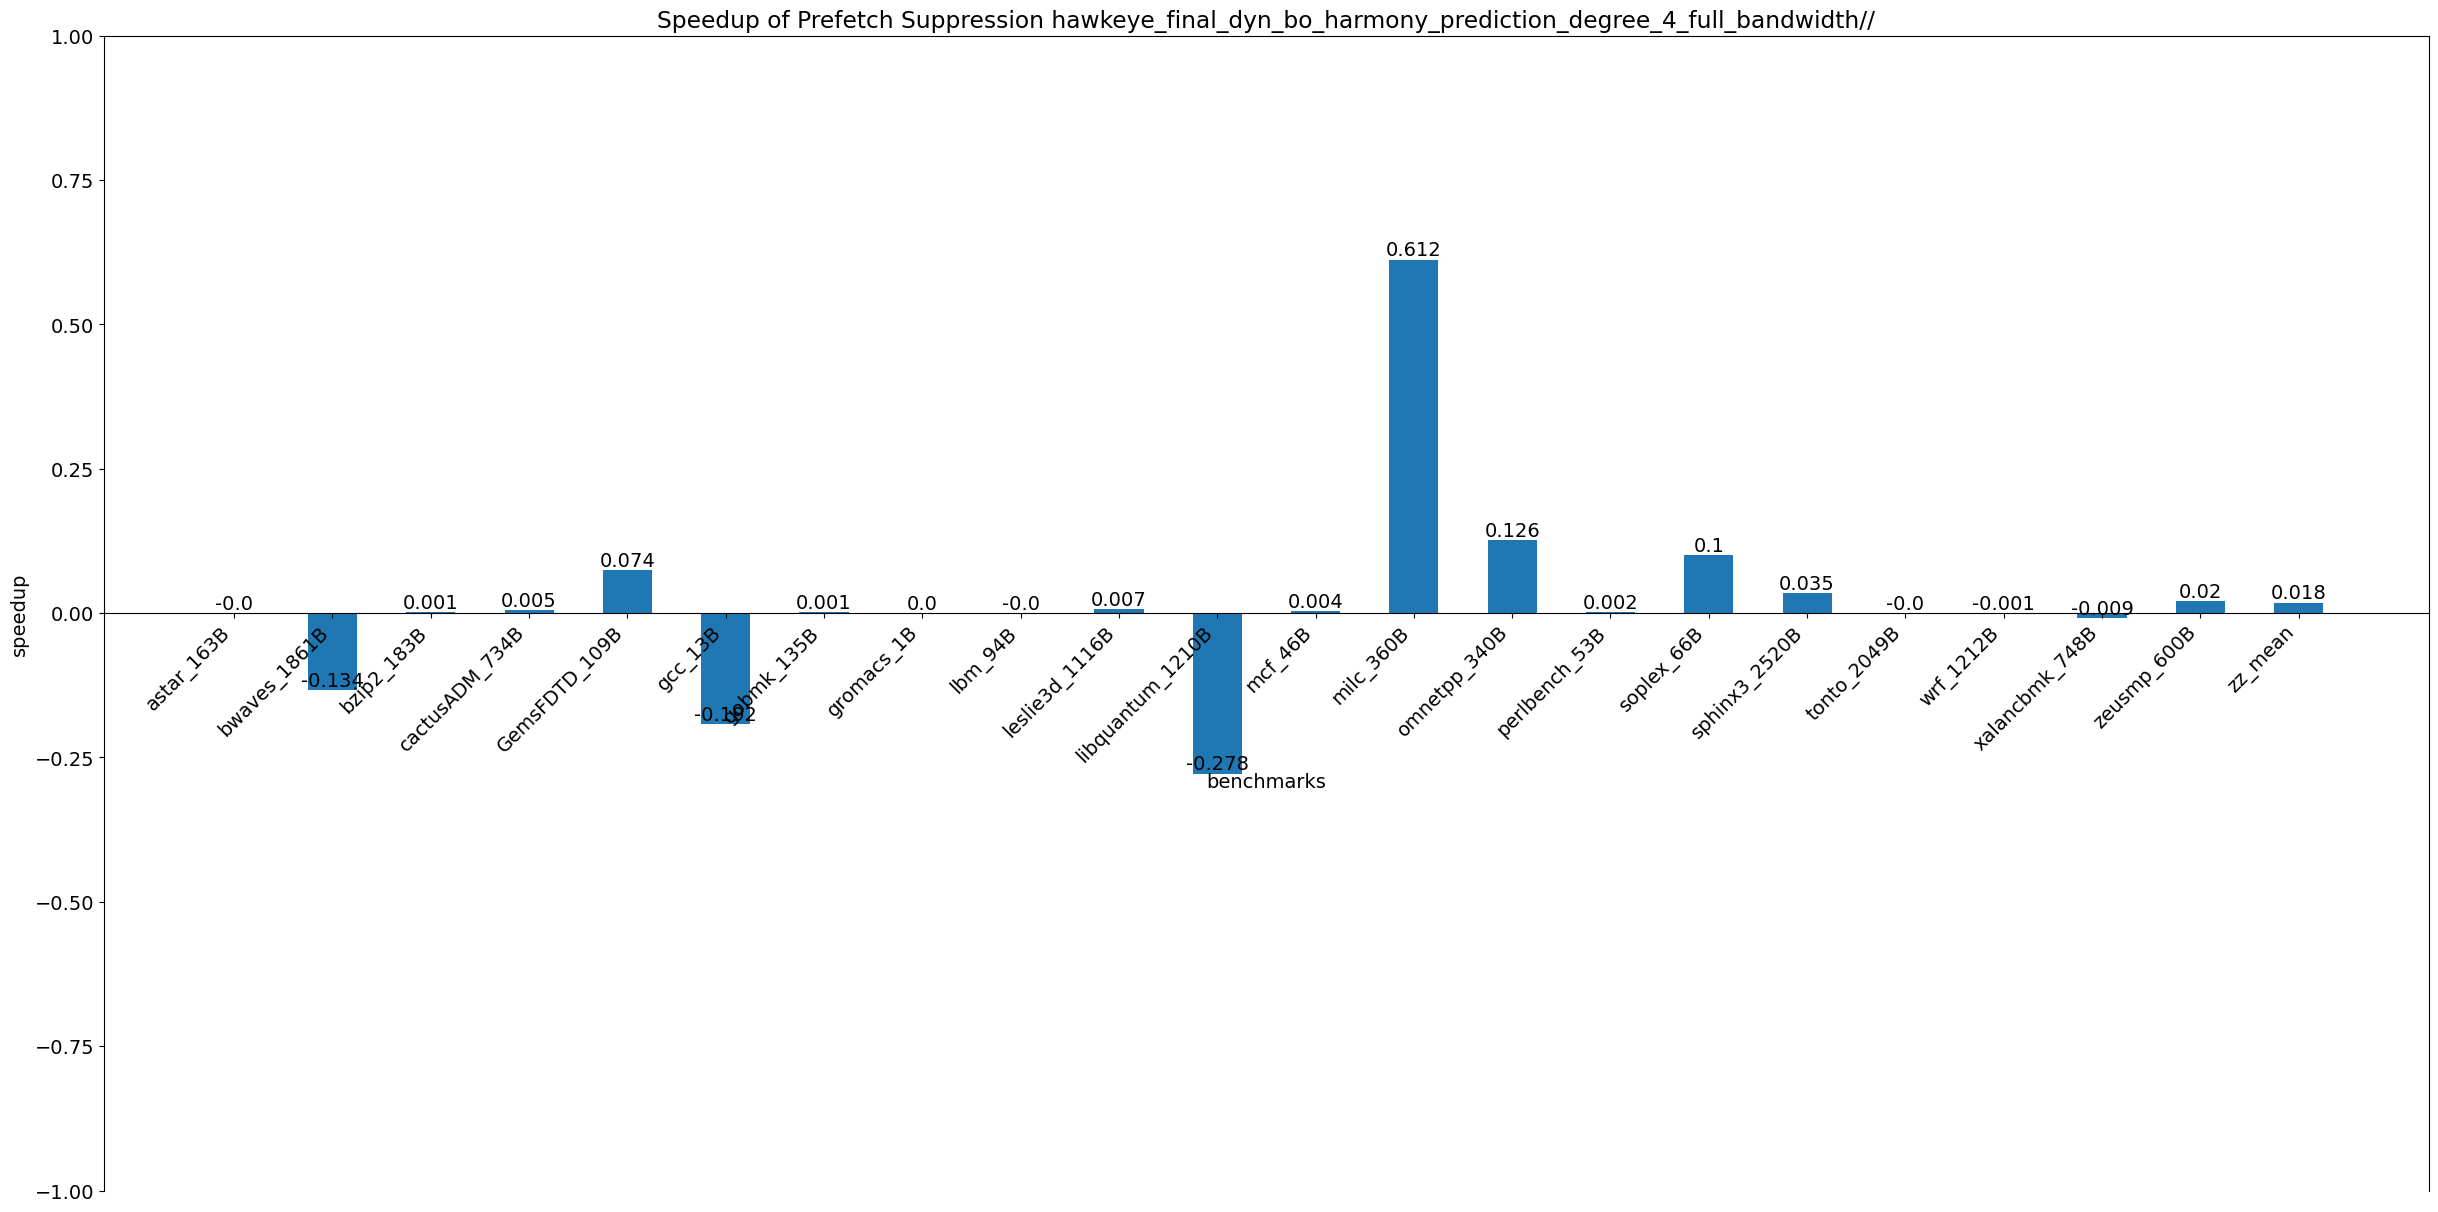

In [24]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)

In [53]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_full_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_prefetch_suppression_08_threshold_ips'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

In [54]:
(best_accuracy_thresholds, best_speedup) = find_best_accuracy_threshold(base_trace_files, traces)
print(best_accuracy_thresholds)
print(best_speedup)

[5, 90, 55, 75, 90, 5, 70, 5, 35, 90, 5, 55, 85, 20, 65, 35, 80, 5, 50, 50, 75]
[1.0, 1.0312853141009644, 1.0023487048781934, 1.0009427856920288, 1.088507141214111, 1.0028051997997902, 1.0000022578179768, 1.0, 0.9891679695848286, 1.0206245135727932, 0.9971969553859862, 1.0030185562445584, 1.1002621374805082, 1.0172142843369778, 1.0010371082085325, 1.0181211114281676, 0.9853217411963858, 1.0, 1.0018537503335345, 1.0076859485667045, 0.9999177814534304]


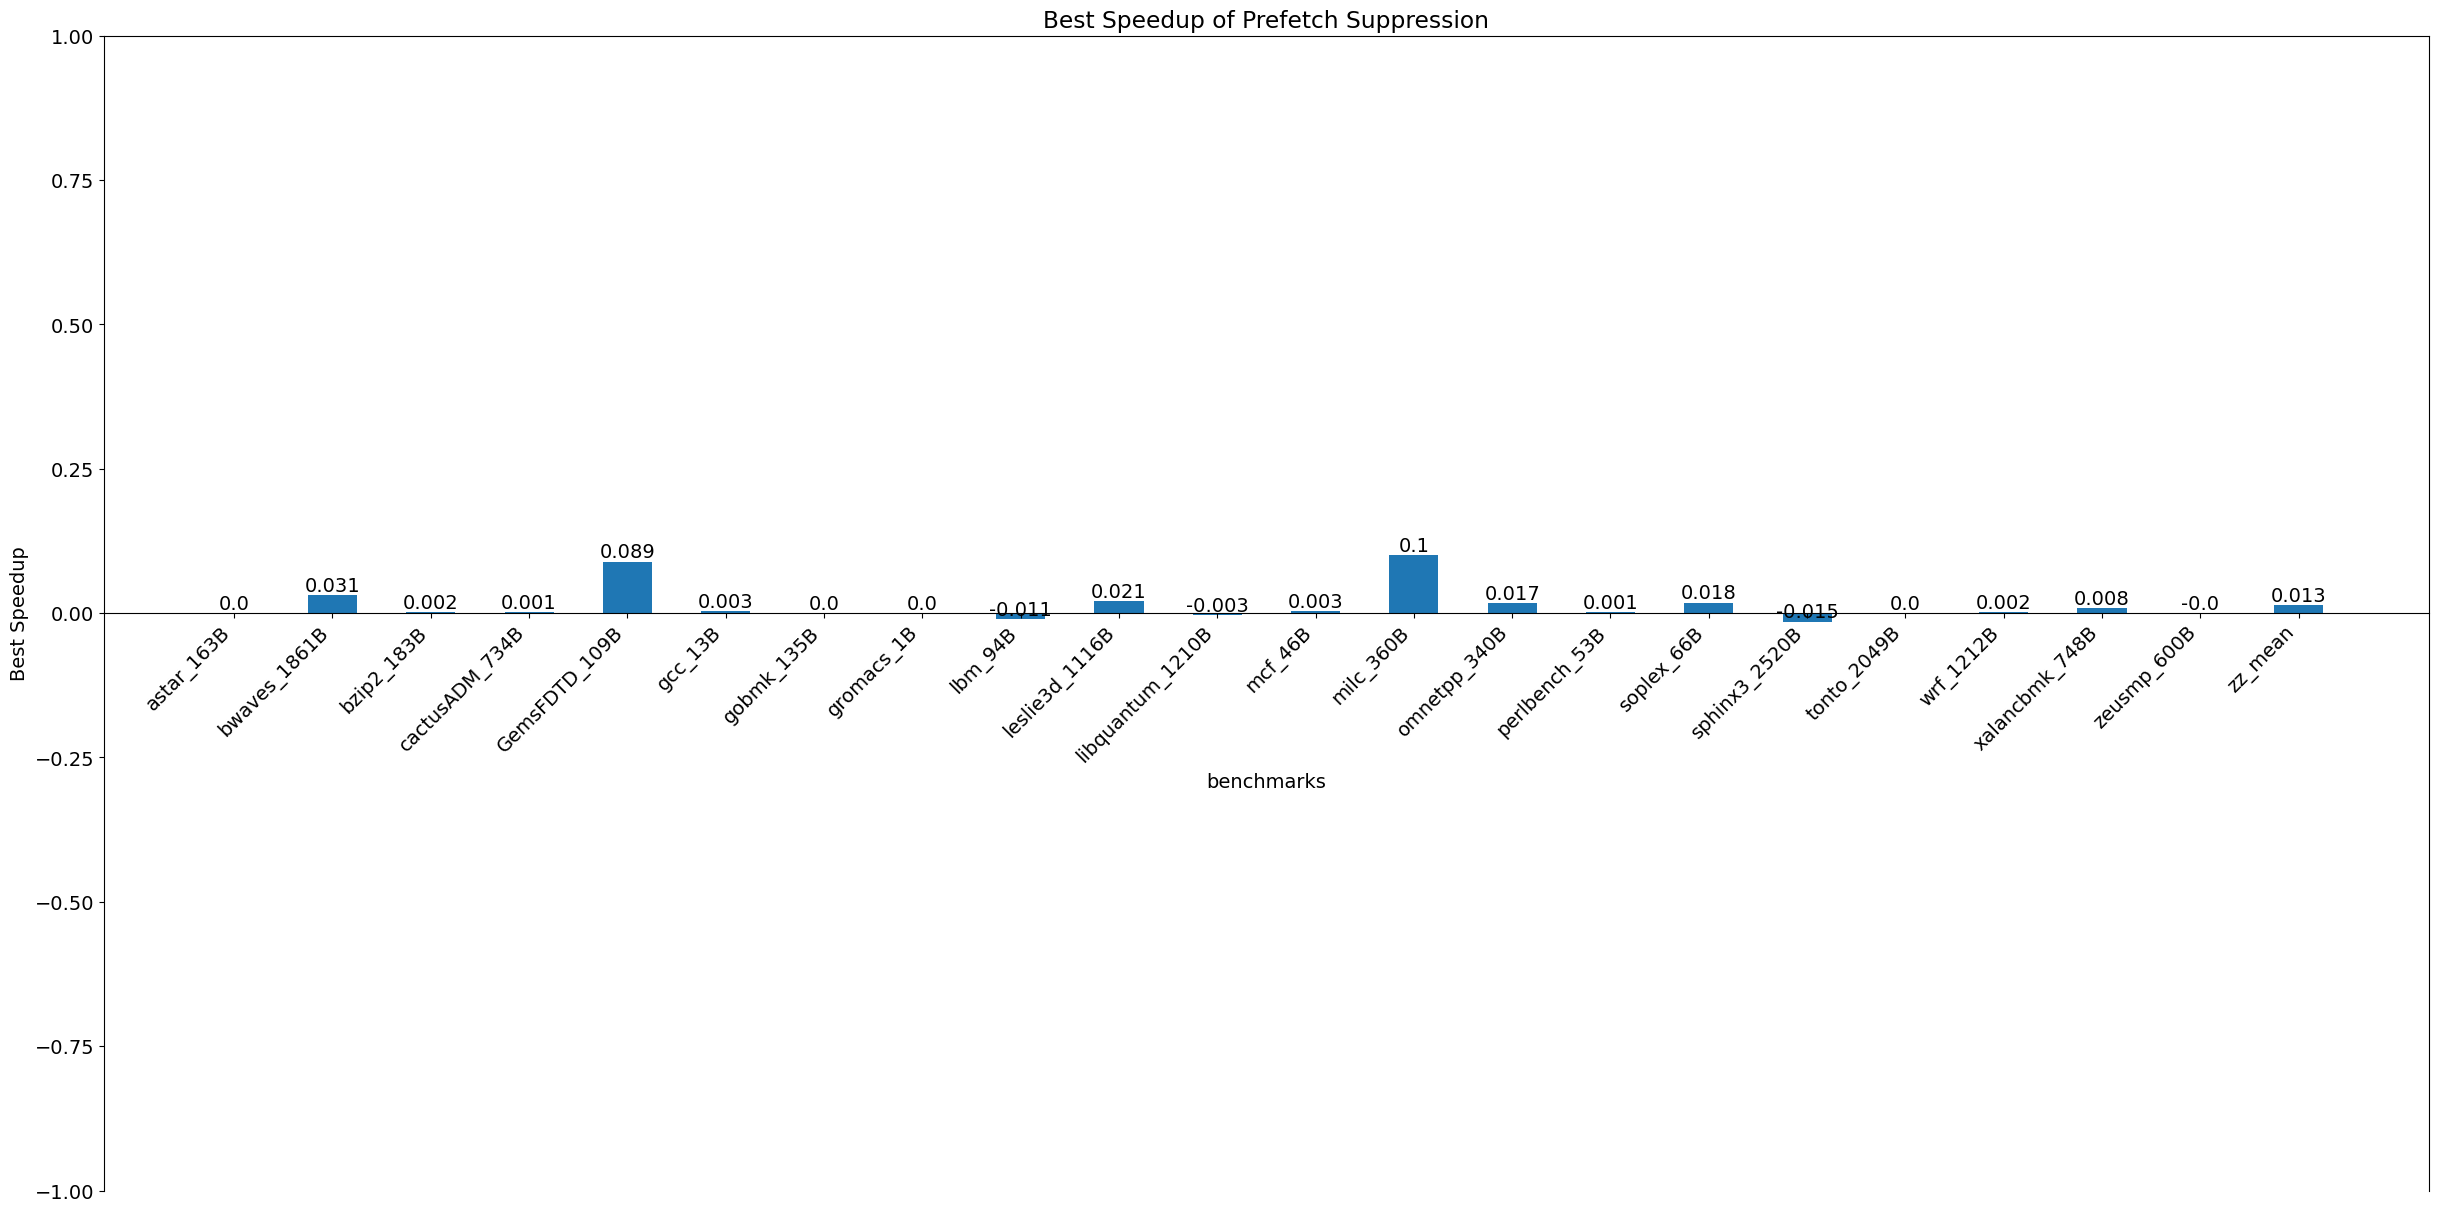

In [55]:
graph_best_speedup(traces, best_speedup)

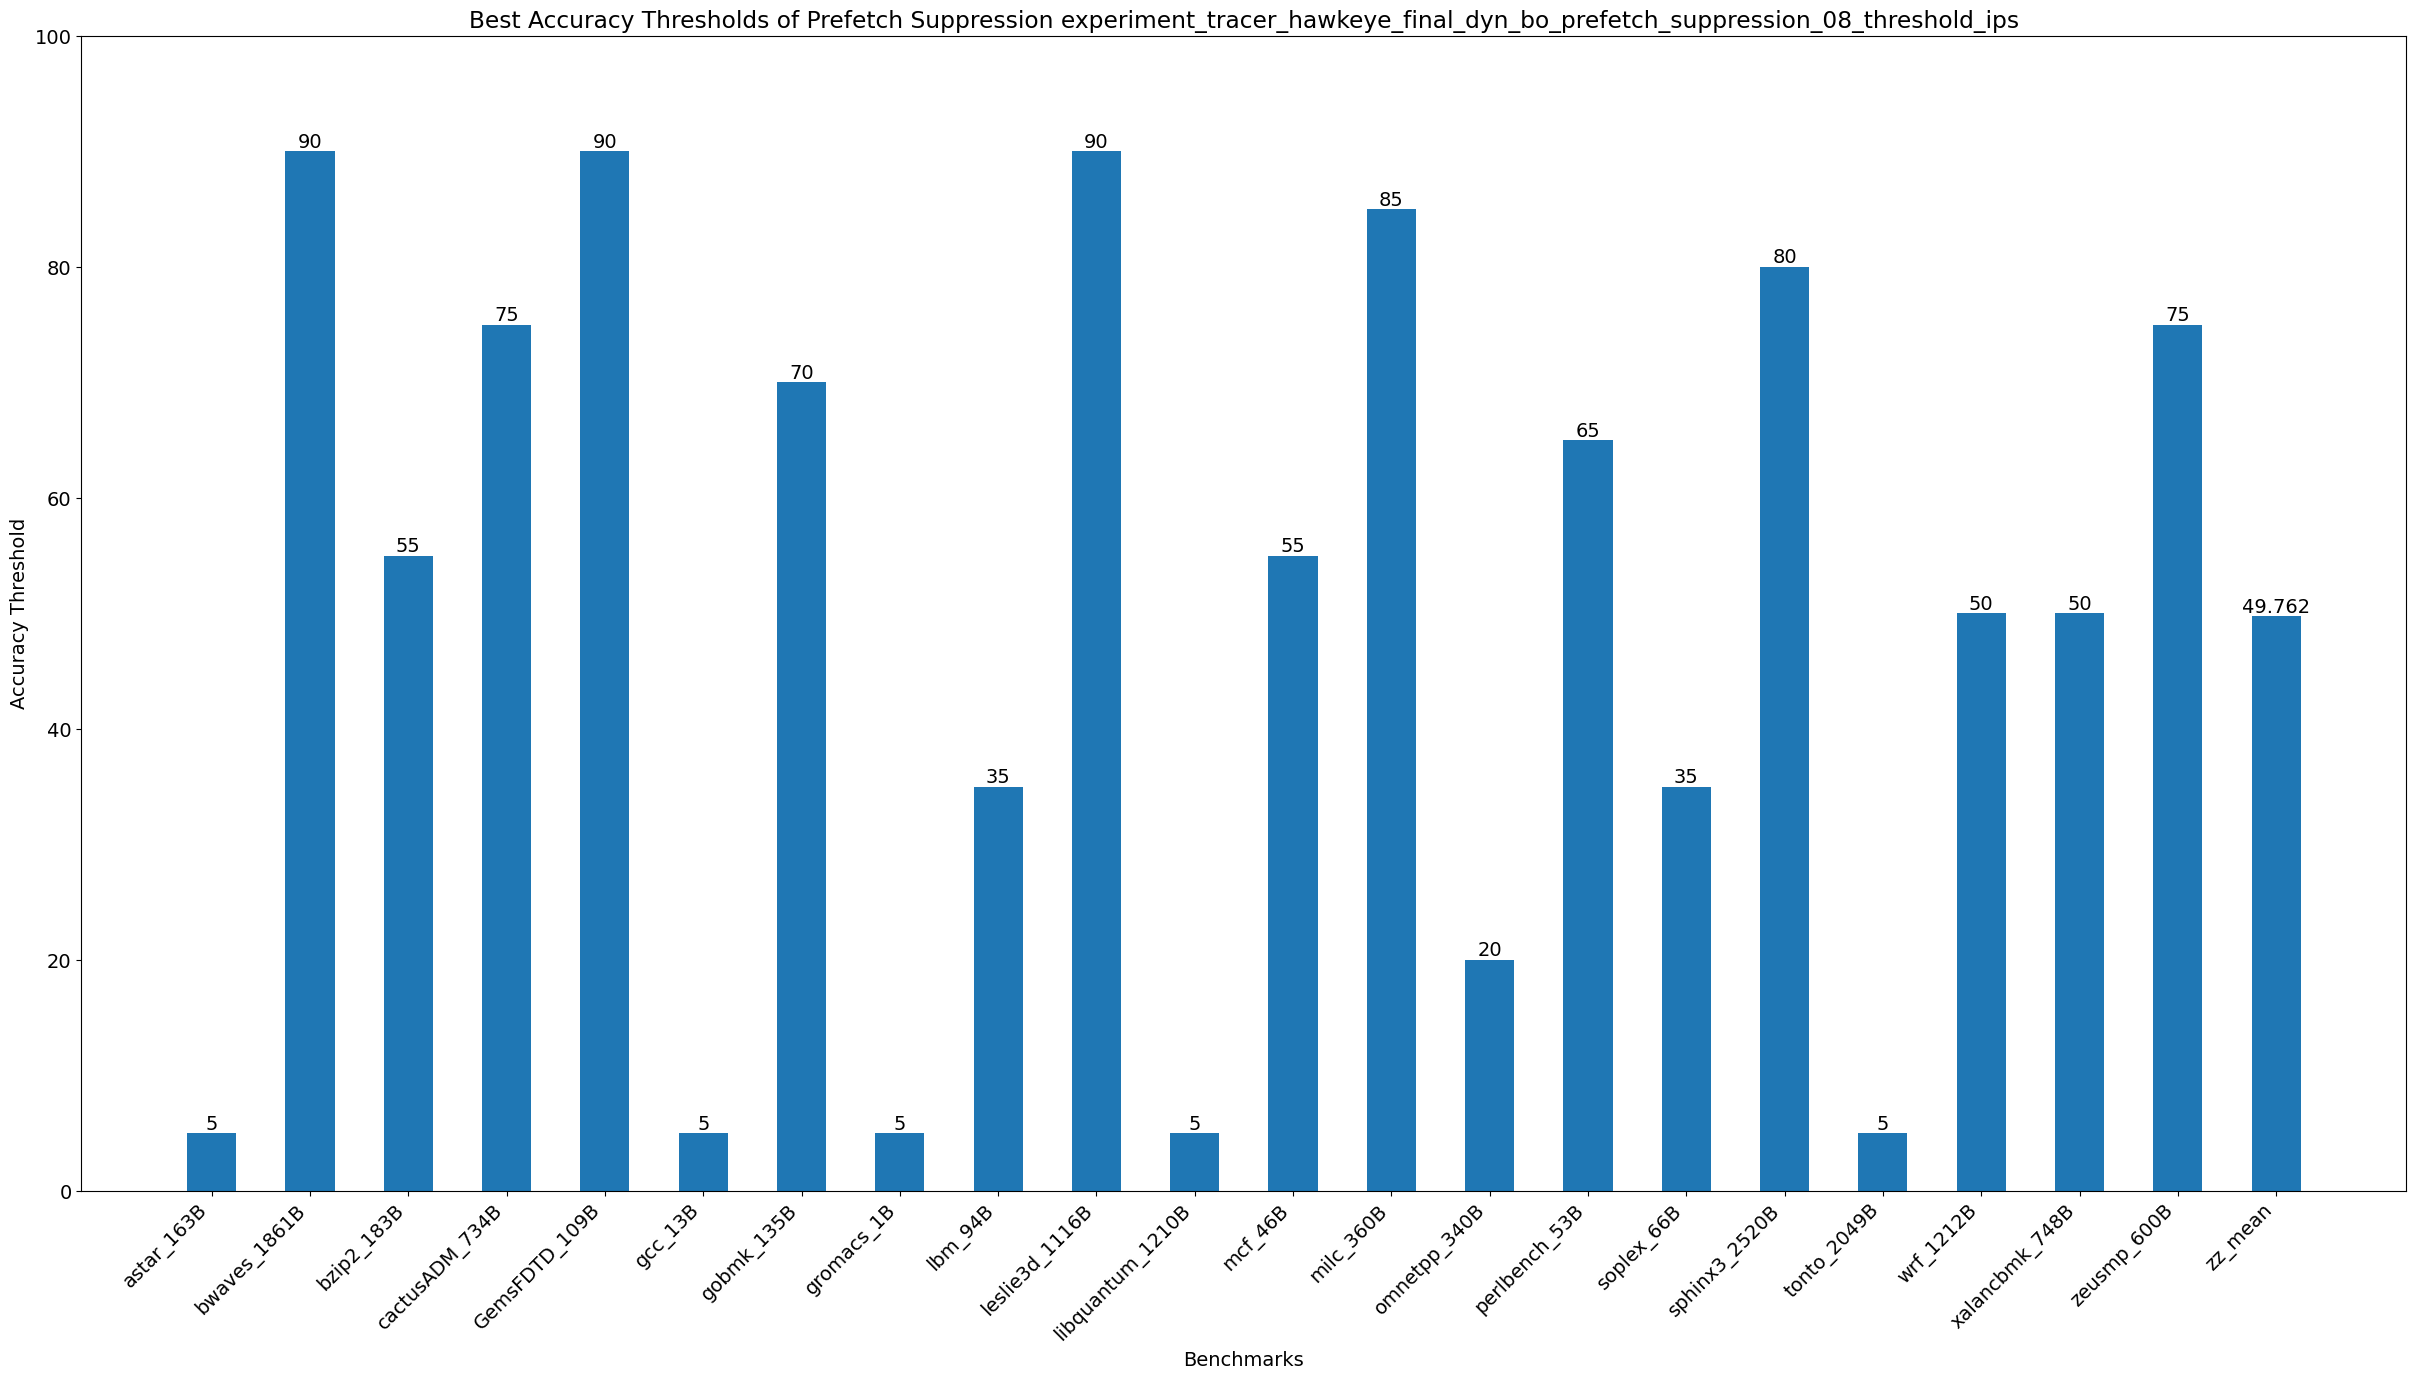

In [56]:
graph_stat(best_accuracy_thresholds, traces, 'Best Accuracy Thresholds of Prefetch Suppression', 'Accuracy Threshold', cmp_experiment)

In [62]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_half_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_prefetch_suppression_08_threshold_ips'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

In [63]:
(best_accuracy_thresholds, best_speedup) = find_best_accuracy_threshold(base_trace_files, traces)
print(best_accuracy_thresholds)
print(best_speedup)

IndexError: list index out of range

In [ ]:
graph_best_speedup(traces, best_speedup)

In [ ]:
graph_stat(best_accuracy_thresholds, traces, 'Best Accuracy Thresholds of Prefetch Suppression', 'Accuracy Threshold', cmp_experiment)

In [23]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_full_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_1_full_bandwidth_no_prefetch_suppression_prefetch_flag_fix'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

21
21


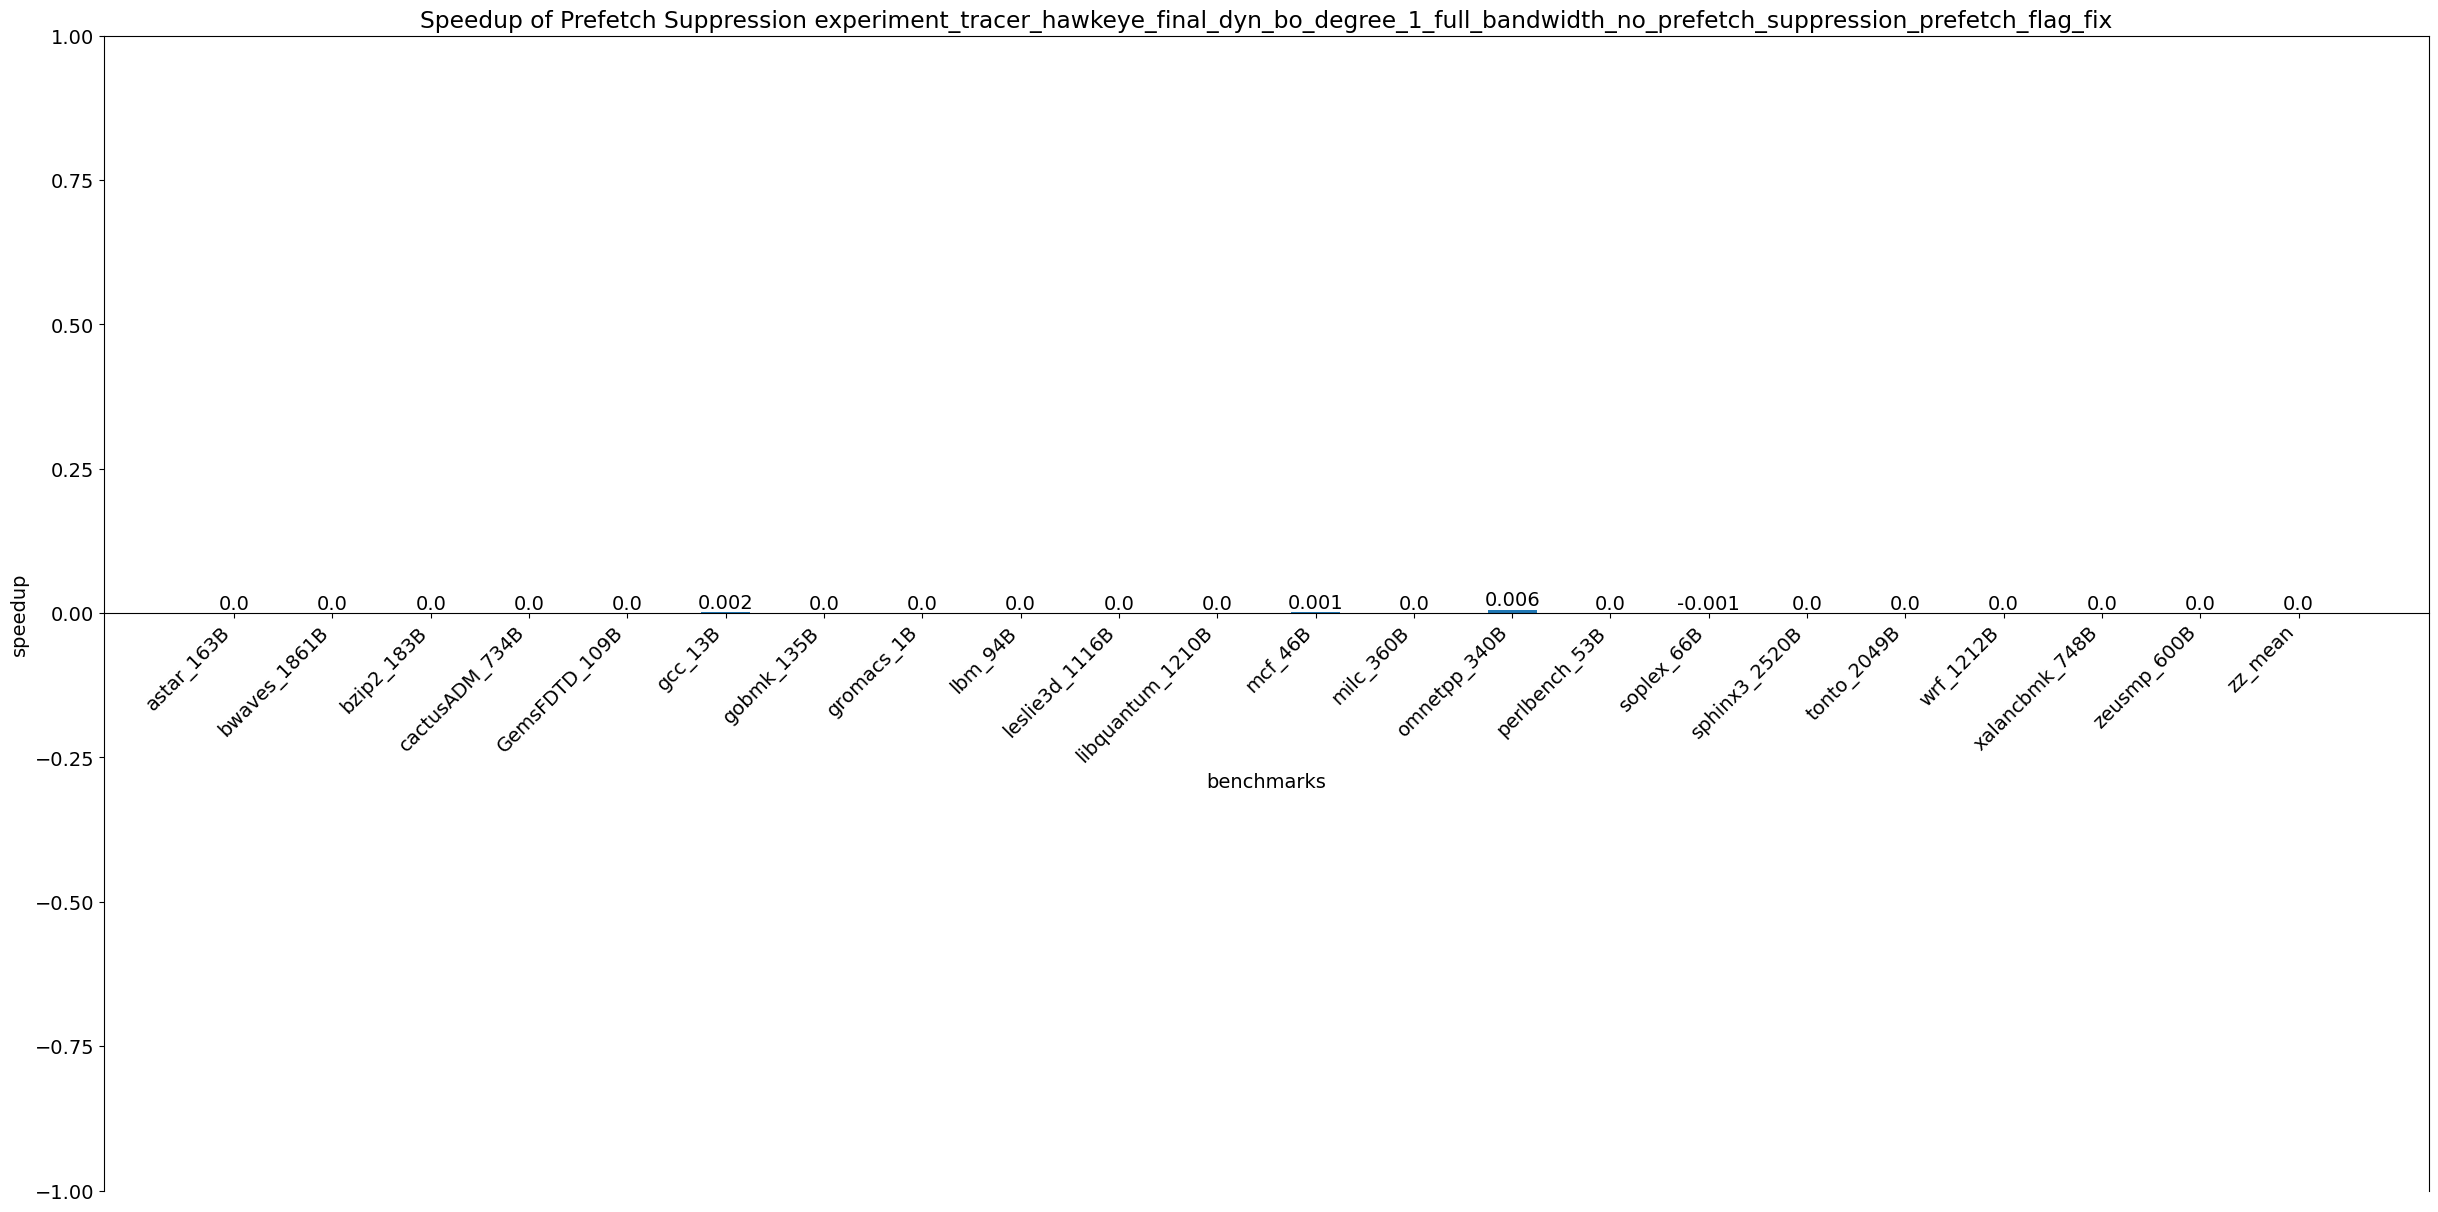

In [24]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [22]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_full_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_FDP_full_bandwidth_interval_reset_logging/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

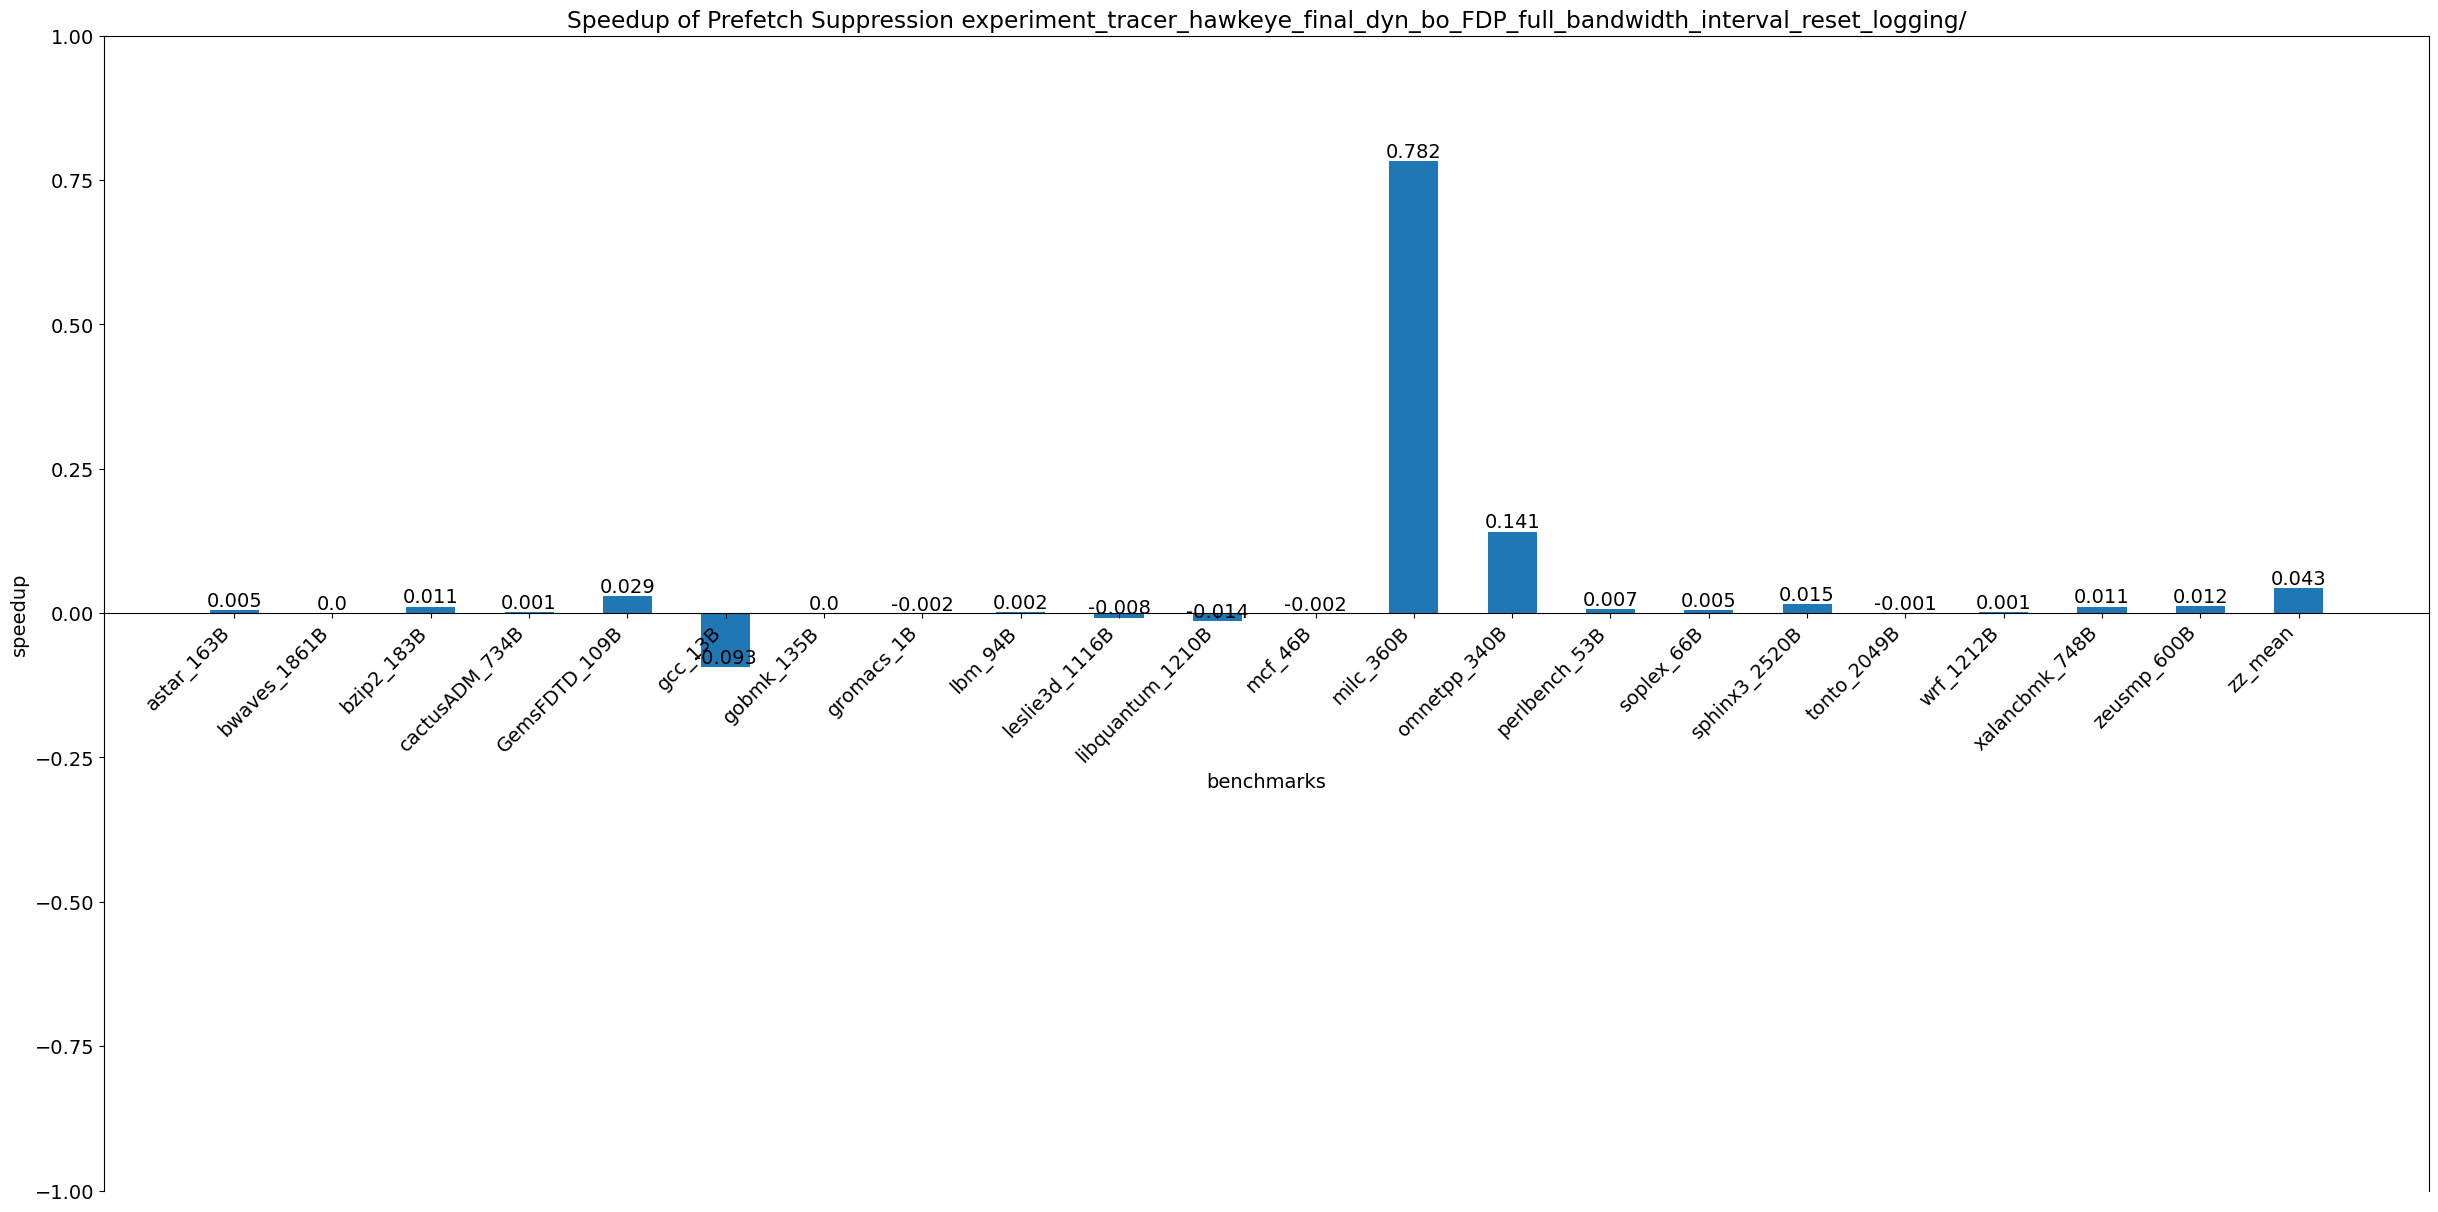

In [23]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [24]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_full_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_FDP_full_bandwidth_interval_no_reset_logging/'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

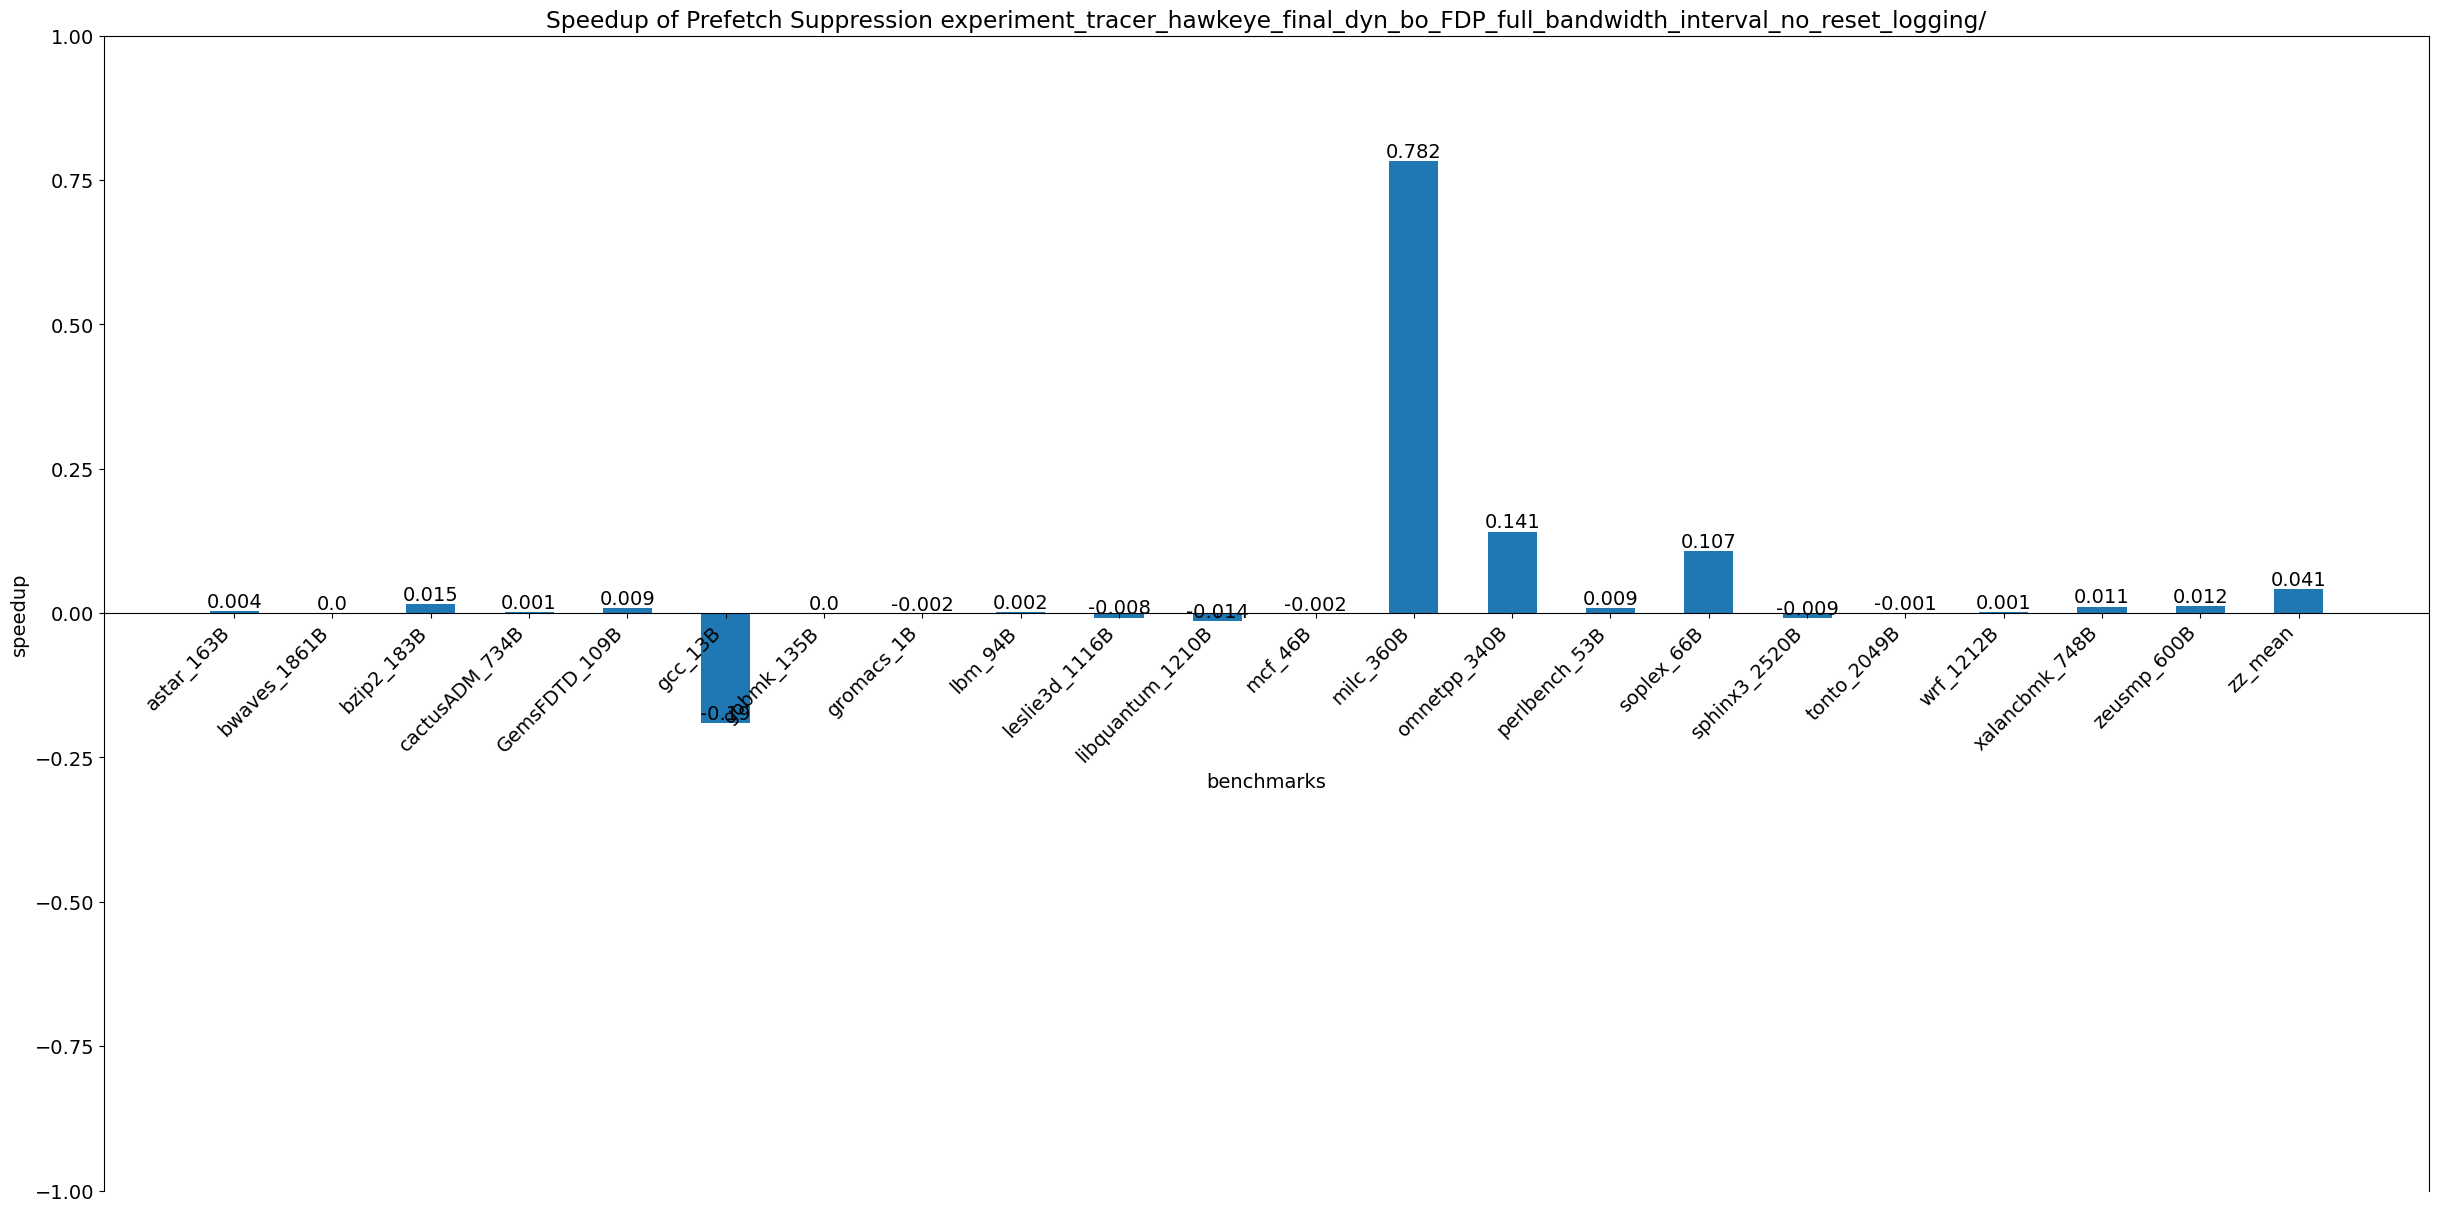

In [25]:
graph_speedup(base_trace_files, comp_trace_files, traces, cmp_experiment)
plt.show()

In [47]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_half_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_prefetch_suppression_08_threshold_ips'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

In [48]:
(best_accuracy_thresholds, best_speedup) = find_best_accuracy_threshold(base_trace_files, traces)
print(best_accuracy_thresholds)
print(best_speedup)

[30, 5, 55, 75, 60, 5, 75, 75, 10, 80, 5, 40, 85, 25, 65, 65, 70, 75, 50, 80, 45]
[1.0054316176141198, 1.0, 1.011731994593551, 1.000561055374689, 1.070262503692035, 0.999184181712789, 1.0012708003102382, 1.0000050519849248, 1.009778704592998, 1.0243075001892077, 0.9985775899625338, 1.0080648264902101, 1.7845482220545565, 1.1931553936370534, 1.011672679718264, 1.1445566845200588, 1.067749336098933, 1.0002542809536874, 1.0133841461266986, 1.0312448738878779, 1.0010491724478996]


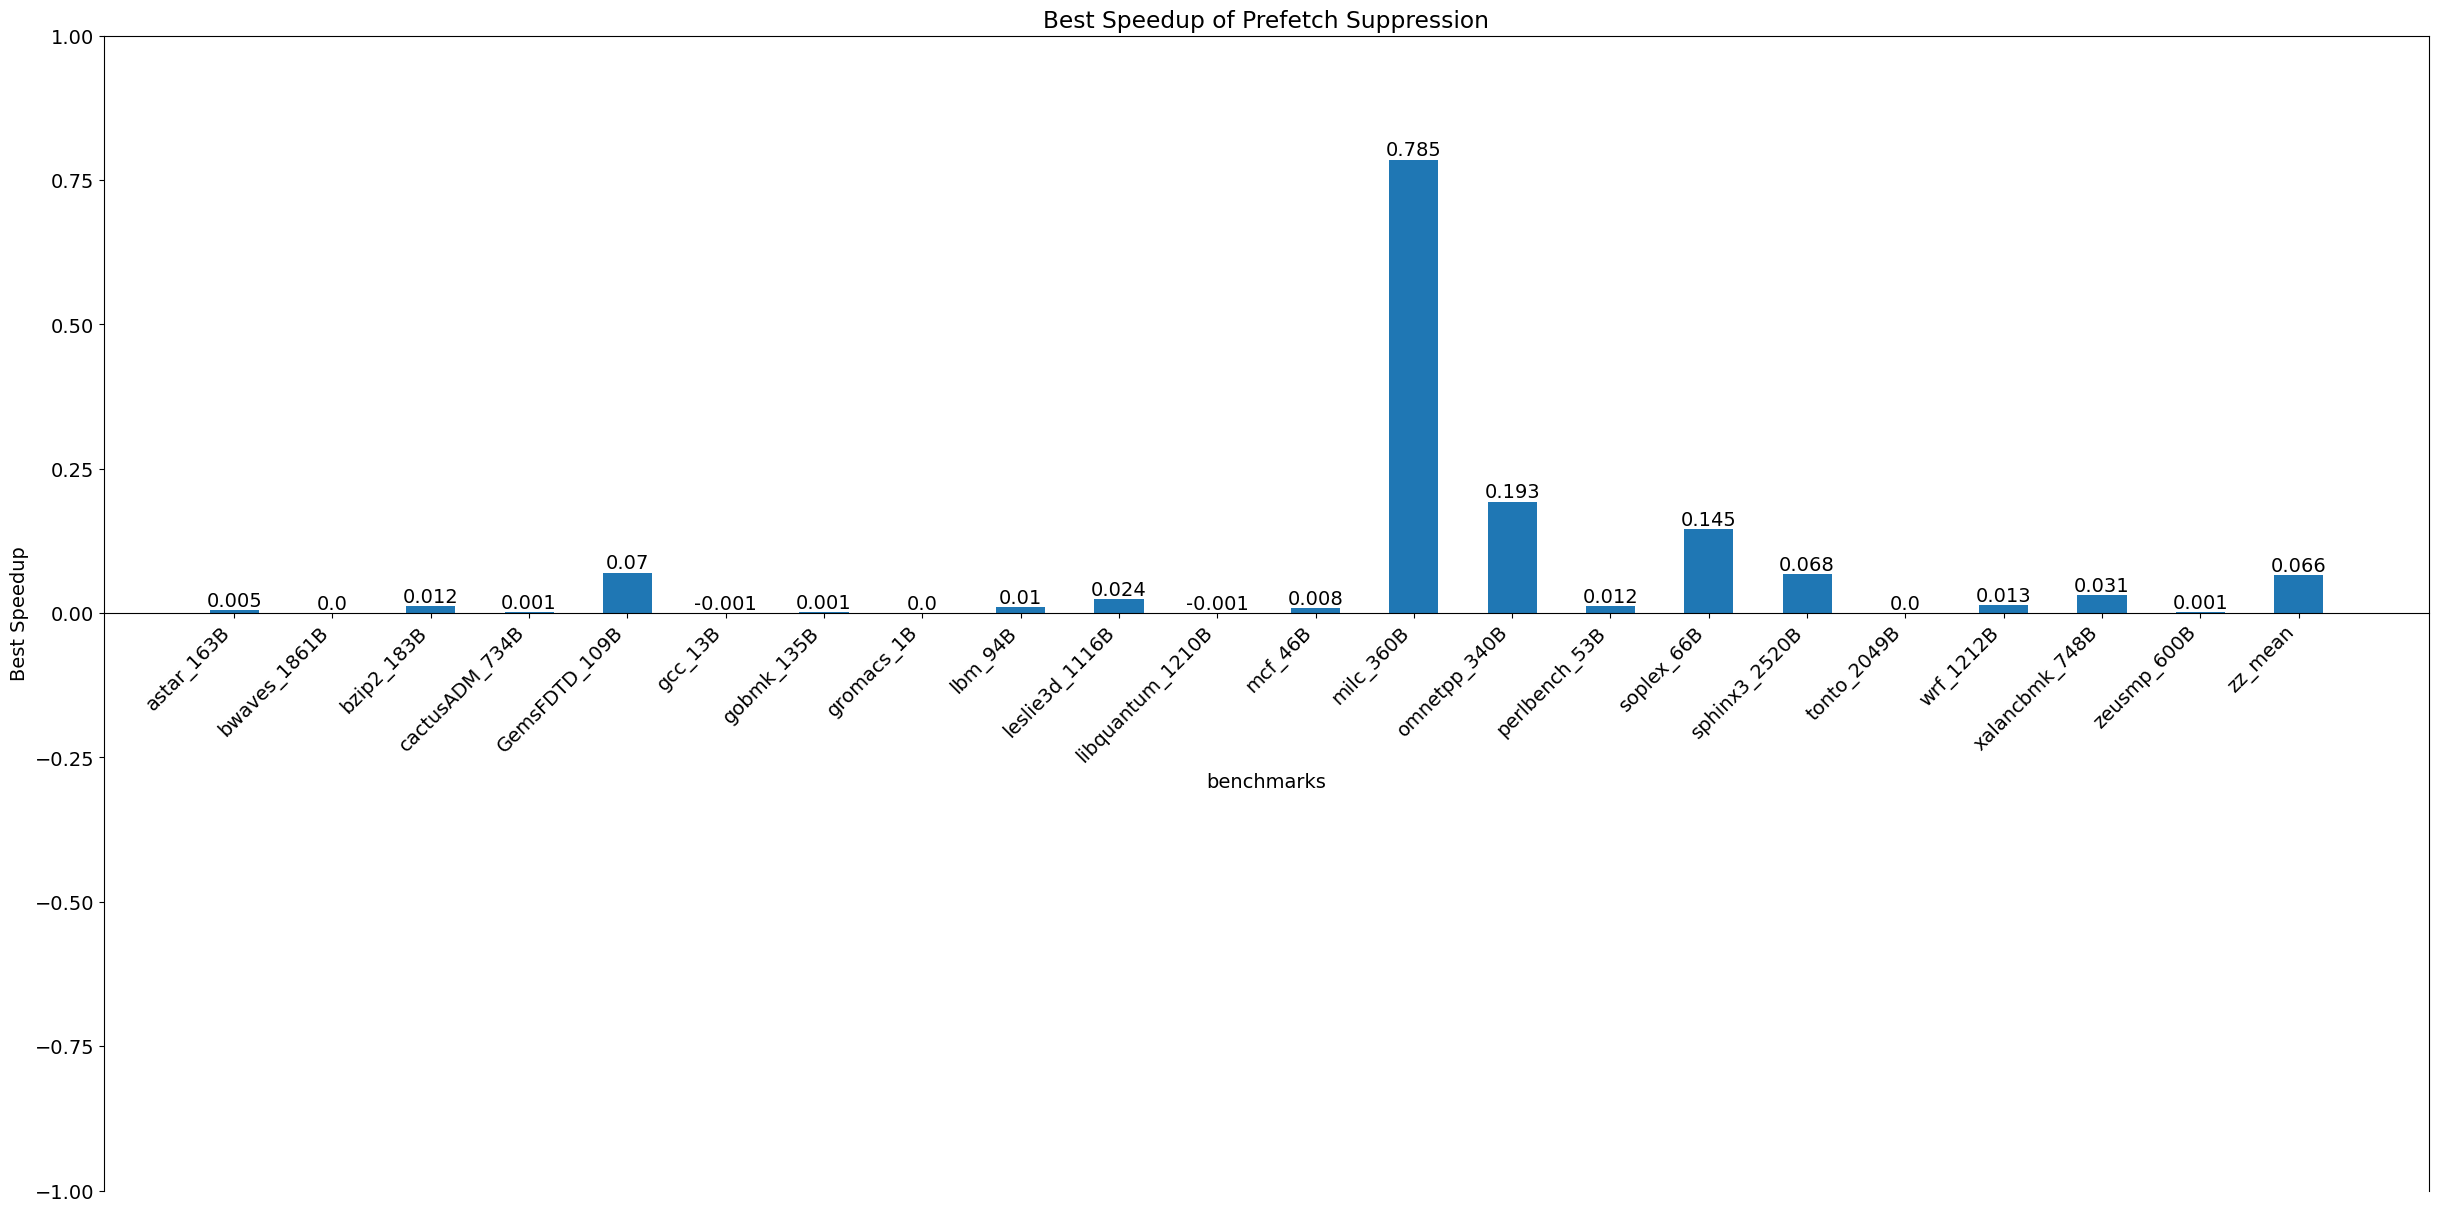

In [49]:
graph_best_speedup(traces, best_speedup)

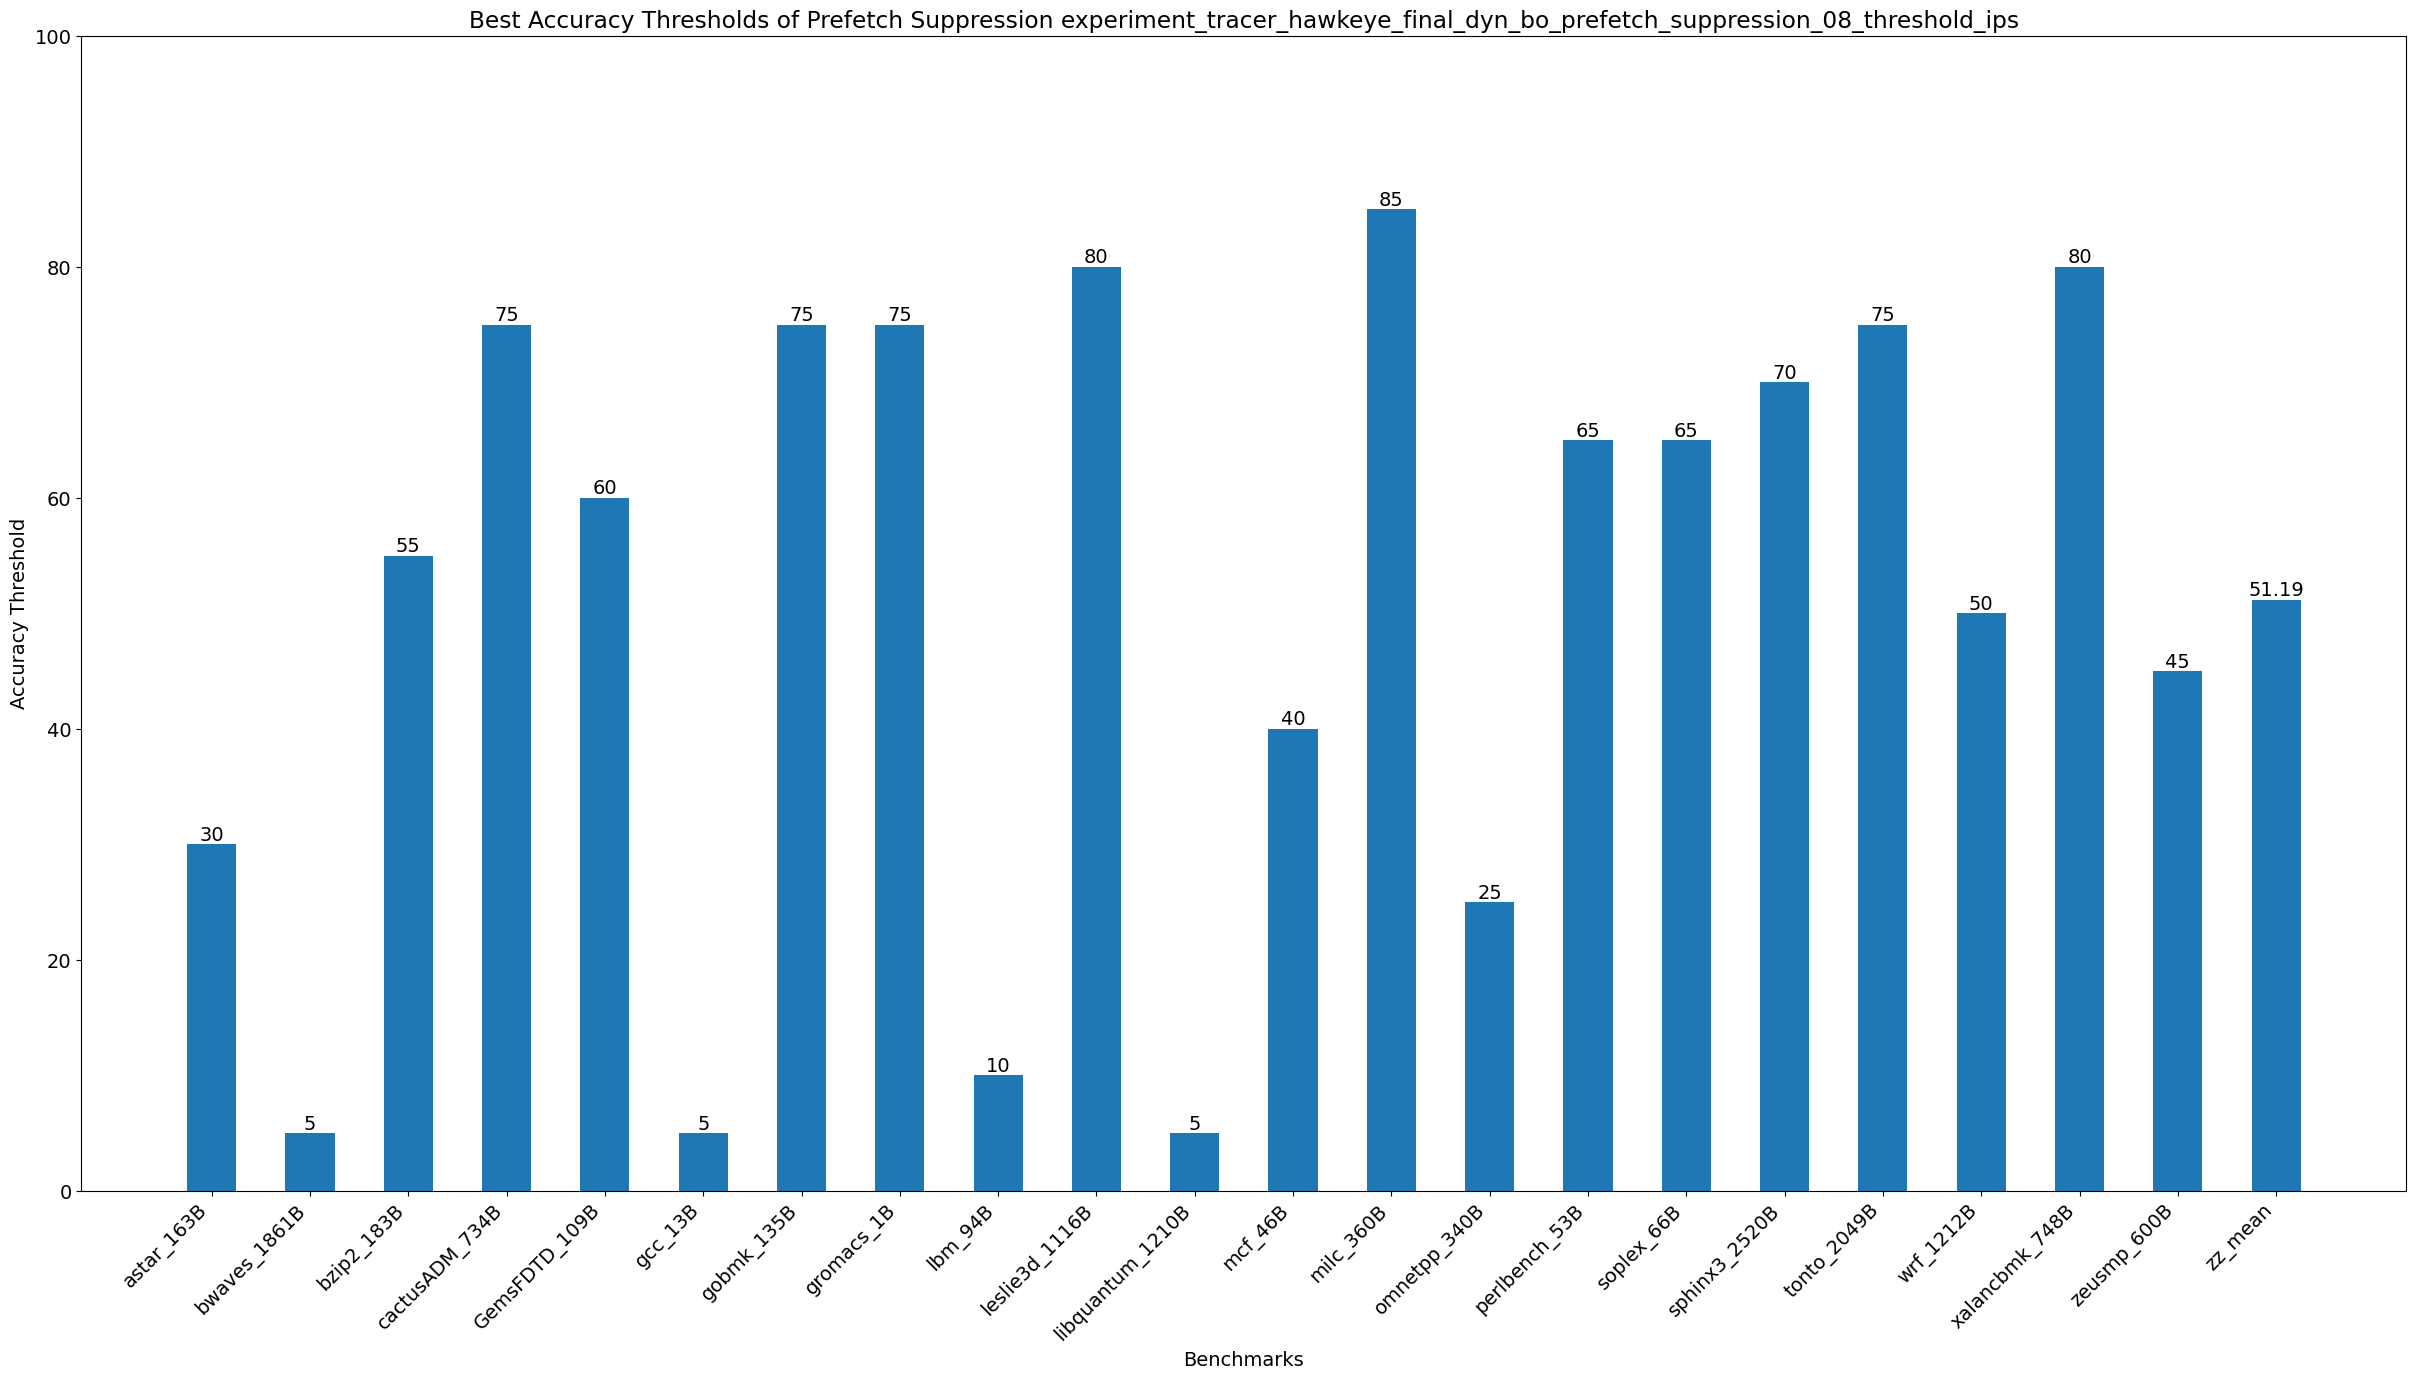

In [50]:
graph_stat(best_accuracy_thresholds, traces, 'Best Accuracy Thresholds of Prefetch Suppression', 'Accuracy Threshold', cmp_experiment)

In [52]:
# get experiment trace files
base_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_degree_4_quarter_bandwidth_no_prefetch_suppression'
cmp_experiment = 'experiment_tracer_hawkeye_final_dyn_bo_prefetch_suppression_08_threshold_ips'
trace_list = open('../sim_list/traces.txt', 'r')

(base_trace_files, traces) = get_experiment_traces(base_experiment, trace_list)
trace_list = open('../sim_list/traces.txt', 'r')
(comp_trace_files, traces) = get_experiment_traces(cmp_experiment, trace_list)

In [53]:
(best_accuracy_thresholds, best_speedup) = find_best_accuracy_threshold(base_trace_files, traces)
print(best_accuracy_thresholds)
print(best_speedup)

[30, 65, 80, 5, 50, 5, 80, 5, 80, 85, 5, 45, 90, 90, 65, 70, 85, 85, 85, 80, 25]
[1.0022096753015326, 1.0021792517763606, 1.0338734517334032, 1.0010471117168476, 1.0525709617832988, 0.9925702446749247, 1.002854096668743, 1.0, 1.0130639808565773, 1.039004501705335, 0.9732865719877885, 1.016207897874372, 1.8302682189309567, 1.262930403755023, 1.0135989721919467, 1.202221106536801, 1.093153432400401, 1.000160865456154, 1.0015825528962887, 1.0442887992041605, 0.999112670760747]


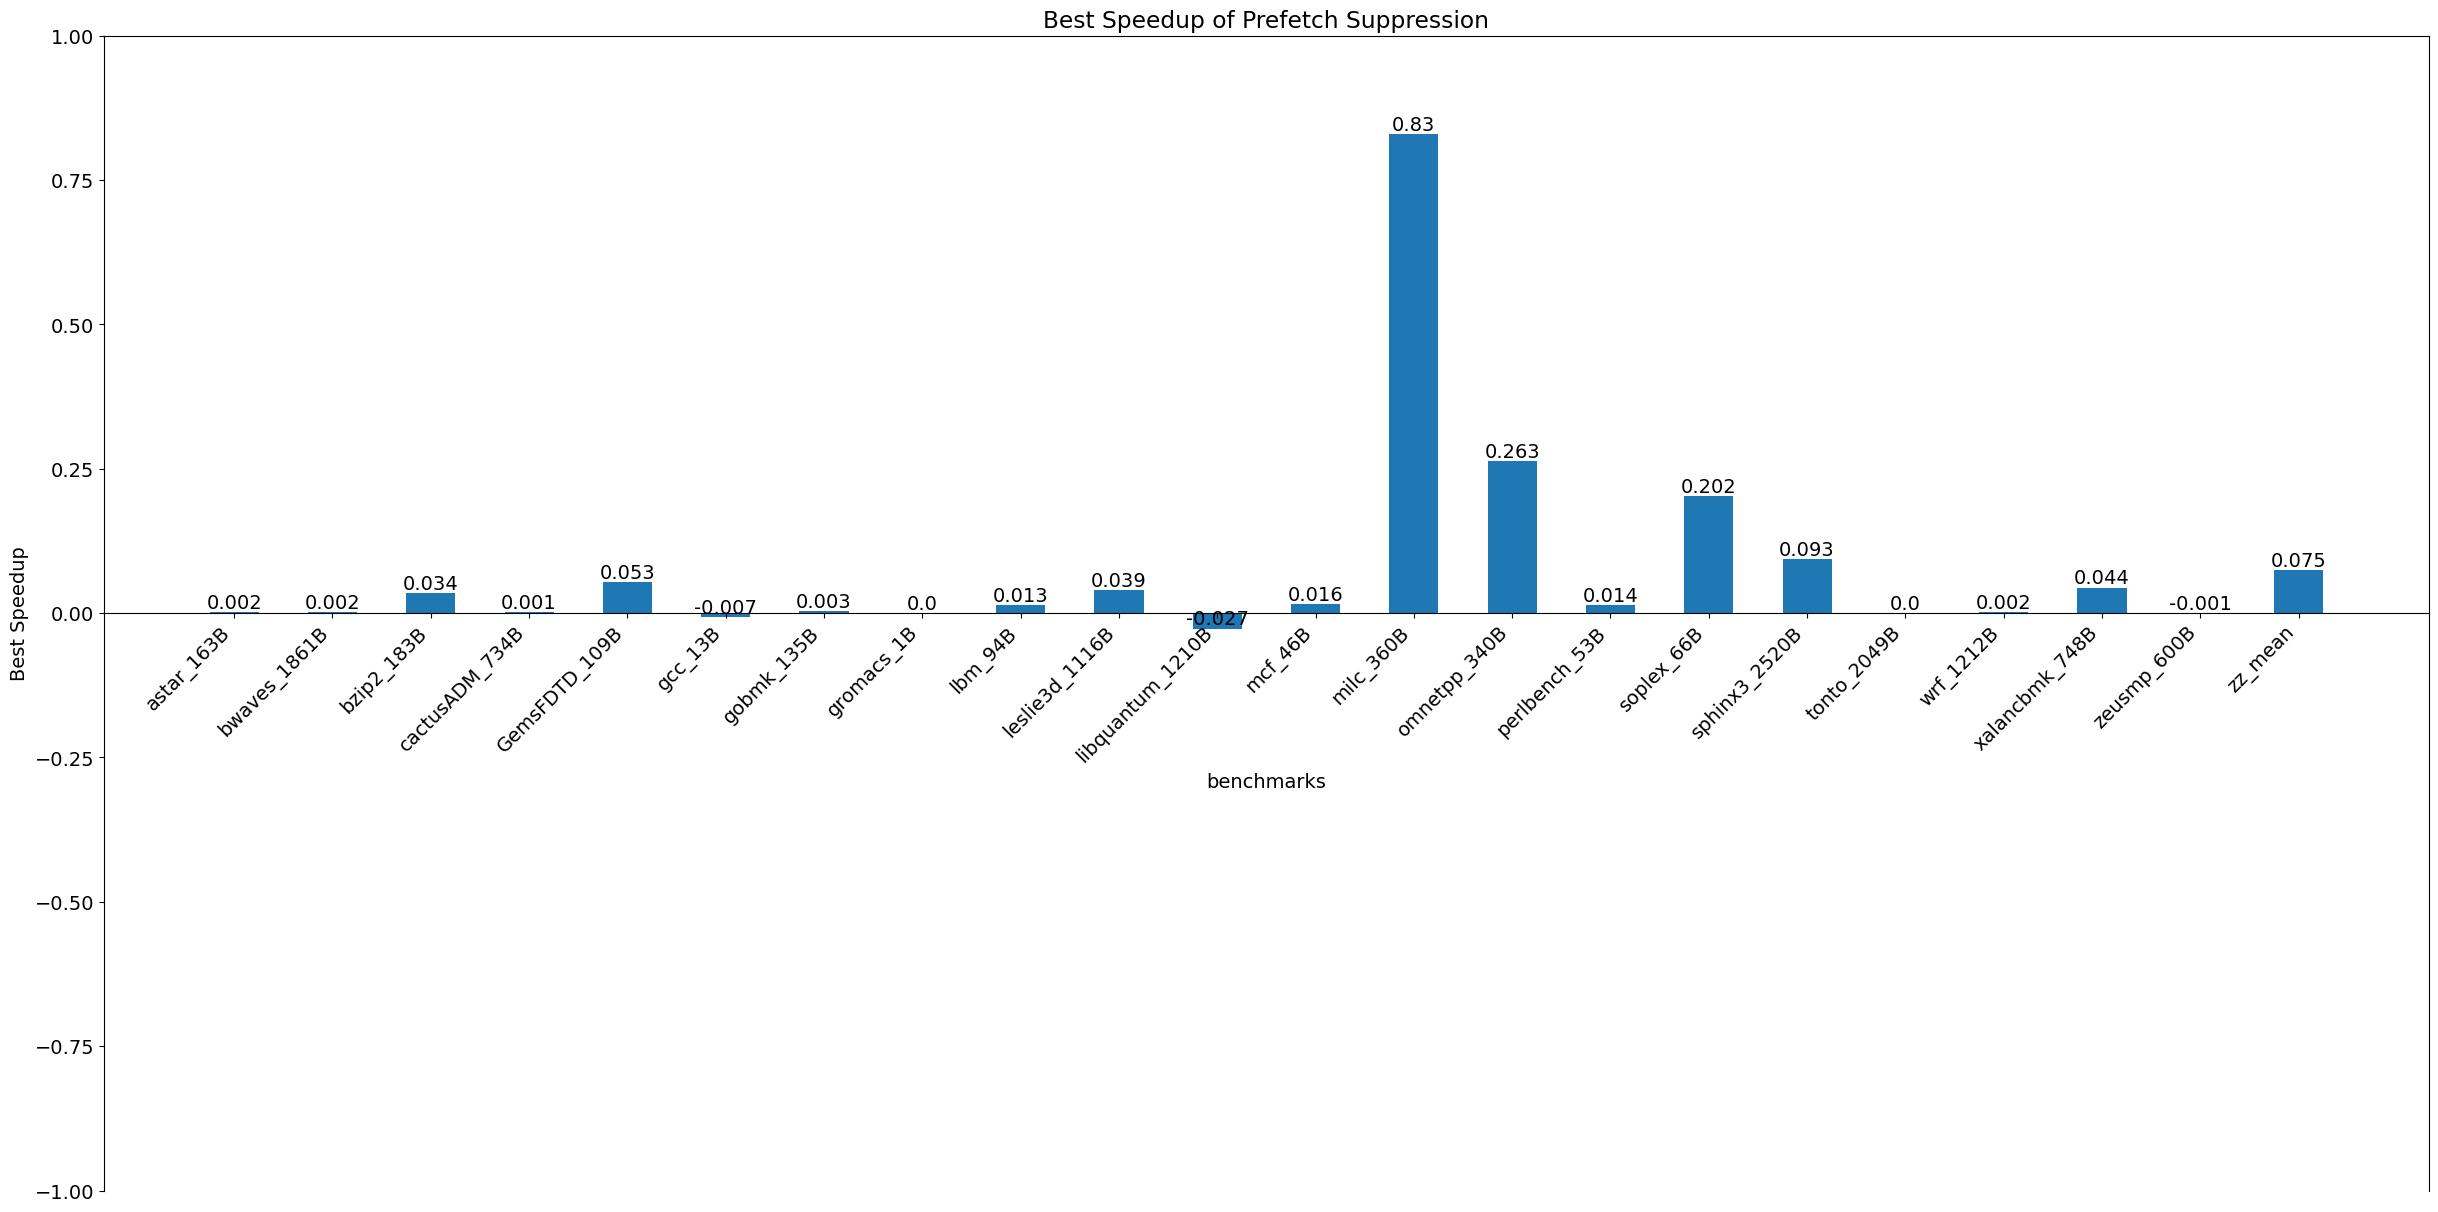

In [54]:
graph_best_speedup(traces, best_speedup)

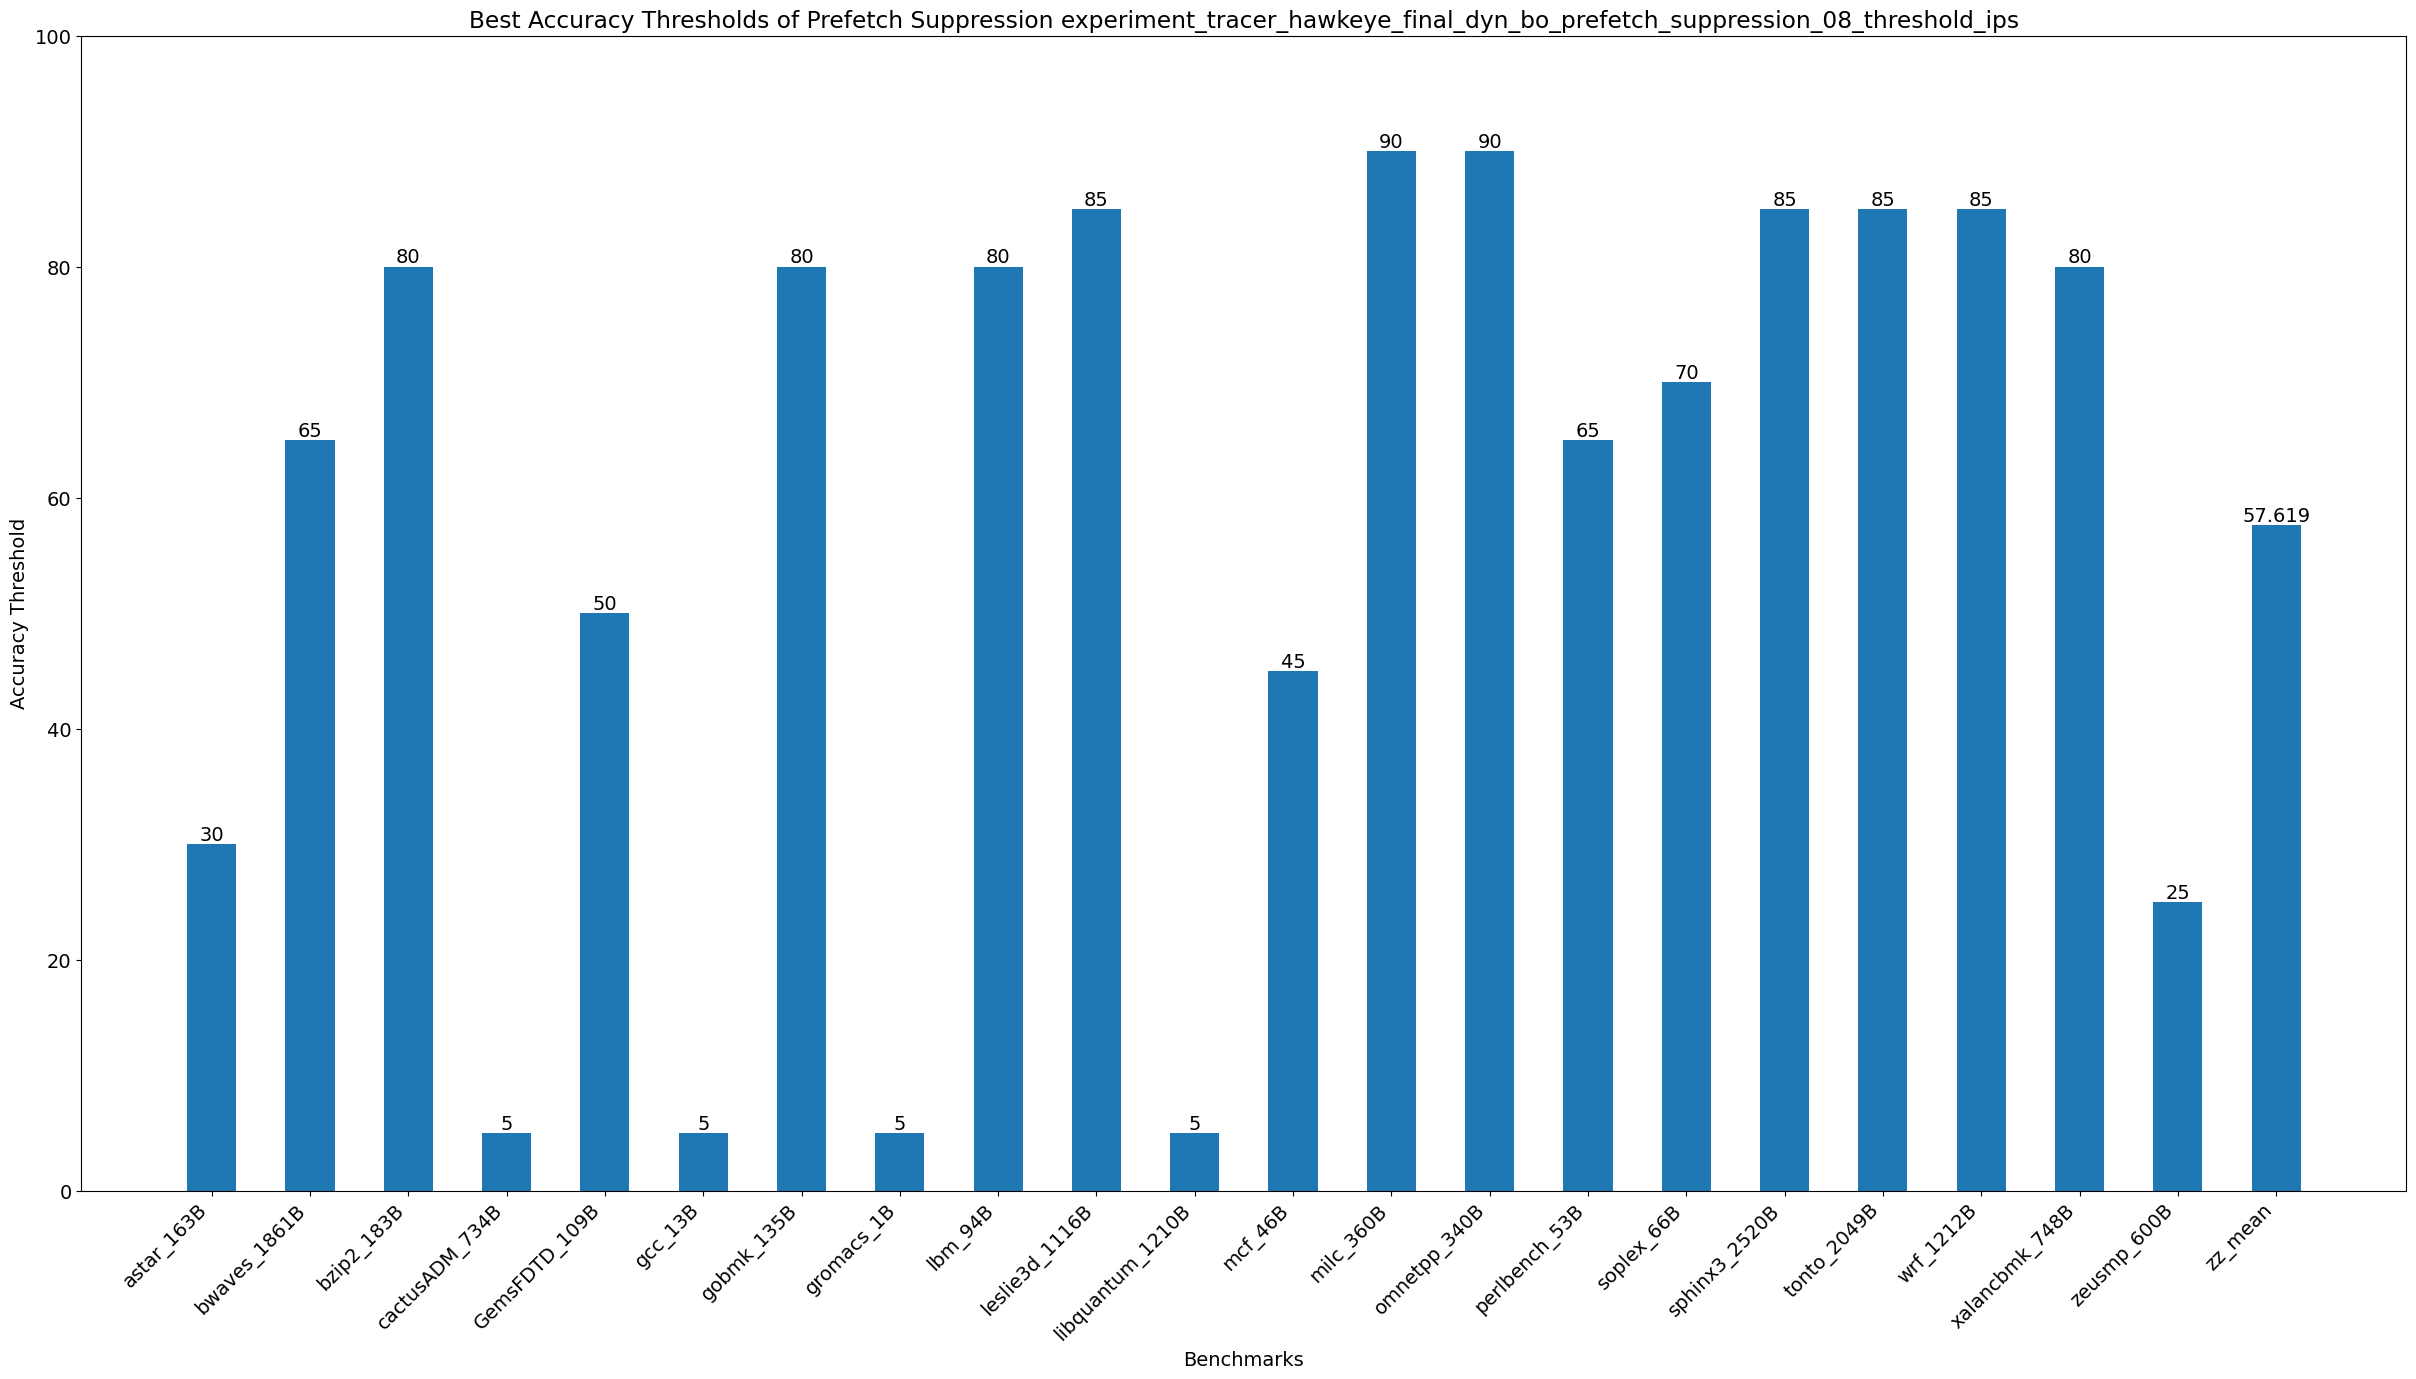

In [55]:
graph_stat(best_accuracy_thresholds, traces, 'Best Accuracy Thresholds of Prefetch Suppression', 'Accuracy Threshold', cmp_experiment)